# HitHub - a Hit List Predictor

This file has been prepared to reveal some information about the dataset and to extract the best possible model.

---

## Imports

In [1]:
# This package is cannot be installed from conda, hence should be installed as
!pip install tensorflow_addons

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
import datetime
import os
import pickle

from pathlib import Path

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score as calculate_accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.feature_selection import RFE
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier 
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA


import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import Sequential

C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:37: UserWarning: You are currently using a nightly version of TensorFlow (2.6.0-dev20210524). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  warnings.warn(


---
## Functions

In [3]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Compute the labels from the normalized confusion matrix.
    labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

def log_confusion_matrix(epoch, logs):
    # Use the model to predict the values from the validation dataset.
    test_pred_raw = model.predict(test_images)
    test_pred = np.argmax(test_pred_raw, axis=1)

    # Calculate the confusion matrix.
    cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
    # Log the confusion matrix as an image summary.
    figure = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figure)

    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

def draw_line_graph(X, y, x_label, y_label, title, path):
    plt.figure(figsize=(12,10))
    plt.plot(X, y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.savefig('{}/{}.png'.format(path,title))
    plt.show()
    
def draw_bar_graph(X, y, x_label, y_label, title, path):
    plt.figure(figsize=(12,10))
    plt.bar(X, y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.savefig('{}/{}.png'.format(path,title))
    plt.show()

def scale_data_fit_transform(df, method='robust'):
    
    if method == 'standard':
        scaler = preprocessing.StandardScaler()
    elif method == 'minmax':
        scaler = preprocessing.MinMaxScaler()
    elif method == 'robust':
        scaler = preprocessing.RobustScaler()
    
    scaler = scaler.fit(df[df.columns[:-1]])
    
    # First, copy df to df_scaled for avoiding modify actual df 
    df_scaled = df.copy()
    
    # We should make sure that the last column is target
    assert df_scaled.columns[-1] == 'target', "The last column is not target"
    df_scaled[df_scaled.columns[:-1]] = scaler.transform(df_scaled[df_scaled.columns[:-1]])

    # Make sure target is int
    df_scaled['target'] = pd.to_numeric(df_scaled['target'], downcast='integer')
    
    return df_scaled, scaler


# Expects confusion matrix, extracts information about the prediction
def performance(cm):
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    print("True Negative :", TN)
    print("False Positive :", FP)
    print("False Negative :", FN)
    print("True Positive : ", TP)
    
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN) 
    
    print('Sensitivity : ', TPR)
    print('Specificity : ', TNR)
    print('Precision : ', PPV)
    print('Negative predictive value : ', NPV)
    print('False positive rate : ', FPR)
    print('False negative rate : ', FNR)
    print('False discovery rate : ', FDR)
    print('Accuracy : ', ACC)

def print_report(y_test, y_pred):
    print()
    print("--- Classification Report ---")
    print(classification_report(y_test, y_pred))
    
    print()
    print("--- Confusion Matrix ---")
    print(confusion_matrix(y_test, y_pred))
    performance(confusion_matrix(y_test, y_pred))
    print()
    
def gaussian_nb(X_train, X_test, y_train, y_test, smoothing_parameter):
    print("--- GAUSSIAN NAIVE BAYES WITH SMOOTHING {} ---".format(smoothing_parameter))
    gauss_nb_clf = GaussianNB(var_smoothing=smoothing_parameter)
    gauss_nb_clf.fit(X_train, y_train)
    y_pred = gauss_nb_clf.predict(X_test)
    print_report(y_test, y_pred)
    gauss_nb_accuracy_score = calculate_accuracy_score(y_test, y_pred)
    return gauss_nb_clf, gauss_nb_accuracy_score, y_pred
    

def svm(X_train, X_test, y_train, y_test, kernel):
    print("--- SUPPORT VECTOR MACHINE WITH KERNEL {}---".format(kernel))
    svm_clf = SVC(kernel=kernel)
    svm_clf.fit(X_train, y_train)
    y_pred = svm_clf.predict(X_test)
    print_report(y_test, y_pred)
    svm_accuracy_score = calculate_accuracy_score(y_test, y_pred)
    return svm_clf, svm_accuracy_score, y_pred

def knn(X_train, X_test, y_train, y_test, neighbors=3):
    print("--- KNN, neighbors={} ---".format(neighbors))
    knn_clf = KNN(n_neighbors=neighbors)
    knn_clf.fit(X_train, y_train)
    y_pred = knn_clf.predict(X_test)
    print_report(y_test, y_pred)
    knn_accuracy_score = calculate_accuracy_score(y_test, y_pred)
    return knn_clf, knn_accuracy_score, y_pred

# layers expects [[layer_size_1, activation_function_1], [layer_size_2, activation_function_2], ...]
# optimizer expects "adam" or "SGD"

def ann(X_train, X_test, y_train, y_test, hidden_layers, batch_size, epoch_size, optimizer, callback_patient=20, input_size=13):
    print("--- ANN with hidden layers {}, batch size {}, epoch size {}, optimizer {}  ---".format(
    hidden_layers, batch_size, epoch_size, optimizer))
    
    # First, divide y_train and y_test by half
    X_test, X_predict, y_test, y_predict, = train_test_split(X_test, y_test, test_size=0.5)
    
    # Generate layers based on 'layers' parameter
    generated_layers = [tf.keras.Input(shape=(input_size,))]
    
    for layer in hidden_layers:
        print(layer)
        print(layers)
        layer_size = layer[0]
        activation_function = layer[1]
        if activation_function == 'lisht':
            generated_layers.append(tf.keras.layers.Dense(layer_size, activation=tfa.activations.lisht))
        else:
            generated_layers.append(tf.keras.layers.Dense(layer_size, activation=activation_function))
    
    # As the classification is binary classification, add [1, "sigmoid"] as last layer
    generated_layers.append(tf.keras.layers.Dense(1, activation='sigmoid'))
    model = tf.keras.Sequential(generated_layers)
    
    # The function below causes some problems, hence we do not use that
    """
    # Generate a step decay scheduler to variable learning rates per some epoch
    def step_decay(epoch):
        initial_learning_rate = 0.1
        
        if epoch < 10:
            return initial_learning_rate
        
        drop = 0.96
        epochs_drop = 4.0
        generated_learning_rate = initial_learning_rate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
        tf.summary.scalar('learning rate', data=generated_learning_rate, step=epoch)

        return generated_learning_rate
    """
    
    # As recommended by Andrew Ng -> /3 instead of /2
    def step_decay(epoch, learning_rate):
        learning_rate = 0.3
        if epoch < 10:
            learning_rate=0.3
        elif epoch < 25:
            learning_rate = 0.1
        elif epoch < 100:
            learning_rate = 0.03
        else:
            learning_rate = 0.01
        return learning_rate
    learning_rate = LearningRateScheduler(step_decay)
    #learning_rate=0.1
    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=callback_patient)
    #cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

    
    if optimizer == "adam":
        # amsgrad=True -> https://openreview.net/forum?id=ryQu7f-RZ, https://openreview.net/forum?id=rk6qdGgCZ
        actual_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1, amsgrad=True)
    elif optimizer == "SGD":
        actual_optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1)
    
    model.compile(optimizer=actual_optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])
    
    # We want classic numpy arrays and pandas series to be run properly, does not affect the results
    tf.config.run_functions_eagerly(True)
    history = model.fit(x=X_train.values, y=y_train.values, validation_data=(X_test, y_test), epochs=epoch_size, batch_size=batch_size, verbose=1,callbacks=[early_stop, learning_rate])
    
    
    y_pred = model.predict(X_predict).reshape(y_predict.shape).round().astype(int)
    print_report(y_predict, y_pred)
    ann_accuracy_score = calculate_accuracy_score(y_predict, y_pred)

    return model, history, ann_accuracy_score, y_pred, y_predict

# From: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None,
                          path=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
        if path is None:
            plt.savefig("{}.png".format(title))
        else:
            plt.savefig("{}/{}.png".format(path, title))

    

---
## Read File and Describe Data

In [4]:
# First, give seed for consistent randomness. 42 is nice
np.random.seed(42)
random.seed(42)

In [5]:
# Take just 1990-2019 data
df_90 = pd.read_csv('dataset-of-90s.csv')
df_00 = pd.read_csv('dataset-of-00s.csv')
df_10 = pd.read_csv('dataset-of-10s.csv')
df = pd.concat([df_90, df_00, df_10])

In [6]:
df

track           artist  \
0                                        Misty Roses  Astrud Gilberto   
1                                         Never Ever       All Saints   
2                                        Soul Sermon    Gregg Karukas   
3                          Clarinet Marmalade - Live    Alton Purnell   
4     До смерті і довше - Drum & Base and Rock Remix         Skryabin   
...                                              ...              ...   
6393                                   Lotus Flowers            Yolta   
6394                               Calling My Spirit      Kodak Black   
6395                                   Teenage Dream       Katy Perry   
6396                                  Stormy Weather   Oscar Peterson   
6397                                            Dust      Hans Zimmer   

                                       uri  danceability  energy  key  \
0     spotify:track:50RBM1j1Dw7WYmsGsWg9Tm         0.527   0.316    1   
1     spotify:track:5FTz9qQ94PyUHETyAyfYZN         0.738   0.541    1   
2     spotify:track:6m24oe3lk1UMxq9zq4iPFi         0.736   0.419    0   
3     spotify:track:5FOXuiLI6knVtgMUjWKj6x         0.565   0.594    5   
4     spotify:track:6CxyIPTqSPvAPXfrIZczs4         0.513   0.760    4   
...                                    ...           ...     ...  ...   
6393  spotify:track:4t1TljQWJ6ZuoSY67zVvBI         0.172   0.358    9   
6394  spotify:track:2MShy1GSSgbmGUxADNIao5         0.910   0.366    1   
6395  spotify:track:55qBw1900pZKfXJ6Q9A2Lc         0.719   0.804   10   
6396  spotify:track:4o9npmYHrOF1rUxxTVH8h4         0.600   0.177    7   
6397  spotify:track:2khIaVUkbMmDHB596lyMG3         0.121   0.123    4   

      loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
0      -15.769     1       0.0310      0.693000          0.006990    0.1680   
1       -5.485     1       0.0311      0.559000          0.000000    0.0492   
2      -10.662     1       0.0300      0.693000          0.495000    0.0809   
3      -13.086     1       0.0646      0.655000          0.926000    0.6750   
4      -10.077     1       0.0355      0.000017          0.003390    0.1530   
...        ...   ...          ...           ...               ...       ...   
6393   -14.430     1       0.0342      0.886000          0.966000    0.3140   
6394    -9.954     1       0.0941      0.099600          0.000000    0.2610   
6395    -4.581     1       0.0355      0.013200          0.000003    0.1390   
6396   -16.070     1       0.0561      0.989000          0.868000    0.1490   
6397   -23.025     0       0.0443      0.964000          0.696000    0.1030   

      valence    tempo  duration_ms  time_signature  chorus_hit  sections  \
0      0.5430  116.211       158840               4    53.89523         6   
1      0.3090  134.187       387573               4    32.16853        16   
2      0.2650   93.982       237267               4    42.05369         9   
3      0.7630  114.219       375933               4    80.99693        10   
4      0.9610  153.166       430653               4    25.57331        20   
...       ...      ...          ...             ...         ...       ...   
6393   0.0361   72.272       150857               4    24.30824         7   
6394   0.7400  119.985       152000               4    32.53856         8   
6395   0.6050  119.999       227760               4    20.73371         7   
6396   0.5600  120.030       213387               4    21.65301        14   
6397   0.0297   95.182       341396               4    71.05343        15   

      target  
0          0  
1          1  
2          0  
3          0  
4          0  
...      ...  
6393       0  
6394       1  
6395       1  
6396       0  
6397       0  

[17790 rows x 19 columns]

In [7]:
df.target.value_counts()

0    8895
1    8895
Name: target, dtype: int64

In [8]:
# Looks like the data is balanced, no need to rebalancing with techniques like SMOTE

In [9]:
# Drop 'chorus_hit' and 'sections' as the new API does not contain these type of features
df = df.drop(columns=['chorus_hit', 'sections'])
df

track           artist  \
0                                        Misty Roses  Astrud Gilberto   
1                                         Never Ever       All Saints   
2                                        Soul Sermon    Gregg Karukas   
3                          Clarinet Marmalade - Live    Alton Purnell   
4     До смерті і довше - Drum & Base and Rock Remix         Skryabin   
...                                              ...              ...   
6393                                   Lotus Flowers            Yolta   
6394                               Calling My Spirit      Kodak Black   
6395                                   Teenage Dream       Katy Perry   
6396                                  Stormy Weather   Oscar Peterson   
6397                                            Dust      Hans Zimmer   

                                       uri  danceability  energy  key  \
0     spotify:track:50RBM1j1Dw7WYmsGsWg9Tm         0.527   0.316    1   
1     spotify:track:5FTz9qQ94PyUHETyAyfYZN         0.738   0.541    1   
2     spotify:track:6m24oe3lk1UMxq9zq4iPFi         0.736   0.419    0   
3     spotify:track:5FOXuiLI6knVtgMUjWKj6x         0.565   0.594    5   
4     spotify:track:6CxyIPTqSPvAPXfrIZczs4         0.513   0.760    4   
...                                    ...           ...     ...  ...   
6393  spotify:track:4t1TljQWJ6ZuoSY67zVvBI         0.172   0.358    9   
6394  spotify:track:2MShy1GSSgbmGUxADNIao5         0.910   0.366    1   
6395  spotify:track:55qBw1900pZKfXJ6Q9A2Lc         0.719   0.804   10   
6396  spotify:track:4o9npmYHrOF1rUxxTVH8h4         0.600   0.177    7   
6397  spotify:track:2khIaVUkbMmDHB596lyMG3         0.121   0.123    4   

      loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
0      -15.769     1       0.0310      0.693000          0.006990    0.1680   
1       -5.485     1       0.0311      0.559000          0.000000    0.0492   
2      -10.662     1       0.0300      0.693000          0.495000    0.0809   
3      -13.086     1       0.0646      0.655000          0.926000    0.6750   
4      -10.077     1       0.0355      0.000017          0.003390    0.1530   
...        ...   ...          ...           ...               ...       ...   
6393   -14.430     1       0.0342      0.886000          0.966000    0.3140   
6394    -9.954     1       0.0941      0.099600          0.000000    0.2610   
6395    -4.581     1       0.0355      0.013200          0.000003    0.1390   
6396   -16.070     1       0.0561      0.989000          0.868000    0.1490   
6397   -23.025     0       0.0443      0.964000          0.696000    0.1030   

      valence    tempo  duration_ms  time_signature  target  
0      0.5430  116.211       158840               4       0  
1      0.3090  134.187       387573               4       1  
2      0.2650   93.982       237267               4       0  
3      0.7630  114.219       375933               4       0  
4      0.9610  153.166       430653               4       0  
...       ...      ...          ...             ...     ...  
6393   0.0361   72.272       150857               4       0  
6394   0.7400  119.985       152000               4       1  
6395   0.6050  119.999       227760               4       1  
6396   0.5600  120.030       213387               4       0  
6397   0.0297   95.182       341396               4       0  

[17790 rows x 17 columns]

In [10]:
# As we don't need 'track', 'artist' and 'uri' for train-test phrase, we can simply drop these
df = df.drop(columns=['track', 'artist', 'uri'])
df

danceability  energy  key  loudness  mode  speechiness  acousticness  \
0            0.527   0.316    1   -15.769     1       0.0310      0.693000   
1            0.738   0.541    1    -5.485     1       0.0311      0.559000   
2            0.736   0.419    0   -10.662     1       0.0300      0.693000   
3            0.565   0.594    5   -13.086     1       0.0646      0.655000   
4            0.513   0.760    4   -10.077     1       0.0355      0.000017   
...            ...     ...  ...       ...   ...          ...           ...   
6393         0.172   0.358    9   -14.430     1       0.0342      0.886000   
6394         0.910   0.366    1    -9.954     1       0.0941      0.099600   
6395         0.719   0.804   10    -4.581     1       0.0355      0.013200   
6396         0.600   0.177    7   -16.070     1       0.0561      0.989000   
6397         0.121   0.123    4   -23.025     0       0.0443      0.964000   

      instrumentalness  liveness  valence    tempo  duration_ms  \
0             0.006990    0.1680   0.5430  116.211       158840   
1             0.000000    0.0492   0.3090  134.187       387573   
2             0.495000    0.0809   0.2650   93.982       237267   
3             0.926000    0.6750   0.7630  114.219       375933   
4             0.003390    0.1530   0.9610  153.166       430653   
...                ...       ...      ...      ...          ...   
6393          0.966000    0.3140   0.0361   72.272       150857   
6394          0.000000    0.2610   0.7400  119.985       152000   
6395          0.000003    0.1390   0.6050  119.999       227760   
6396          0.868000    0.1490   0.5600  120.030       213387   
6397          0.696000    0.1030   0.0297   95.182       341396   

      time_signature  target  
0                  4       0  
1                  4       1  
2                  4       0  
3                  4       0  
4                  4       0  
...              ...     ...  
6393               4       0  
6394               4       1  
6395               4       1  
6396               4       0  
6397               4       0  

[17790 rows x 14 columns]

In [11]:
# Generate descriptive statistics of the dataframe
df.describe()

danceability        energy           key      loudness          mode  \
count  17790.000000  17790.000000  17790.000000  17790.000000  17790.000000   
mean       0.559440      0.656260      5.274817     -8.364215      0.652839   
std        0.187818      0.246307      3.562926      5.305503      0.476081   
min        0.057600      0.000251      0.000000    -49.253000      0.000000   
25%        0.437000      0.505000      2.000000     -9.911000      0.000000   
50%        0.577000      0.700000      5.000000     -6.902000      1.000000   
75%        0.697000      0.857000      8.000000     -5.028000      1.000000   
max        0.986000      0.999000     11.000000      1.137000      1.000000   

        speechiness  acousticness  instrumentalness      liveness  \
count  17790.000000  17790.000000      17790.000000  17790.000000   
mean       0.088697      0.239137          0.158870      0.196671   
std        0.092549      0.307601          0.308722      0.167451   
min        0.022000      0.000000          0.000000      0.013000   
25%        0.035700      0.008810          0.000000      0.093600   
50%        0.050400      0.081600          0.000046      0.128000   
75%        0.096700      0.377000          0.061500      0.257000   
max        0.956000      0.996000          0.998000      0.992000   

            valence        tempo   duration_ms  time_signature        target  
count  17790.000000  17790.00000  1.779000e+04    17790.000000  17790.000000  
mean       0.485603    121.01916  2.498424e+05        3.922709      0.500000  
std        0.255318     29.88302  1.117143e+05        0.379259      0.500014  
min        0.000000     34.53500  1.592000e+04        0.000000      0.000000  
25%        0.278000     97.16900  2.000468e+05        4.000000      0.000000  
50%        0.487000    119.87800  2.334570e+05        4.000000      0.500000  
75%        0.690000    140.00075  2.766830e+05        4.000000      1.000000  
max        0.996000    217.94300  4.170227e+06        5.000000      1.000000

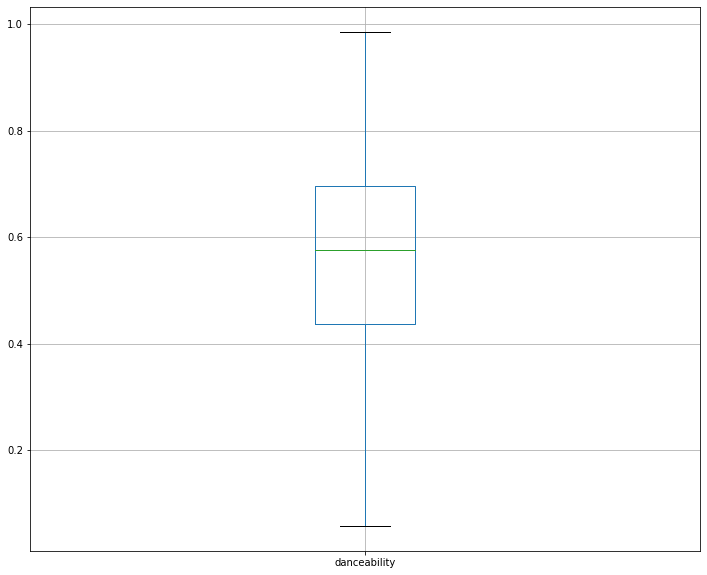

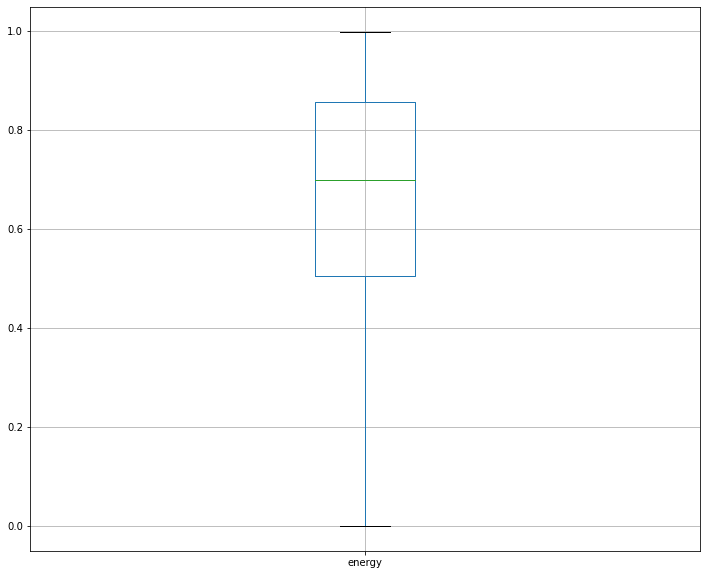

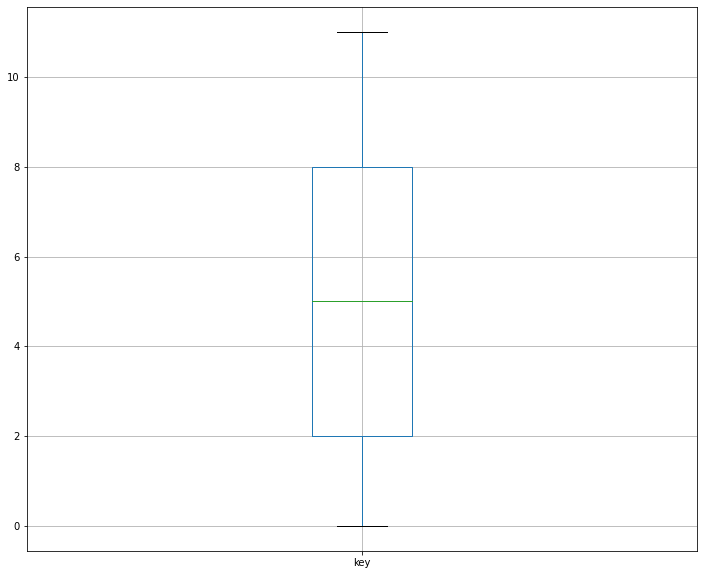

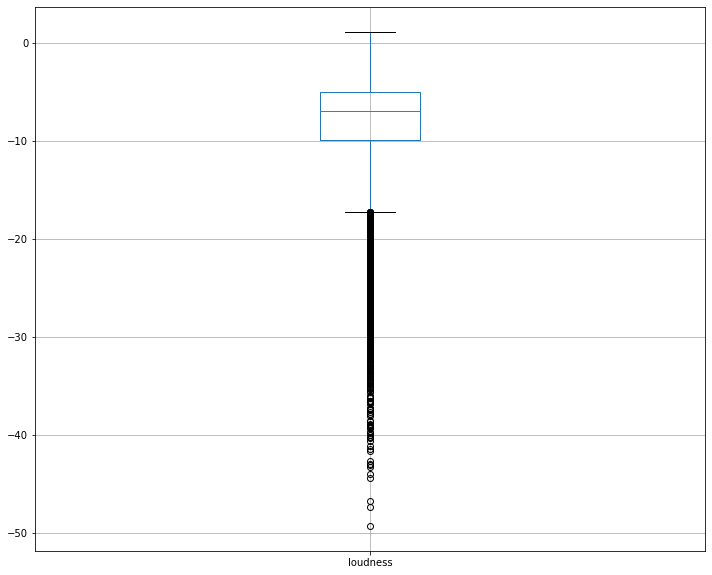

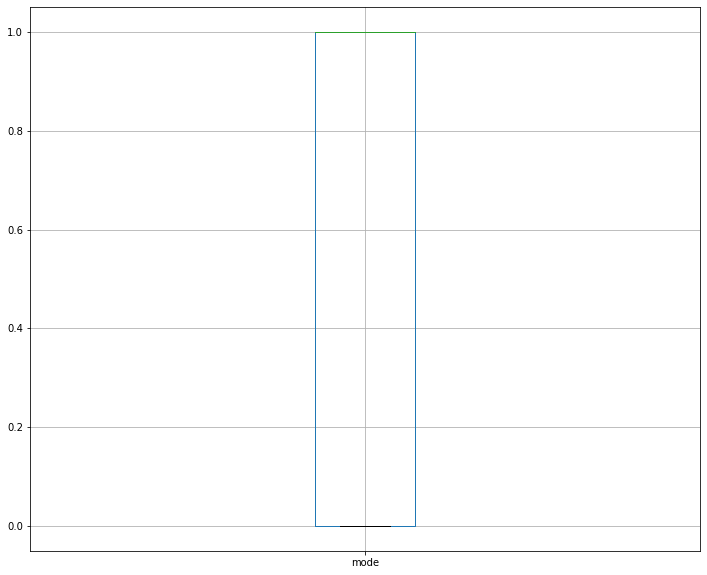

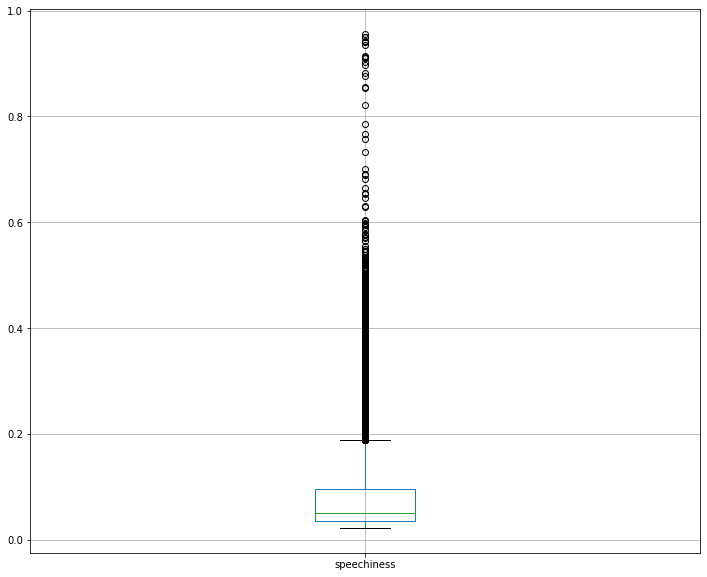

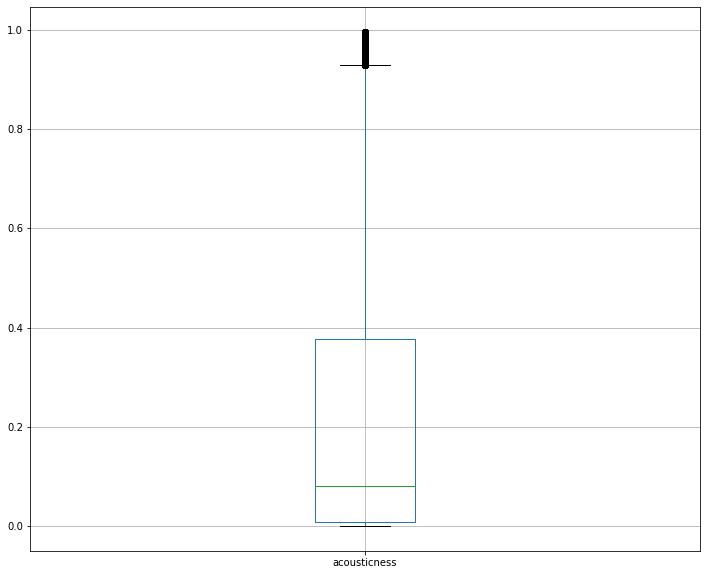

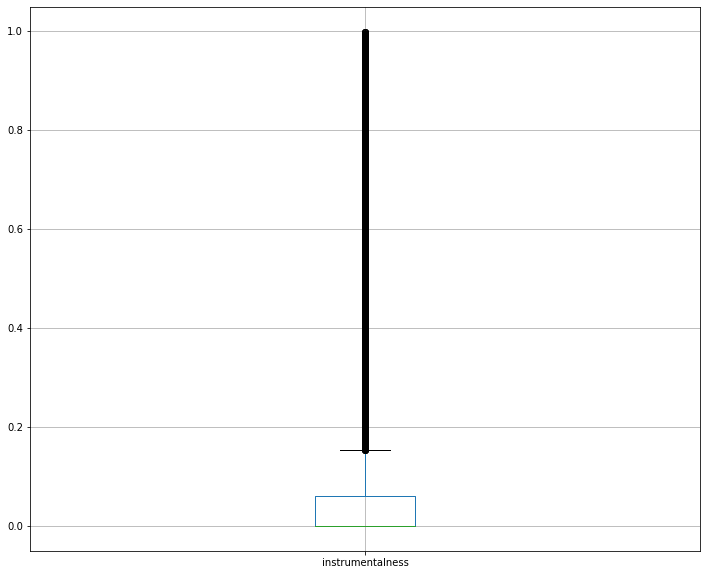

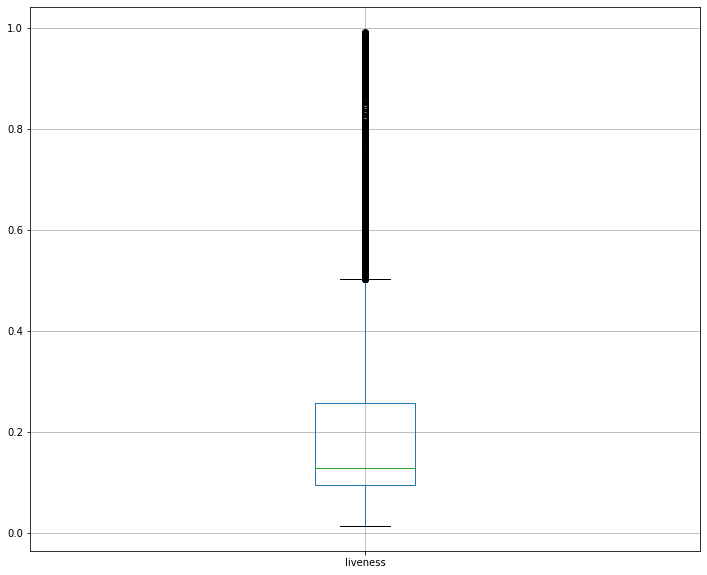

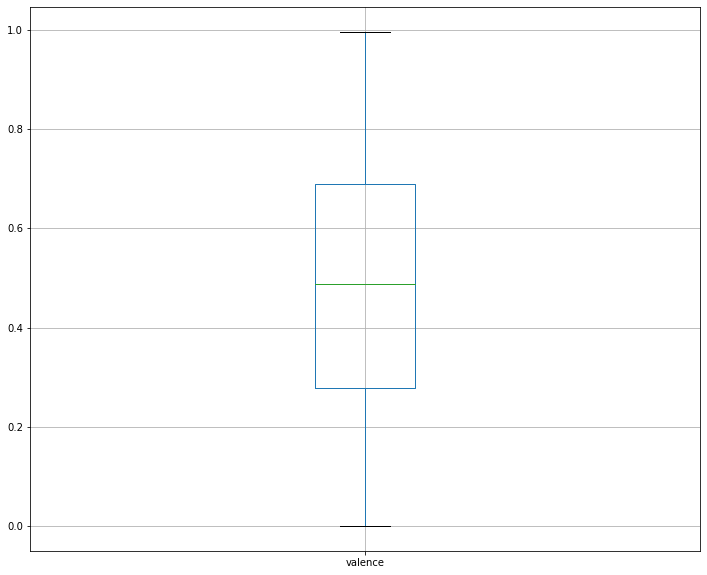

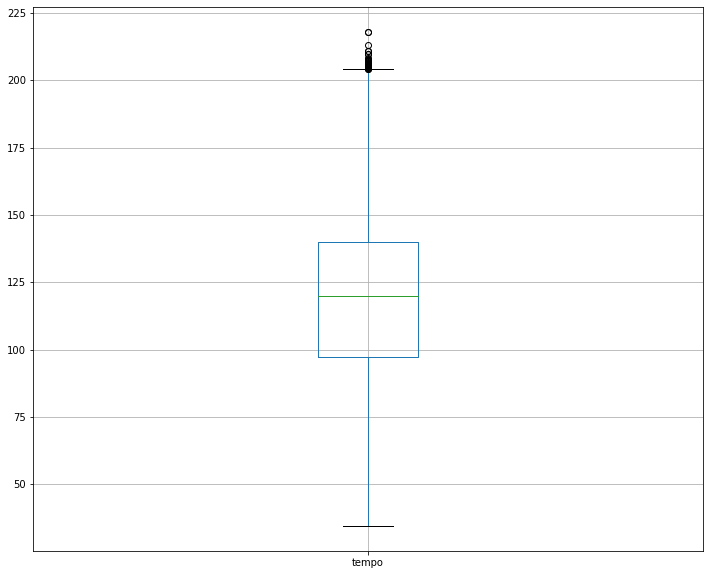

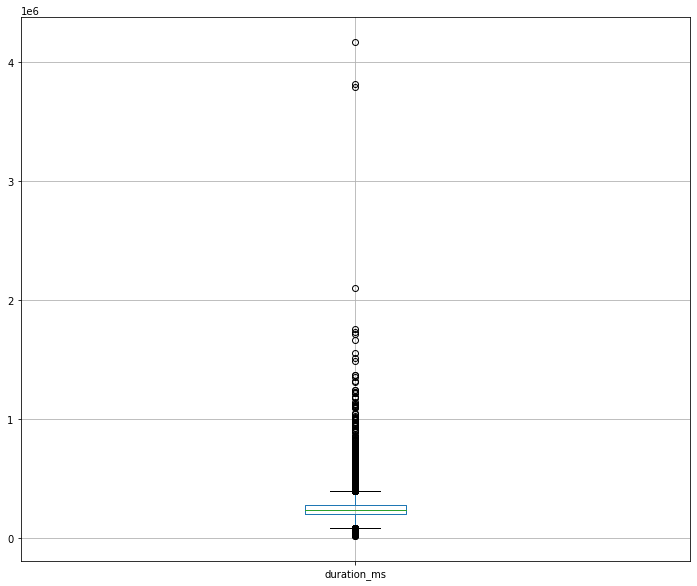

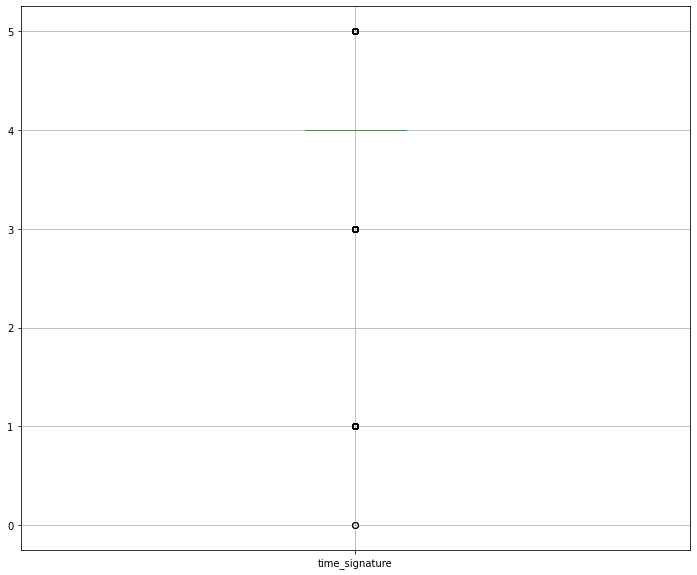

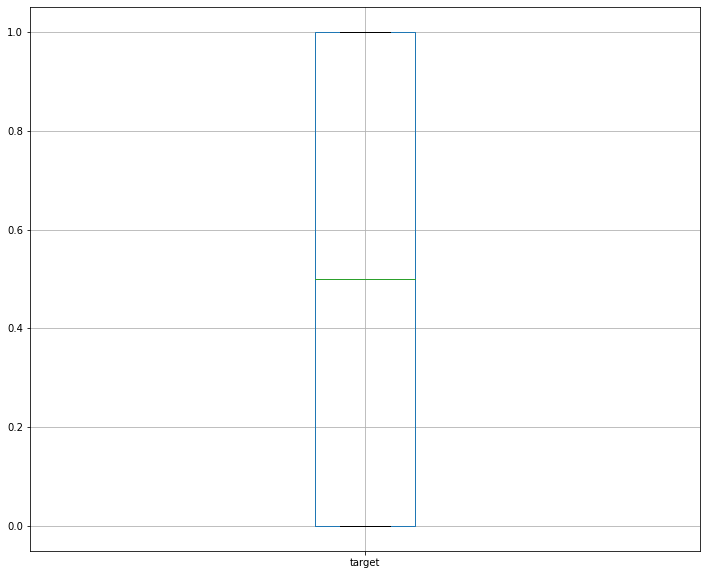

In [12]:
# Use boxplot to describe data and detect outliers
# Create directory if not exist
Path('graphs/features-boxplot').mkdir(parents=True, exist_ok=True) 
for column in df:
    plt.figure(figsize=(12,10))
    df.boxplot([column])
    plt.savefig('graphs/features-boxplot/{}-vanilla.png'.format(column))


In [13]:
# There are too many outliers in features unfortunately, we have to use RobustScaler 
# which does not affect that muchin comparison with StandardScaler and MinMaxScaler

# We have our scaler there, so we can use in the actual program
# Do not worry about fit->transform all of the data at once
df_robust_scaled, robust_scaler_fitted = scale_data_fit_transform(df, 'robust')


In [14]:
# Let's look how df scaled
df_robust_scaled

danceability    energy       key  loudness  mode  speechiness  \
0        -0.192308 -1.090909 -0.666667 -1.815892   0.0    -0.318033   
1         0.619231 -0.451705 -0.666667  0.290190   0.0    -0.316393   
2         0.611538 -0.798295 -0.833333 -0.770018   0.0    -0.334426   
3        -0.046154 -0.301136  0.000000 -1.266435   0.0     0.232787   
4        -0.246154  0.170455 -0.166667 -0.650215   0.0    -0.244262   
...            ...       ...       ...       ...   ...          ...   
6393     -1.557692 -0.971591  0.666667 -1.541675   0.0    -0.265574   
6394      1.280769 -0.948864 -0.666667 -0.625026   0.0     0.716393   
6395      0.546154  0.295455  0.833333  0.475323   0.0    -0.244262   
6396      0.088462 -1.485795  0.333333 -1.877534   0.0     0.093443   
6397     -1.753846 -1.639205 -0.166667 -3.301864  -1.0    -0.100000   

      acousticness  instrumentalness  liveness   valence     tempo  \
0         1.660556          0.112918  0.244798  0.135922 -0.085614   
1         1.296613         -0.000741 -0.482252 -0.432039  0.334075   
2         1.660556          8.048040 -0.288250 -0.538835 -0.604598   
3         1.557348         15.056170  3.347613  0.669903 -0.132122   
4        -0.221578          0.054381  0.152999  1.150485  0.777180   
...            ...               ...       ...       ...       ...   
6393      2.184742         15.706576  1.138311 -1.094417 -1.111465   
6394      0.048888         -0.000741  0.813953  0.614078  0.002498   
6395     -0.185774         -0.000692  0.067319  0.286408  0.002825   
6396      2.464488         14.113080  0.128519  0.177184  0.003549   
6397      2.396589         11.316333 -0.152999 -1.109951 -0.576582   

      duration_ms  time_signature  target  
0       -0.973652             0.0       0  
1        2.011007             0.0       1  
2        0.049715             0.0       0  
3        1.859120             0.0       0  
4        2.573143             0.0       0  
...           ...             ...     ...  
6393    -1.077819             0.0       0  
6394    -1.062904             0.0       1  
6395    -0.074338             0.0       1  
6396    -0.261887             0.0       0  
6397     1.408459             0.0       0  

[17790 rows x 14 columns]

In [15]:
# Before examining the features and their correlations - importances, first divide data as test and train
X_train, X_test, y_train, y_test = train_test_split(df_robust_scaled[df_robust_scaled.columns[:-1]], df_robust_scaled[df_robust_scaled.columns[-1]], test_size=0.2, random_state=42, shuffle=True)

In [16]:
# Concatenate data with target
X_y_train = pd.concat([X_train, y_train], axis=1)
X_y_test = pd.concat([X_train, y_train], axis=1)

In [17]:
# We should just look train data if we want to make feature reduction
X_y_train.corr()

danceability    energy       key  loudness      mode  \
danceability          1.000000  0.083334  0.019378  0.272702 -0.054406   
energy                0.083334  1.000000  0.024795  0.774802 -0.008750   
key                   0.019378  0.024795  1.000000  0.009972 -0.156726   
loudness              0.272702  0.774802  0.009972  1.000000  0.018469   
mode                 -0.054406 -0.008750 -0.156726  0.018469  1.000000   
speechiness           0.184315  0.131819  0.026534  0.112270 -0.074778   
acousticness         -0.199621 -0.735429 -0.026586 -0.644583  0.017208   
instrumentalness     -0.348251 -0.246103 -0.020322 -0.446111 -0.056662   
liveness             -0.106107  0.204484 -0.003459  0.105238 -0.001511   
valence               0.534878  0.291826  0.020101  0.284547  0.001688   
tempo                -0.118417  0.204486 -0.008519  0.165637  0.023888   
duration_ms          -0.120297 -0.087299  0.019250 -0.135544 -0.050484   
time_signature        0.183270  0.177574 -0.005497  0.188292  0.008706   
target                0.430013  0.125074  0.017241  0.331437  0.044128   

                  speechiness  acousticness  instrumentalness  liveness  \
danceability         0.184315     -0.199621         -0.348251 -0.106107   
energy               0.131819     -0.735429         -0.246103  0.204484   
key                  0.026534     -0.026586         -0.020322 -0.003459   
loudness             0.112270     -0.644583         -0.446111  0.105238   
mode                -0.074778      0.017208         -0.056662 -0.001511   
speechiness          1.000000     -0.107801         -0.128964  0.150776   
acousticness        -0.107801      1.000000          0.276885 -0.097120   
instrumentalness    -0.128964      0.276885          1.000000 -0.038687   
liveness             0.150776     -0.097120         -0.038687  1.000000   
valence              0.076859     -0.183293         -0.300973 -0.005376   
tempo                0.041000     -0.155566         -0.035733  0.035496   
duration_ms         -0.025455      0.049213          0.139459 -0.006134   
time_signature       0.043282     -0.186998         -0.114870  0.015148   
target               0.075755     -0.262898         -0.468049 -0.083898   

                   valence     tempo  duration_ms  time_signature    target  
danceability      0.534878 -0.118417    -0.120297        0.183270  0.430013  
energy            0.291826  0.204486    -0.087299        0.177574  0.125074  
key               0.020101 -0.008519     0.019250       -0.005497  0.017241  
loudness          0.284547  0.165637    -0.135544        0.188292  0.331437  
mode              0.001688  0.023888    -0.050484        0.008706  0.044128  
speechiness       0.076859  0.041000    -0.025455        0.043282  0.075755  
acousticness     -0.183293 -0.155566     0.049213       -0.186998 -0.262898  
instrumentalness -0.300973 -0.035733     0.139459       -0.114870 -0.468049  
liveness         -0.005376  0.035496    -0.006134        0.015148 -0.083898  
valence           1.000000  0.039831    -0.182372        0.146792  0.215886  
tempo             0.039831  1.000000    -0.040036        0.008118 -0.015161  
duration_ms      -0.182372 -0.040036     1.000000       -0.025053 -0.091493  
time_signature    0.146792  0.008118    -0.025053        1.000000  0.128436  
target            0.215886 -0.015161    -0.091493        0.128436  1.000000

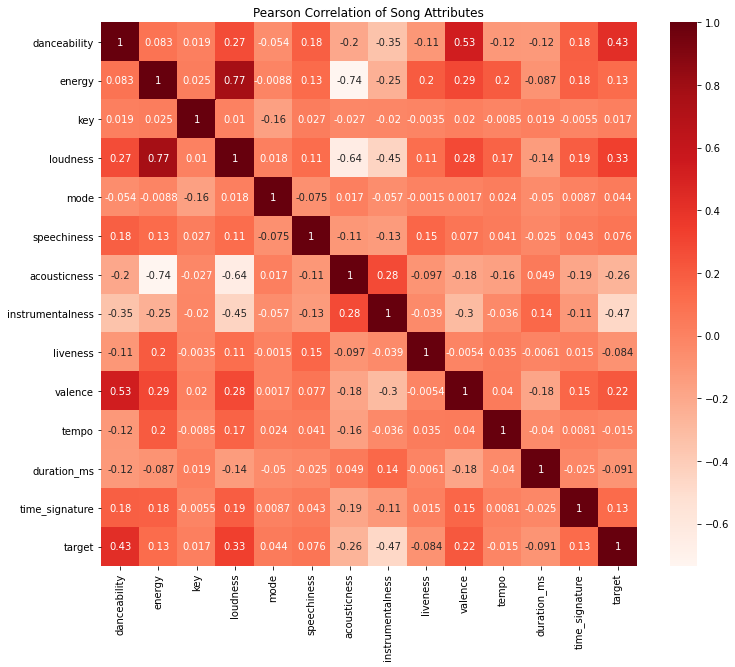

In [18]:
Path('graphs/feature-elimination').mkdir(parents=True, exist_ok=True) 


# Pearson Correlation of song attributes
plt.figure(figsize=(12,10))
sns.heatmap(X_y_train.corr(), annot=True, cmap=plt.cm.Reds).set_title("Pearson Correlation of Song Attributes")
plt.savefig('graphs/feature-elimination/pearson-correlation.png')
plt.show()

In [19]:
"""
As you can see, three most "unrelated" features for target are:

key=0.017
mode=0.044
tempo=-0.015

And the unrelatedness are stronger than others.

"""

'\nAs you can see, three most "unrelated" features for target are:\n\nkey=0.017\nmode=0.044\ntempo=-0.015\n\nAnd the unrelatedness are stronger than others.\n\n'

In [20]:
# We should have feature names
feature_names = list(df_robust_scaled.columns.values)
feature_names.remove('target')
#X = df[feature_names]
#y = df['target']


[ True  True False  True False False  True  True False False False False
 False]
[1 1 6 1 2 9 1 1 5 4 7 8 3]


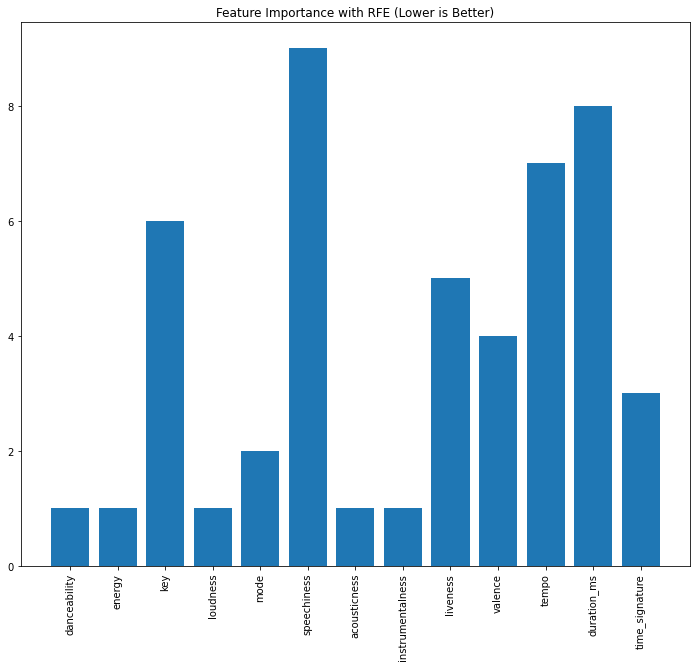

In [21]:
# Check if some features are redundant with Recursive Feature Elimination (RFE)
rfe_clf = RFE(estimator=LogisticRegression(solver = 'liblinear'), n_features_to_select= 5, step=1)
rfe_clf.fit(X_train, y_train)
print(rfe_clf.support_)
print(rfe_clf.ranking_)


Path('graphs/feature-elimination').mkdir(parents=True, exist_ok=True) 
# Plotting
plt.figure(figsize=(12,10))
plt.bar(feature_names, rfe_clf.ranking_)
plt.xticks(rotation='vertical')
plt.title("Feature Importance with RFE (Lower is Better)")
plt.savefig('graphs/feature-elimination/feat_importance_rfe.png')
plt.show()


In [22]:
"""
Most redundant features based on RFE are (ordered):
(More star -> More redundant)

speechiness***
duration_ms***
tempo***

key**
liveness**

"""

'\nMost redundant features based on RFE are (ordered):\n(More star -> More redundant)\n\nspeechiness***\nduration_ms***\ntempo***\n\nkey**\nliveness**\n\n'

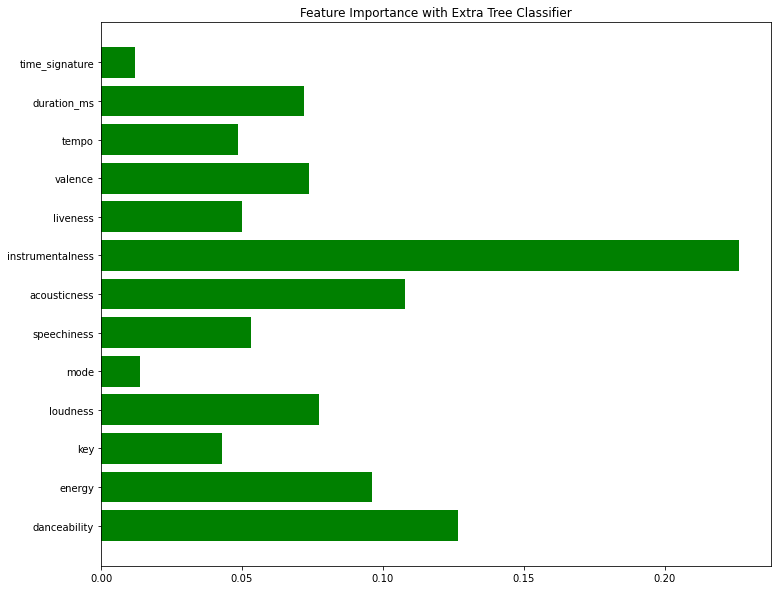

In [23]:
# Check if some features are redundant with Extra Tree Classifier
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=0)
extra_trees_clf.fit(X_train, y_train)

Path('graphs/feature-elimination').mkdir(parents=True, exist_ok=True) 

# Plot
plt.figure(figsize=(12,10))
plt.barh(feature_names, extra_trees_clf.feature_importances_, color='g')
plt.yticks(rotation='horizontal')
plt.title("Feature Importance with Extra Tree Classifier")
plt.savefig('graphs/feature-elimination/feat_importance_extra_tree_classifier.png')
plt.show()


In [24]:
"""
Most redundant features based on Extra Tree Classifier are (ordered):
(More star -> More redundant)

time_signature***
mode***

key**
tempo**
liveness**
speechiness**

"""

'\nMost redundant features based on Extra Tree Classifier are (ordered):\n(More star -> More redundant)\n\ntime_signature***\nmode***\n\nkey**\ntempo**\nliveness**\nspeechiness**\n\n'

In [25]:
"""
We have decided dropping mode, key and tempo as they are strongly unrelated among others
"""

'\nWe have decided dropping mode, key and tempo as they are strongly unrelated among others\n'

In [26]:
df_robust_scaled_dropped_mode_key = df_robust_scaled.drop(columns=['mode', 'key', 'tempo'])
X_train = X_train.drop(columns=['mode', 'key', 'tempo'])
X_test = X_test.drop(columns=['mode', 'key', 'tempo'])

In [27]:
df_robust_scaled_dropped_mode_key

danceability    energy  loudness  speechiness  acousticness  \
0        -0.192308 -1.090909 -1.815892    -0.318033      1.660556   
1         0.619231 -0.451705  0.290190    -0.316393      1.296613   
2         0.611538 -0.798295 -0.770018    -0.334426      1.660556   
3        -0.046154 -0.301136 -1.266435     0.232787      1.557348   
4        -0.246154  0.170455 -0.650215    -0.244262     -0.221578   
...            ...       ...       ...          ...           ...   
6393     -1.557692 -0.971591 -1.541675    -0.265574      2.184742   
6394      1.280769 -0.948864 -0.625026     0.716393      0.048888   
6395      0.546154  0.295455  0.475323    -0.244262     -0.185774   
6396      0.088462 -1.485795 -1.877534     0.093443      2.464488   
6397     -1.753846 -1.639205 -3.301864    -0.100000      2.396589   

      instrumentalness  liveness   valence  duration_ms  time_signature  \
0             0.112918  0.244798  0.135922    -0.973652             0.0   
1            -0.000741 -0.482252 -0.432039     2.011007             0.0   
2             8.048040 -0.288250 -0.538835     0.049715             0.0   
3            15.056170  3.347613  0.669903     1.859120             0.0   
4             0.054381  0.152999  1.150485     2.573143             0.0   
...                ...       ...       ...          ...             ...   
6393         15.706576  1.138311 -1.094417    -1.077819             0.0   
6394         -0.000741  0.813953  0.614078    -1.062904             0.0   
6395         -0.000692  0.067319  0.286408    -0.074338             0.0   
6396         14.113080  0.128519  0.177184    -0.261887             0.0   
6397         11.316333 -0.152999 -1.109951     1.408459             0.0   

      target  
0          0  
1          1  
2          0  
3          0  
4          0  
...      ...  
6393       0  
6394       1  
6395       1  
6396       0  
6397       0  

[17790 rows x 11 columns]

In [28]:
X_train

danceability    energy  loudness  speechiness  acousticness  \
3545      1.057692 -0.019886  0.006553     3.665574     -0.156441   
5176      1.242308 -0.204545  0.548638     3.583607     -0.043456   
751       0.023077 -0.622159 -0.393201    -0.373770      0.495396   
829      -0.211538  0.840909  0.529592     2.222951     -0.221310   
2086      0.115385 -0.633523  0.610895    -0.386885      1.478584   
...            ...       ...       ...          ...           ...   
5764      0.342308  0.528409 -0.162400    -0.311475     -0.220707   
572      -1.480769 -0.718750 -1.702847    -0.096721      2.135854   
5390     -0.276923 -1.153409 -2.084374    -0.281967      1.970178   
860      -0.838462  0.110795 -1.575466    -0.009836     -0.220883   
4403      0.846154 -0.426136  0.560311     3.108197      1.171678   

      instrumentalness  liveness   valence  duration_ms  time_signature  
3545         -0.000741 -0.110159  0.419903     0.004306             0.0  
5176         -0.000741 -0.173195  0.912621     0.037358             0.0  
751          -0.000741 -0.055080 -0.764563     0.313637             0.0  
829          -0.000570  0.758874 -0.847087    -0.598881             0.0  
2086         -0.000741 -0.234394 -0.373786     0.511116             0.0  
...                ...       ...       ...          ...             ...  
5764          7.934219  2.894737  0.890777     1.373893             0.0  
572           1.625276 -0.303550 -0.565534     8.830756             0.0  
5390          1.124463 -0.134639  0.230583     2.447184             0.0  
860          -0.000027  2.870257 -0.191748    -1.239844             0.0  
4403         -0.000741 -0.302326  0.135922    -0.354793             0.0  

[14232 rows x 10 columns]

In [29]:
X_test

danceability    energy  loudness  speechiness  acousticness  \
4331     -0.553846  0.221591  0.455048    -0.218033     -0.198865   
438      -0.934615 -0.221591  0.264387     0.209836      0.002716   
5798      0.653846 -0.420455 -0.559697    -0.319672      1.416117   
3211     -0.123077  0.596591  0.832480     0.139344     -0.221361   
103       0.850000 -0.201705  0.009216     0.378689     -0.208751   
...            ...       ...       ...          ...           ...   
107      -0.276923 -0.255682 -0.023961    -0.095082     -0.203618   
4392     -0.869231  0.357955  0.036043    -0.183607     -0.221460   
1312      0.323077  0.789773  0.785992     0.927869     -0.154540   
3032     -0.157692 -0.335227  0.064100    -0.175410      0.278117   
1797     -0.288462  0.446023  0.399345    -0.168852     -0.216654   

      instrumentalness  liveness   valence  duration_ms  time_signature  
4331         -0.000741  0.214198 -0.655340    -0.314786             0.0  
438          -0.000523 -0.134639 -0.674757    -0.227790             0.0  
5798          0.038609 -0.122399  0.987864    -1.074387             0.0  
3211         -0.000741 -0.218482  0.009709     0.099118             0.0  
103          -0.000388  1.199510 -0.211165     0.664385             0.0  
...                ...       ...       ...          ...             ...  
107          -0.000708 -0.146879 -0.519417    -0.909596             0.0  
4392          0.508202 -0.245410 -0.395631    -0.733556            -1.0  
1312         -0.000741 -0.259486  0.254854    -0.371848             0.0  
3032         -0.000741 -0.116279  0.009709    -0.938511             0.0  
1797          0.461048 -0.302326 -0.822816     2.343669             0.0  

[3558 rows x 10 columns]

In [30]:
# We have changed our direction with just using RobustScaler as it fits better in our case
# You can use this old code block as a template, we did not use on our second iteration
# as this approach is nowhere efficient and "robust" than our newest one -at least in theory-

"""
order_list = ["Standard scaled with no dropping", "Min-Max scaled with no dropping", "Standard scaled with mode and key dropped", "Min-Max scaled with mode and key dropped"]


df_list = [df_standard_scaled, df_minmax_scaled, df_dropped_mode_key_standard_scaled, df_dropped_mode_key_minmax_scaled]
train_test_list = []
for df in df_list:
    X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df[df.columns[-1]], test_size=0.2, random_state=42, shuffle=True)
    train_test_list.append([X_train, X_test, y_train, y_test])
"""
"""
def get_confusion_matrix_of_best(configuration_list, accuracy_scores, predictions, classifiers, X, y, classifier_name, order):
    best_index = accuracy_scores.index(max(accuracy_scores))
    #Vplot_confusion_matrix(classifiers[best_index], X, y)
    labels = ["True Neg","False Pos","False Neg", "True Pos"]
    categories = ["Zero", "One"]
    title = "Confusion Matrix of Classifier {} with Configuration {} For {}".format(classifier_name, configuration_list[best_index], order)
    #print(type(y))
    #print(type(predictions[best_index]))
    cf = confusion_matrix(y, predictions[best_index])
    make_confusion_matrix(cf, figsize=(12,10), group_names=labels, categories=categories, title=title)

for train_test_combination_index in range(len(train_test_list)):
    X_train = train_test_list[train_test_combination_index][0]
    X_test = train_test_list[train_test_combination_index][1]
    y_train = train_test_list[train_test_combination_index][2]
    y_test = train_test_list[train_test_combination_index][3]
    
    print("For {}".format(order_list[train_test_combination_index]))
    
    # SVM
    kernel_list= ["linear", "poly", "rbf", "sigmoid"]
    svm_accuracy_scores = []
    svm_classifiers = []
    svm_predictions = []
    svm_configs = []
    
    for kernel in kernel_list:
        svm_classifier, svm_accuracy_score, svm_y_pred = svm(X_train,X_test,y_train,y_test, kernel=kernel)
        svm_accuracy_scores.append(svm_accuracy_score)
        svm_classifiers.append(svm_classifier)
        svm_predictions.append(svm_y_pred)
        svm_configs.append(kernel)
        
    draw_bar_graph(kernel_list, svm_accuracy_scores, "kernels", "accuracies", "SVM with {}".format(order_list[train_test_combination_index]))
    get_confusion_matrix_of_best(svm_configs, svm_accuracy_scores, svm_predictions, svm_classifiers, X_test, y_test, "SVM", order_list[train_test_combination_index])
    
    # Gaussian NB
    smoothing_list = np.logspace(0,-9, num=100)
    gaussian_nb_accuracy_scores = []
    gaussian_nb_classifiers = []
    gaussian_nb_predictions = []
    gaussian_nb_configs = []


    for smoothing_parameter in smoothing_list:
        gaussian_nb_classifier, gaussian_nb_accuracy_score, gaussian_nb_y_pred = gaussian_nb(X_train,X_test,y_train,y_test,  smoothing_parameter=smoothing_parameter)
        gaussian_nb_accuracy_scores.append(gaussian_nb_accuracy_score)
        gaussian_nb_classifiers.append(gaussian_nb_classifier)
        gaussian_nb_predictions.append(gaussian_nb_y_pred)
        gaussian_nb_configs.append(smoothing_parameter)


    draw_line_graph(k_list, knn_accuracy_scores, "Smoothing parameters", "accuracies", "Gaussian Naive Bayes with {}".format(order_list[train_test_combination_index]))        
    get_confusion_matrix_of_best(gaussian_nb_configs, gaussian_nb_accuracy_scores,gaussian_nb_predictions, gaussian_nb_classifiers, X_test, y_test, "Gaussian Naive Bayes", order_list[train_test_combination_index])
    
    # KNN
    k_list = [num for num in range(500) if num % 2 == 1]
    knn_accuracy_scores = []
    knn_classifiers = []
    knn_predictions = []
    knn_configs = []

    
    for k_neighbor in k_list:
        knn_classifier, knn_accuracy_score, gaussian_nb_y_pred = knn(X_train,X_test,y_train,y_test, neighbors=k_neighbor)
        knn_accuracy_scores.append(knn_accuracy_score)
        knn_classifiers.append(knn_classifier)
        knn_predictions.append(gaussian_nb_y_pred)
        knn_configs.append(k_neighbor)


    draw_line_graph(k_list, knn_accuracy_scores, "k values", "accuracies", "KNN with {}".format(order_list[train_test_combination_index]))
    get_confusion_matrix_of_best(knn_configs, knn_accuracy_scores, knn_predictions, knn_classifiers,  X_test, y_test, "KNN", order_list[train_test_combination_index])
"""   

'\ndef get_confusion_matrix_of_best(configuration_list, accuracy_scores, predictions, classifiers, X, y, classifier_name, order):\n    best_index = accuracy_scores.index(max(accuracy_scores))\n    #Vplot_confusion_matrix(classifiers[best_index], X, y)\n    labels = ["True Neg","False Pos","False Neg", "True Pos"]\n    categories = ["Zero", "One"]\n    title = "Confusion Matrix of Classifier {} with Configuration {} For {}".format(classifier_name, configuration_list[best_index], order)\n    #print(type(y))\n    #print(type(predictions[best_index]))\n    cf = confusion_matrix(y, predictions[best_index])\n    make_confusion_matrix(cf, figsize=(12,10), group_names=labels, categories=categories, title=title)\n\nfor train_test_combination_index in range(len(train_test_list)):\n    X_train = train_test_list[train_test_combination_index][0]\n    X_test = train_test_list[train_test_combination_index][1]\n    y_train = train_test_list[train_test_combination_index][2]\n    y_test = train_test_lis

--- SUPPORT VECTOR MACHINE WITH KERNEL linear---

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.86      0.70      0.77      1826
           1       0.73      0.88      0.80      1732

    accuracy                           0.79      3558
   macro avg       0.80      0.79      0.79      3558
weighted avg       0.80      0.79      0.79      3558


--- Confusion Matrix ---
[[1271  555]
 [ 202 1530]]
True Negative : 1271
False Positive : 555
False Negative : 202
True Positive :  1530
Sensitivity :  0.8833718244803695
Specificity :  0.6960569550930996
Precision :  0.7338129496402878
Negative predictive value :  0.8628649015614392
False positive rate :  0.30394304490690033
False negative rate :  0.11662817551963048
False discovery rate :  0.26618705035971224
Accuracy :  0.7872400224845418

--- SUPPORT VECTOR MACHINE WITH KERNEL poly---

--- Classification Report ---
              precision    recall  f1-score   support

           0

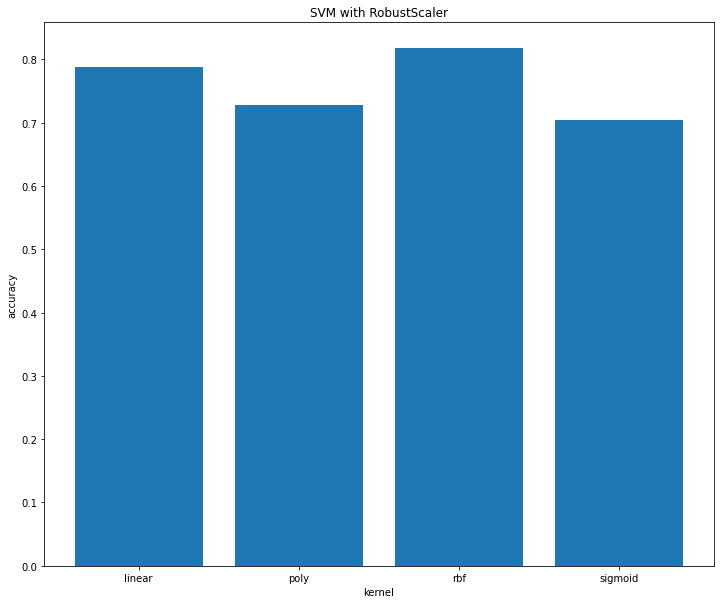

--- GAUSSIAN NAIVE BAYES WITH SMOOTHING 1.0 ---

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.97      0.37      0.53      1826
           1       0.60      0.99      0.74      1732

    accuracy                           0.67      3558
   macro avg       0.78      0.68      0.64      3558
weighted avg       0.79      0.67      0.64      3558


--- Confusion Matrix ---
[[ 674 1152]
 [  20 1712]]
True Negative : 674
False Positive : 1152
False Negative : 20
True Positive :  1712
Sensitivity :  0.9884526558891455
Specificity :  0.36911281489594744
Precision :  0.5977653631284916
Negative predictive value :  0.9711815561959655
False positive rate :  0.6308871851040526
False negative rate :  0.011547344110854504
False discovery rate :  0.4022346368715084
Accuracy :  0.670601461495222

--- GAUSSIAN NAIVE BAYES WITH SMOOTHING 0.8111308307896871 ---

--- Classification Report ---
              precision    recall  f1-score   support


True Negative : 785
False Positive : 1041
False Negative : 34
True Positive :  1698
Sensitivity :  0.9803695150115473
Specificity :  0.4299014238773275
Precision :  0.619934282584885
Negative predictive value :  0.9584859584859585
False positive rate :  0.5700985761226726
False negative rate :  0.019630484988452657
False discovery rate :  0.380065717415115
Accuracy :  0.6978639685216413

--- GAUSSIAN NAIVE BAYES WITH SMOOTHING 0.03511191734215131 ---

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.96      0.44      0.61      1826
           1       0.63      0.98      0.76      1732

    accuracy                           0.70      3558
   macro avg       0.79      0.71      0.68      3558
weighted avg       0.80      0.70      0.68      3558


--- Confusion Matrix ---
[[ 810 1016]
 [  36 1696]]
True Negative : 810
False Positive : 1016
False Negative : 36
True Positive :  1696
Sensitivity :  0.9792147806004619
Specificity :  0

[[1041  785]
 [ 122 1610]]
True Negative : 1041
False Positive : 785
False Negative : 122
True Positive :  1610
Sensitivity :  0.9295612009237876
Specificity :  0.5700985761226726
Precision :  0.6722338204592901
Negative predictive value :  0.8950988822012038
False positive rate :  0.4299014238773275
False negative rate :  0.07043879907621248
False discovery rate :  0.3277661795407098
Accuracy :  0.7450815064643058

--- GAUSSIAN NAIVE BAYES WITH SMOOTHING 0.0012328467394420659 ---

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.89      0.58      0.70      1826
           1       0.67      0.93      0.78      1732

    accuracy                           0.75      3558
   macro avg       0.78      0.75      0.74      3558
weighted avg       0.79      0.75      0.74      3558


--- Confusion Matrix ---
[[1053  773]
 [ 128 1604]]
True Negative : 1053
False Positive : 773
False Negative : 128
True Positive :  1604
Sensitivity :  0.9

              precision    recall  f1-score   support

           0       0.87      0.60      0.71      1826
           1       0.68      0.91      0.78      1732

    accuracy                           0.75      3558
   macro avg       0.78      0.75      0.74      3558
weighted avg       0.78      0.75      0.74      3558


--- Confusion Matrix ---
[[1090  736]
 [ 156 1576]]
True Negative : 1090
False Positive : 736
False Negative : 156
True Positive :  1576
Sensitivity :  0.9099307159353349
Specificity :  0.5969331872946331
Precision :  0.6816608996539792
Negative predictive value :  0.8747993579454254
False positive rate :  0.40306681270536693
False negative rate :  0.09006928406466513
False discovery rate :  0.31833910034602075
Accuracy :  0.7492973580663294

--- GAUSSIAN NAIVE BAYES WITH SMOOTHING 4.328761281083062e-05 ---

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.87      0.60      0.71      1826
           1       


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.87      0.60      0.71      1826
           1       0.68      0.91      0.78      1732

    accuracy                           0.75      3558
   macro avg       0.78      0.75      0.74      3558
weighted avg       0.78      0.75      0.74      3558


--- Confusion Matrix ---
[[1092  734]
 [ 158 1574]]
True Negative : 1092
False Positive : 734
False Negative : 158
True Positive :  1574
Sensitivity :  0.9087759815242494
Specificity :  0.5980284775465499
Precision :  0.6819757365684576
Negative predictive value :  0.8736
False positive rate :  0.4019715224534502
False negative rate :  0.09122401847575058
False discovery rate :  0.31802426343154244
Accuracy :  0.7492973580663294

--- GAUSSIAN NAIVE BAYES WITH SMOOTHING 1.519911082952933e-06 ---

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.87      0.60      0.71      1826
 

[[1092  734]
 [ 158 1574]]
True Negative : 1092
False Positive : 734
False Negative : 158
True Positive :  1574
Sensitivity :  0.9087759815242494
Specificity :  0.5980284775465499
Precision :  0.6819757365684576
Negative predictive value :  0.8736
False positive rate :  0.4019715224534502
False negative rate :  0.09122401847575058
False discovery rate :  0.31802426343154244
Accuracy :  0.7492973580663294

--- GAUSSIAN NAIVE BAYES WITH SMOOTHING 6.579332246575682e-08 ---

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.87      0.60      0.71      1826
           1       0.68      0.91      0.78      1732

    accuracy                           0.75      3558
   macro avg       0.78      0.75      0.74      3558
weighted avg       0.78      0.75      0.74      3558


--- Confusion Matrix ---
[[1092  734]
 [ 158 1574]]
True Negative : 1092
False Positive : 734
False Negative : 158
True Positive :  1574
Sensitivity :  0.908775981524

              precision    recall  f1-score   support

           0       0.87      0.60      0.71      1826
           1       0.68      0.91      0.78      1732

    accuracy                           0.75      3558
   macro avg       0.78      0.75      0.74      3558
weighted avg       0.78      0.75      0.74      3558


--- Confusion Matrix ---
[[1092  734]
 [ 158 1574]]
True Negative : 1092
False Positive : 734
False Negative : 158
True Positive :  1574
Sensitivity :  0.9087759815242494
Specificity :  0.5980284775465499
Precision :  0.6819757365684576
Negative predictive value :  0.8736
False positive rate :  0.4019715224534502
False negative rate :  0.09122401847575058
False discovery rate :  0.31802426343154244
Accuracy :  0.7492973580663294

--- GAUSSIAN NAIVE BAYES WITH SMOOTHING 2.310129700083158e-09 ---

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.87      0.60      0.71      1826
           1       0.68      0.9

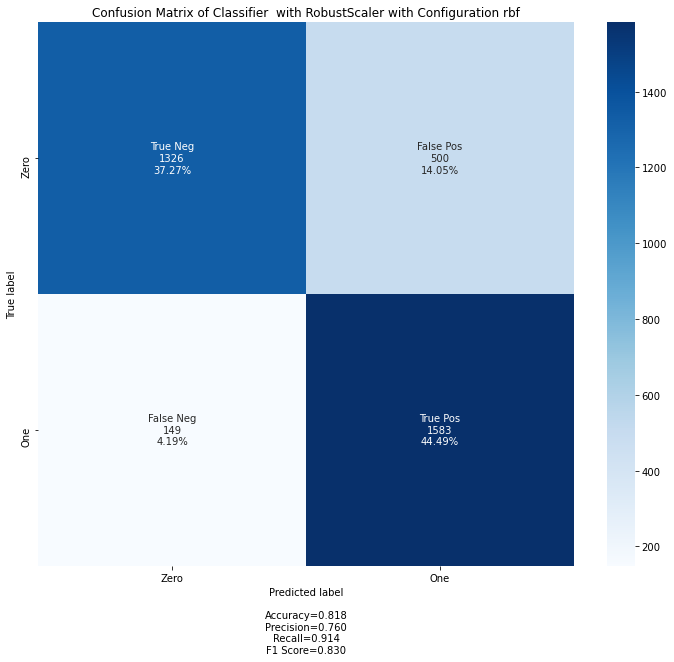

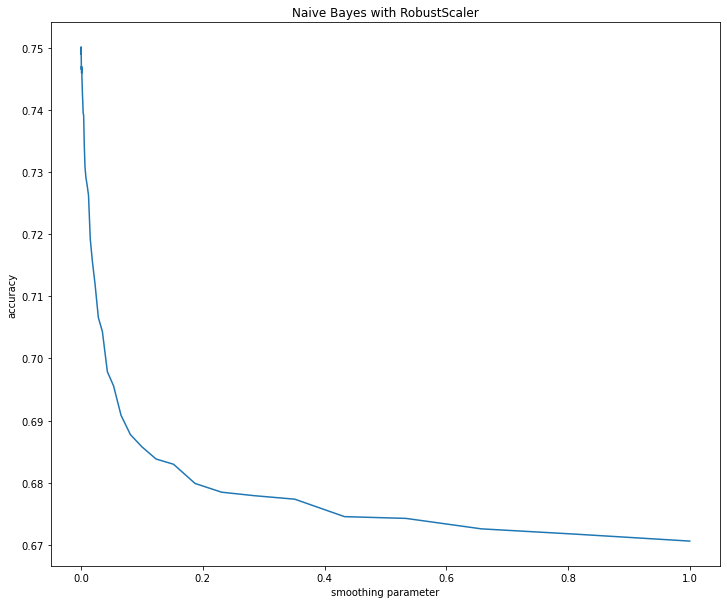

--- KNN, neighbors=1 ---

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.79      0.74      0.76      1826
           1       0.74      0.79      0.77      1732

    accuracy                           0.77      3558
   macro avg       0.77      0.77      0.77      3558
weighted avg       0.77      0.77      0.77      3558


--- Confusion Matrix ---
[[1351  475]
 [ 357 1375]]
True Negative : 1351
False Positive : 475
False Negative : 357
True Positive :  1375
Sensitivity :  0.7938799076212472
Specificity :  0.73986856516977
Precision :  0.7432432432432432
Negative predictive value :  0.7909836065573771
False positive rate :  0.26013143483023
False negative rate :  0.2061200923787529
False discovery rate :  0.25675675675675674
Accuracy :  0.7661607644744238

--- KNN, neighbors=3 ---

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.83      0.73      0.78      1826
          


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1826
           1       0.75      0.91      0.83      1732

    accuracy                           0.81      3558
   macro avg       0.83      0.81      0.81      3558
weighted avg       0.83      0.81      0.81      3558


--- Confusion Matrix ---
[[1308  518]
 [ 150 1582]]
True Negative : 1308
False Positive : 518
False Negative : 150
True Positive :  1582
Sensitivity :  0.9133949191685913
Specificity :  0.7163198247535597
Precision :  0.7533333333333333
Negative predictive value :  0.897119341563786
False positive rate :  0.2836801752464403
False negative rate :  0.08660508083140878
False discovery rate :  0.24666666666666667
Accuracy :  0.8122540753232153

--- KNN, neighbors=23 ---

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.90      0.71      0.79      1826
           1       0.75      0


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.90      0.71      0.79      1826
           1       0.75      0.92      0.83      1732

    accuracy                           0.81      3558
   macro avg       0.83      0.81      0.81      3558
weighted avg       0.83      0.81      0.81      3558


--- Confusion Matrix ---
[[1289  537]
 [ 136 1596]]
True Negative : 1289
False Positive : 537
False Negative : 136
True Positive :  1596
Sensitivity :  0.9214780600461894
Specificity :  0.7059145673603505
Precision :  0.7482419127988749
Negative predictive value :  0.9045614035087719
False positive rate :  0.2940854326396495
False negative rate :  0.07852193995381063
False discovery rate :  0.2517580872011252
Accuracy :  0.8108487914558741

--- KNN, neighbors=43 ---

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1826
           1       0.75      0


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.92      0.70      0.80      1826
           1       0.75      0.93      0.83      1732

    accuracy                           0.82      3558
   macro avg       0.83      0.82      0.81      3558
weighted avg       0.84      0.82      0.81      3558


--- Confusion Matrix ---
[[1284  542]
 [ 116 1616]]
True Negative : 1284
False Positive : 542
False Negative : 116
True Positive :  1616
Sensitivity :  0.9330254041570438
Specificity :  0.7031763417305587
Precision :  0.7488415199258572
Negative predictive value :  0.9171428571428571
False positive rate :  0.2968236582694414
False negative rate :  0.06697459584295612
False discovery rate :  0.2511584800741427
Accuracy :  0.8150646430578977

--- KNN, neighbors=63 ---

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.92      0.70      0.79      1826
           1       0.75      0


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.92      0.69      0.79      1826
           1       0.74      0.94      0.83      1732

    accuracy                           0.81      3558
   macro avg       0.83      0.81      0.81      3558
weighted avg       0.83      0.81      0.81      3558


--- Confusion Matrix ---
[[1259  567]
 [ 109 1623]]
True Negative : 1259
False Positive : 567
False Negative : 109
True Positive :  1623
Sensitivity :  0.937066974595843
Specificity :  0.6894852135815991
Precision :  0.7410958904109589
Negative predictive value :  0.9203216374269005
False positive rate :  0.31051478641840086
False negative rate :  0.06293302540415704
False discovery rate :  0.2589041095890411
Accuracy :  0.8100056211354694

--- KNN, neighbors=83 ---

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.92      0.69      0.79      1826
           1       0.74      0


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.92      0.69      0.79      1826
           1       0.74      0.94      0.83      1732

    accuracy                           0.81      3558
   macro avg       0.83      0.81      0.81      3558
weighted avg       0.83      0.81      0.81      3558


--- Confusion Matrix ---
[[1257  569]
 [ 106 1626]]
True Negative : 1257
False Positive : 569
False Negative : 106
True Positive :  1626
Sensitivity :  0.9387990762124712
Specificity :  0.6883899233296824
Precision :  0.7407744874715262
Negative predictive value :  0.9222303741746148
False positive rate :  0.31161007667031765
False negative rate :  0.061200923787528866
False discovery rate :  0.2592255125284738
Accuracy :  0.8102866779089376

--- KNN, neighbors=103 ---

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.92      0.69      0.79      1826
           1       0.74    


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.92      0.68      0.78      1826
           1       0.73      0.94      0.82      1732

    accuracy                           0.81      3558
   macro avg       0.83      0.81      0.80      3558
weighted avg       0.83      0.81      0.80      3558


--- Confusion Matrix ---
[[1239  587]
 [ 106 1626]]
True Negative : 1239
False Positive : 587
False Negative : 106
True Positive :  1626
Sensitivity :  0.9387990762124712
Specificity :  0.6785323110624315
Precision :  0.7347492092182558
Negative predictive value :  0.9211895910780669
False positive rate :  0.32146768893756844
False negative rate :  0.061200923787528866
False discovery rate :  0.26525079078174424
Accuracy :  0.8052276559865092

--- KNN, neighbors=123 ---

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.92      0.68      0.78      1826
           1       0.73   


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.92      0.67      0.78      1826
           1       0.73      0.94      0.82      1732

    accuracy                           0.80      3558
   macro avg       0.83      0.81      0.80      3558
weighted avg       0.83      0.80      0.80      3558


--- Confusion Matrix ---
[[1232  594]
 [ 107 1625]]
True Negative : 1232
False Positive : 594
False Negative : 107
True Positive :  1625
Sensitivity :  0.9382217090069284
Specificity :  0.6746987951807228
Precision :  0.7323118521856692
Negative predictive value :  0.9200896191187453
False positive rate :  0.3253012048192771
False negative rate :  0.0617782909930716
False discovery rate :  0.26768814781433076
Accuracy :  0.8029792017987634

--- KNN, neighbors=143 ---

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.92      0.67      0.78      1826
           1       0.73      


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.92      0.67      0.77      1826
           1       0.73      0.94      0.82      1732

    accuracy                           0.80      3558
   macro avg       0.82      0.80      0.80      3558
weighted avg       0.83      0.80      0.80      3558


--- Confusion Matrix ---
[[1217  609]
 [ 103 1629]]
True Negative : 1217
False Positive : 609
False Negative : 103
True Positive :  1629
Sensitivity :  0.9405311778290993
Specificity :  0.6664841182913472
Precision :  0.7278820375335121
Negative predictive value :  0.921969696969697
False positive rate :  0.3335158817086528
False negative rate :  0.059468822170900694
False discovery rate :  0.27211796246648795
Accuracy :  0.7998875772906127

--- KNN, neighbors=163 ---

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.92      0.67      0.77      1826
           1       0.73     


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.66      0.77      1826
           1       0.73      0.94      0.82      1732

    accuracy                           0.80      3558
   macro avg       0.83      0.80      0.80      3558
weighted avg       0.83      0.80      0.80      3558


--- Confusion Matrix ---
[[1214  612]
 [  98 1634]]
True Negative : 1214
False Positive : 612
False Negative : 98
True Positive :  1634
Sensitivity :  0.9434180138568129
Specificity :  0.664841182913472
Precision :  0.7275155832591274
Negative predictive value :  0.9253048780487805
False positive rate :  0.33515881708652795
False negative rate :  0.05658198614318707
False discovery rate :  0.27248441674087265
Accuracy :  0.8004496908375491

--- KNN, neighbors=183 ---

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.66      0.77      1826
           1       0.73      


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.66      0.77      1826
           1       0.72      0.94      0.82      1732

    accuracy                           0.80      3558
   macro avg       0.82      0.80      0.79      3558
weighted avg       0.83      0.80      0.79      3558


--- Confusion Matrix ---
[[1202  624]
 [  97 1635]]
True Negative : 1202
False Positive : 624
False Negative : 97
True Positive :  1635
Sensitivity :  0.9439953810623557
Specificity :  0.6582694414019715
Precision :  0.7237715803452855
Negative predictive value :  0.9253271747498075
False positive rate :  0.3417305585980285
False negative rate :  0.05600461893764434
False discovery rate :  0.27622841965471445
Accuracy :  0.7973580663293985

--- KNN, neighbors=203 ---

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.66      0.77      1826
           1       0.72      


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.65      0.77      1826
           1       0.72      0.94      0.82      1732

    accuracy                           0.80      3558
   macro avg       0.82      0.80      0.79      3558
weighted avg       0.83      0.80      0.79      3558


--- Confusion Matrix ---
[[1193  633]
 [  96 1636]]
True Negative : 1193
False Positive : 633
False Negative : 96
True Positive :  1636
Sensitivity :  0.9445727482678984
Specificity :  0.6533406352683461
Precision :  0.7210224768620538
Negative predictive value :  0.9255236617532971
False positive rate :  0.3466593647316539
False negative rate :  0.05542725173210162
False discovery rate :  0.2789775231379462
Accuracy :  0.7951096121416527

--- KNN, neighbors=223 ---

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.65      0.77      1826
           1       0.72      0


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.65      0.76      1826
           1       0.72      0.95      0.82      1732

    accuracy                           0.79      3558
   macro avg       0.82      0.80      0.79      3558
weighted avg       0.83      0.79      0.79      3558


--- Confusion Matrix ---
[[1188  638]
 [  92 1640]]
True Negative : 1188
False Positive : 638
False Negative : 92
True Positive :  1640
Sensitivity :  0.9468822170900693
Specificity :  0.6506024096385542
Precision :  0.7199297629499561
Negative predictive value :  0.928125
False positive rate :  0.3493975903614458
False negative rate :  0.053117782909930716
False discovery rate :  0.2800702370500439
Accuracy :  0.7948285553681844

--- KNN, neighbors=243 ---

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.65      0.77      1826
           1       0.72      0.95      


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.65      0.76      1826
           1       0.72      0.95      0.82      1732

    accuracy                           0.79      3558
   macro avg       0.82      0.80      0.79      3558
weighted avg       0.83      0.79      0.79      3558


--- Confusion Matrix ---
[[1181  645]
 [  91 1641]]
True Negative : 1181
False Positive : 645
False Negative : 91
True Positive :  1641
Sensitivity :  0.9474595842956121
Specificity :  0.6467688937568455
Precision :  0.7178477690288714
Negative predictive value :  0.9284591194968553
False positive rate :  0.35323110624315446
False negative rate :  0.05254041570438799
False discovery rate :  0.2821522309711286
Accuracy :  0.7931422147273749

--- KNN, neighbors=263 ---

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.65      0.76      1826
           1       0.72      


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.64      0.76      1826
           1       0.71      0.95      0.81      1732

    accuracy                           0.79      3558
   macro avg       0.82      0.79      0.79      3558
weighted avg       0.82      0.79      0.78      3558


--- Confusion Matrix ---
[[1167  659]
 [  91 1641]]
True Negative : 1167
False Positive : 659
False Negative : 91
True Positive :  1641
Sensitivity :  0.9474595842956121
Specificity :  0.6391018619934282
Precision :  0.7134782608695652
Negative predictive value :  0.9276629570747218
False positive rate :  0.3608981380065717
False negative rate :  0.05254041570438799
False discovery rate :  0.28652173913043477
Accuracy :  0.7892074198988196

--- KNN, neighbors=283 ---

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.64      0.76      1826
           1       0.71      


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.63      0.75      1826
           1       0.71      0.95      0.81      1732

    accuracy                           0.79      3558
   macro avg       0.82      0.79      0.78      3558
weighted avg       0.82      0.79      0.78      3558


--- Confusion Matrix ---
[[1157  669]
 [  90 1642]]
True Negative : 1157
False Positive : 669
False Negative : 90
True Positive :  1642
Sensitivity :  0.9480369515011547
Specificity :  0.6336254107338445
Precision :  0.7105149286023367
Negative predictive value :  0.9278267842822775
False positive rate :  0.3663745892661555
False negative rate :  0.05196304849884527
False discovery rate :  0.28948507139766333
Accuracy :  0.7866779089376054

--- KNN, neighbors=303 ---

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.63      0.75      1826
           1       0.71      


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.63      0.75      1826
           1       0.71      0.95      0.81      1732

    accuracy                           0.78      3558
   macro avg       0.82      0.79      0.78      3558
weighted avg       0.82      0.78      0.78      3558


--- Confusion Matrix ---
[[1147  679]
 [  90 1642]]
True Negative : 1147
False Positive : 679
False Negative : 90
True Positive :  1642
Sensitivity :  0.9480369515011547
Specificity :  0.6281489594742606
Precision :  0.7074536837570012
Negative predictive value :  0.9272433306386418
False positive rate :  0.3718510405257393
False negative rate :  0.05196304849884527
False discovery rate :  0.2925463162429987
Accuracy :  0.783867341202923

--- KNN, neighbors=323 ---

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.63      0.75      1826
           1       0.71      0.


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.63      0.75      1826
           1       0.71      0.95      0.81      1732

    accuracy                           0.78      3558
   macro avg       0.82      0.79      0.78      3558
weighted avg       0.82      0.78      0.78      3558


--- Confusion Matrix ---
[[1145  681]
 [  87 1645]]
True Negative : 1145
False Positive : 681
False Negative : 87
True Positive :  1645
Sensitivity :  0.9497690531177829
Specificity :  0.627053669222344
Precision :  0.7072226999140154
Negative predictive value :  0.9293831168831169
False positive rate :  0.3729463307776561
False negative rate :  0.05023094688221709
False discovery rate :  0.2927773000859845
Accuracy :  0.7841483979763912

--- KNN, neighbors=343 ---

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.63      0.75      1826
           1       0.71      0.


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.62      0.75      1826
           1       0.71      0.95      0.81      1732

    accuracy                           0.78      3558
   macro avg       0.82      0.79      0.78      3558
weighted avg       0.82      0.78      0.78      3558


--- Confusion Matrix ---
[[1140  686]
 [  83 1649]]
True Negative : 1140
False Positive : 686
False Negative : 83
True Positive :  1649
Sensitivity :  0.9520785219399538
Specificity :  0.624315443592552
Precision :  0.7062098501070664
Negative predictive value :  0.9321340964840557
False positive rate :  0.37568455640744797
False negative rate :  0.04792147806004619
False discovery rate :  0.2937901498929336
Accuracy :  0.783867341202923

--- KNN, neighbors=363 ---

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.63      0.75      1826
           1       0.71      0.


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.62      0.74      1826
           1       0.70      0.95      0.81      1732

    accuracy                           0.78      3558
   macro avg       0.82      0.79      0.78      3558
weighted avg       0.82      0.78      0.78      3558


--- Confusion Matrix ---
[[1132  694]
 [  86 1646]]
True Negative : 1132
False Positive : 694
False Negative : 86
True Positive :  1646
Sensitivity :  0.9503464203233256
Specificity :  0.619934282584885
Precision :  0.7034188034188035
Negative predictive value :  0.9293924466338259
False positive rate :  0.380065717415115
False negative rate :  0.049653579676674366
False discovery rate :  0.2965811965811966
Accuracy :  0.7807757166947723

--- KNN, neighbors=383 ---

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.62      0.74      1826
           1       0.70      0.


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.62      0.74      1826
           1       0.70      0.95      0.81      1732

    accuracy                           0.78      3558
   macro avg       0.82      0.78      0.78      3558
weighted avg       0.82      0.78      0.77      3558


--- Confusion Matrix ---
[[1130  696]
 [  85 1647]]
True Negative : 1130
False Positive : 696
False Negative : 85
True Positive :  1647
Sensitivity :  0.9509237875288684
Specificity :  0.6188389923329682
Precision :  0.7029449423815621
Negative predictive value :  0.9300411522633745
False positive rate :  0.38116100766703176
False negative rate :  0.04907621247113164
False discovery rate :  0.2970550576184379
Accuracy :  0.7804946599213041

--- KNN, neighbors=403 ---

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.62      0.74      1826
           1       0.70      


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.61      0.74      1826
           1       0.70      0.95      0.81      1732

    accuracy                           0.78      3558
   macro avg       0.82      0.78      0.77      3558
weighted avg       0.82      0.78      0.77      3558


--- Confusion Matrix ---
[[1118  708]
 [  83 1649]]
True Negative : 1118
False Positive : 708
False Negative : 83
True Positive :  1649
Sensitivity :  0.9520785219399538
Specificity :  0.6122672508214677
Precision :  0.6996181586762834
Negative predictive value :  0.9308909242298085
False positive rate :  0.3877327491785323
False negative rate :  0.04792147806004619
False discovery rate :  0.3003818413237166
Accuracy :  0.7776840921866217

--- KNN, neighbors=423 ---

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.61      0.74      1826
           1       0.70      0


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.61      0.74      1826
           1       0.70      0.95      0.81      1732

    accuracy                           0.78      3558
   macro avg       0.82      0.78      0.77      3558
weighted avg       0.82      0.78      0.77      3558


--- Confusion Matrix ---
[[1120  706]
 [  84 1648]]
True Negative : 1120
False Positive : 706
False Negative : 84
True Positive :  1648
Sensitivity :  0.9515011547344111
Specificity :  0.6133625410733844
Precision :  0.7000849617672048
Negative predictive value :  0.9302325581395349
False positive rate :  0.38663745892661555
False negative rate :  0.04849884526558892
False discovery rate :  0.29991503823279525
Accuracy :  0.77796514896009

--- KNN, neighbors=443 ---

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.61      0.74      1826
           1       0.70      0


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.61      0.74      1826
           1       0.70      0.95      0.81      1732

    accuracy                           0.78      3558
   macro avg       0.82      0.78      0.77      3558
weighted avg       0.82      0.78      0.77      3558


--- Confusion Matrix ---
[[1117  709]
 [  81 1651]]
True Negative : 1117
False Positive : 709
False Negative : 81
True Positive :  1651
Sensitivity :  0.9532332563510393
Specificity :  0.6117196056955093
Precision :  0.6995762711864407
Negative predictive value :  0.9323873121869783
False positive rate :  0.3882803943044907
False negative rate :  0.04676674364896074
False discovery rate :  0.30042372881355933
Accuracy :  0.77796514896009

--- KNN, neighbors=463 ---

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.61      0.74      1826
           1       0.70      0.


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.61      0.74      1826
           1       0.70      0.95      0.81      1732

    accuracy                           0.78      3558
   macro avg       0.82      0.78      0.77      3558
weighted avg       0.82      0.78      0.77      3558


--- Confusion Matrix ---
[[1115  711]
 [  78 1654]]
True Negative : 1115
False Positive : 711
False Negative : 78
True Positive :  1654
Sensitivity :  0.9549653579676675
Specificity :  0.6106243154435925
Precision :  0.6993657505285412
Negative predictive value :  0.9346186085498742
False positive rate :  0.3893756845564075
False negative rate :  0.04503464203233257
False discovery rate :  0.3006342494714588
Accuracy :  0.7782462057335582

--- KNN, neighbors=483 ---

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.61      0.74      1826
           1       0.70      0

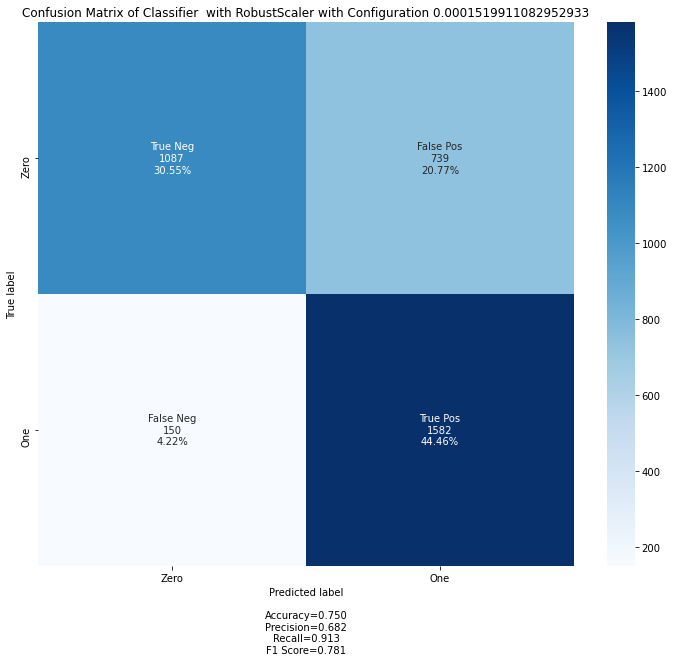

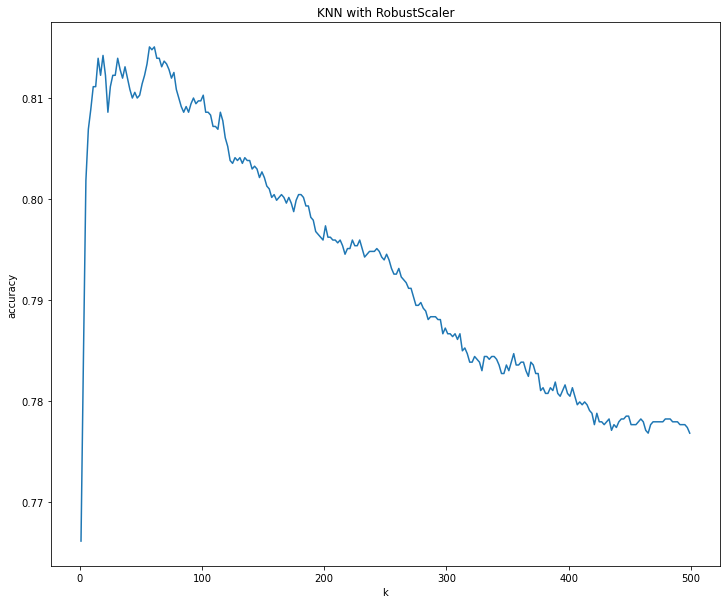

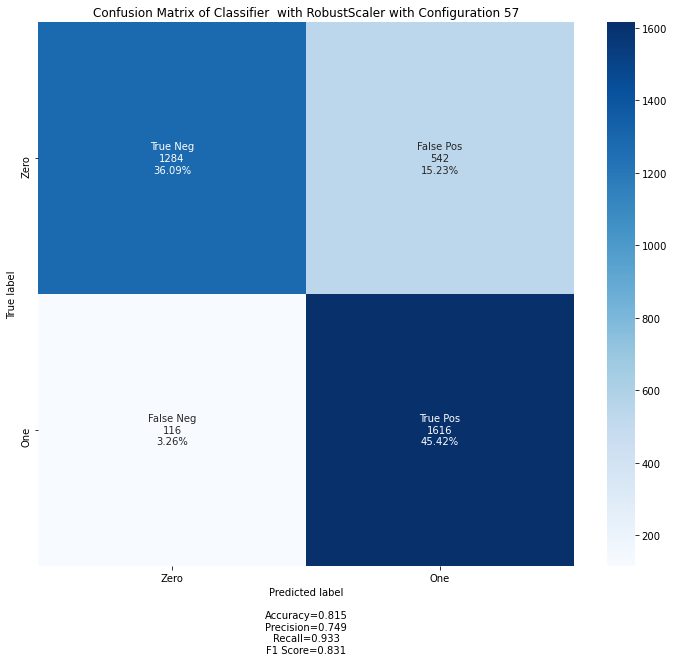

In [31]:
def get_confusion_matrix_of_best(configuration_list, accuracy_scores, predictions, classifiers, X, y, classifier_name, path):
    best_index = accuracy_scores.index(max(accuracy_scores))
    #Vplot_confusion_matrix(classifiers[best_index], X, y)
    labels = ["True Neg","False Pos","False Neg", "True Pos"]
    categories = ["Zero", "One"]
    title = "Confusion Matrix of Classifier {} with Configuration {}".format(classifier_name, configuration_list[best_index])
    #print(type(y))
    #print(type(predictions[best_index]))
    cf = confusion_matrix(y, predictions[best_index])
    make_confusion_matrix(cf, figsize=(12,10), group_names=labels, categories=categories, title=title, path=path)
    return classifiers[best_index]
    
# "classifier_name" expects "svm", "knn", "gaussian_nb" 
def run_classifier(classifier_name, X_train, X_test, y_train, y_test, config_str=" with RobustScaler", path = "graphs/classifiers/"):
    configure_list = []
    accuracy_scores = []
    classifiers = []
    predictions = []
    configs = []
    
    label_x = ""
    label_y = "accuracy"
    title = ""
    
    path_of_classifier = path+"/{}".format(classifier_name)
    Path(path_of_classifier).mkdir(parents=True, exist_ok=True)

    drawBarGraphSwitch = False
    drawLineGraphSwitch = False
    
    # Configure "configure_list" based on "classifier_name"
    # One day we will get switch-case for these type of if statements :)
    
    if classifier_name == "svm":
        configure_list = ["linear", "poly", "rbf", "sigmoid"]
        label_x = "kernel"
        title = "SVM{}".format(config_str)
        drawBarGraphSwitch = True
        drawLineGraphSwitch = False

    elif classifier_name == "gaussian_nb":
        configure_list = np.logspace(0,-9, num=100)
        label_x = "smoothing parameter"
        title = "Naive Bayes{}".format(config_str)
        drawBarGraphSwitch = False
        drawLineGraphSwitch = True

    elif classifier_name == "knn":
        configure_list = [num for num in range(500) if num % 2 == 1]
        label_x = "k"
        title = "KNN{}".format(config_str)
        drawBarGraphSwitch = False
        drawLineGraphSwitch = True

    
    for config in configure_list:
        if classifier_name == "svm":
            classifier, accuracy_score, y_pred = svm(X_train,X_test,y_train,y_test, kernel=config)
        elif classifier_name == "gaussian_nb":
            classifier, accuracy_score, y_pred = gaussian_nb(X_train,X_test,y_train,y_test, smoothing_parameter=config)
        elif classifier_name == "knn":
            classifier, accuracy_score, y_pred = knn(X_train,X_test,y_train,y_test, neighbors=config)
        
        accuracy_scores.append(accuracy_score)
        classifiers.append(classifier)
        predictions.append(y_pred)
        configs.append(config)
    
    if drawBarGraphSwitch:
        draw_bar_graph(configure_list, accuracy_scores, label_x, label_y, title, path = path_of_classifier)
    elif drawLineGraphSwitch:
        draw_line_graph(configure_list, accuracy_scores, label_x, label_y, title, path = path_of_classifier)
    
    
    best_clf = get_confusion_matrix_of_best(configure_list, accuracy_scores, predictions, classifiers,  X_test, y_test, config_str, path = path_of_classifier)
    return best_clf

path_of_classifiers = "graphs/classifiers"  
Path(path_of_classifiers).mkdir(parents=True, exist_ok=True)

best_svm_clf = run_classifier("svm", X_train, X_test, y_train, y_test, config_str=" with RobustScaler", path = path_of_classifiers)
best_nb_clf = run_classifier("gaussian_nb", X_train, X_test, y_train, y_test, config_str=" with RobustScaler", path = path_of_classifiers)
best_knn_clf = run_classifier("knn", X_train, X_test, y_train, y_test, config_str=" with RobustScaler", path = path_of_classifiers)

In [32]:
def plot_training(H, plotPath):
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")
    plt.plot(H.history["accuracy"], label="train_acc")
    plt.plot(H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(plotPath)

--- ANN with hidden layers [[16, 'lisht']], batch size 64, epoch size 1000, optimizer adam  ---
[16, 'lisht']
[[[16, 'lisht']], [[128, 'lisht']], [[128, 'lisht'], [128, 'lisht']], [[128, 'swish'], [128, 'swish']]]
Epoch 1/1000
 14/223 [>.............................] - ETA: 1s - loss: 1.1191 - accuracy: 0.6172

C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


223/223 [==============================] - 2s 9ms/step - loss: 0.6546 - accuracy: 0.7591 - val_loss: 0.4244 - val_accuracy: 0.8168
Epoch 2/1000
  8/223 [>.............................] - ETA: 1s - loss: 0.4494 - accuracy: 0.8105

C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


223/223 [==============================] - 2s 9ms/step - loss: 0.4707 - accuracy: 0.7935 - val_loss: 0.4200 - val_accuracy: 0.8128
Epoch 3/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.4828 - accuracy: 0.7879 - val_loss: 0.6807 - val_accuracy: 0.7150
Epoch 4/1000
223/223 [==============================] - 2s 9ms/step - loss: 1.4068 - accuracy: 0.7262 - val_loss: 1.2950 - val_accuracy: 0.7313
Epoch 5/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.5351 - accuracy: 0.7901 - val_loss: 0.4423 - val_accuracy: 0.8049
Epoch 6/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.4540 - accuracy: 0.7995 - val_loss: 0.4593 - val_accuracy: 0.7931
Epoch 7/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.4264 - accuracy: 0.8114 - val_loss: 0.4249 - val_accuracy: 0.8179
Epoch 8/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.4378 - accuracy: 0.8054 - val_loss: 0.4565 - val_accuracy: 0.7920
Epoc

C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


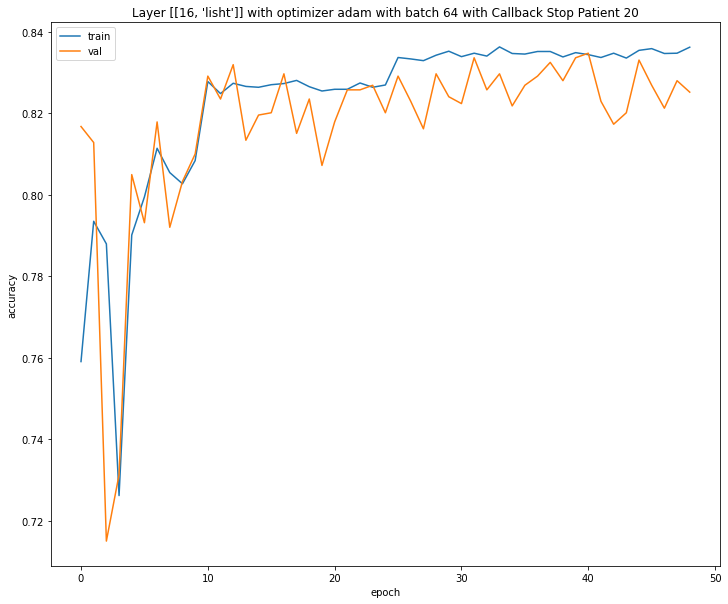

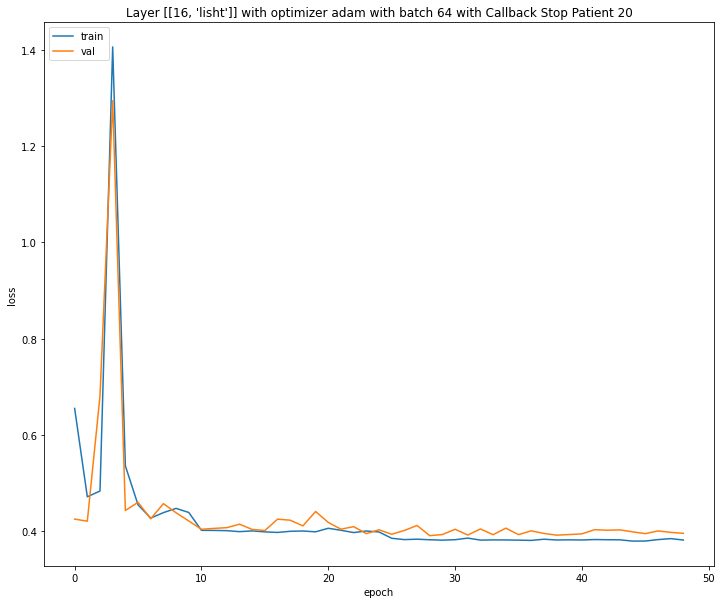

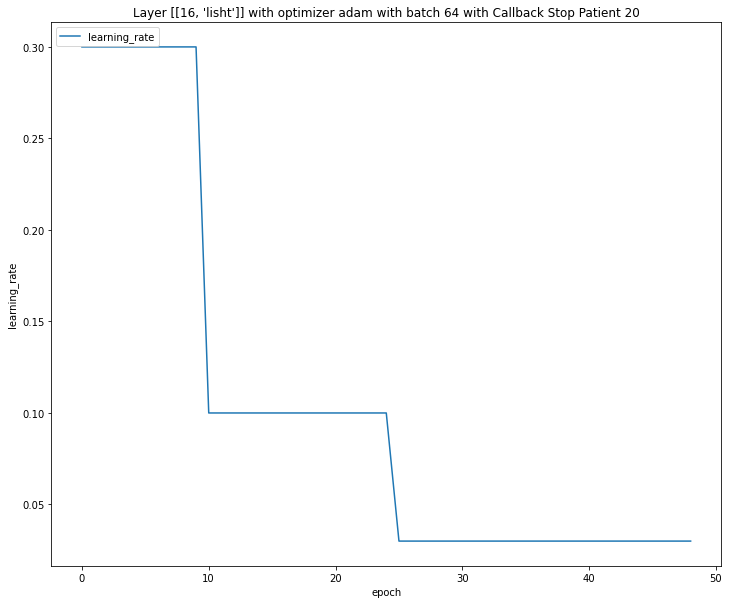

--- ANN with hidden layers [[16, 'lisht']], batch size 64, epoch size 1000, optimizer adam  ---
[16, 'lisht']
[[[16, 'lisht']], [[128, 'lisht']], [[128, 'lisht'], [128, 'lisht']], [[128, 'swish'], [128, 'swish']]]
Epoch 1/1000
 12/223 [>.............................] - ETA: 2s - loss: 1.6161 - accuracy: 0.5716

C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


223/223 [==============================] - 3s 11ms/step - loss: 0.6088 - accuracy: 0.7701 - val_loss: 0.4809 - val_accuracy: 0.7802
Epoch 2/1000
  6/223 [..............................] - ETA: 2s - loss: 0.5254 - accuracy: 0.7578

C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


223/223 [==============================] - 2s 10ms/step - loss: 0.5397 - accuracy: 0.7711 - val_loss: 0.4732 - val_accuracy: 0.8061
Epoch 3/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.6265 - accuracy: 0.7768 - val_loss: 0.5263 - val_accuracy: 0.7639
Epoch 4/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.4705 - accuracy: 0.7981 - val_loss: 0.4643 - val_accuracy: 0.8151
Epoch 5/1000
223/223 [==============================] - 2s 10ms/step - loss: 1.3634 - accuracy: 0.7506 - val_loss: 2.0960 - val_accuracy: 0.7594
Epoch 6/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.7553 - accuracy: 0.7800 - val_loss: 0.4569 - val_accuracy: 0.8004
Epoch 7/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.4322 - accuracy: 0.8092 - val_loss: 0.4544 - val_accuracy: 0.7948
Epoch 8/1000
223/223 [==============================] - 3s 11ms/step - loss: 0.4267 - accuracy: 0.8137 - val_loss: 0.4766 - val_accuracy: 0.796

223/223 [==============================] - 2s 9ms/step - loss: 0.3774 - accuracy: 0.8352 - val_loss: 0.4026 - val_accuracy: 0.8257
Epoch 59/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3795 - accuracy: 0.8373 - val_loss: 0.3998 - val_accuracy: 0.8392
Epoch 60/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3812 - accuracy: 0.8318 - val_loss: 0.4029 - val_accuracy: 0.8302
Epoch 61/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3800 - accuracy: 0.8335 - val_loss: 0.3991 - val_accuracy: 0.8342
Epoch 62/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3763 - accuracy: 0.8366 - val_loss: 0.3939 - val_accuracy: 0.8325
Epoch 63/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3792 - accuracy: 0.8362 - val_loss: 0.3996 - val_accuracy: 0.8375
Epoch 64/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3782 - accuracy: 0.8338 - val_loss: 0.3960 - val_accuracy: 0.

223/223 [==============================] - 2s 10ms/step - loss: 0.3702 - accuracy: 0.8385 - val_loss: 0.3952 - val_accuracy: 0.8359
Epoch 115/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3700 - accuracy: 0.8390 - val_loss: 0.3990 - val_accuracy: 0.8353
Epoch 116/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3702 - accuracy: 0.8390 - val_loss: 0.3953 - val_accuracy: 0.8359
Epoch 117/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3710 - accuracy: 0.8389 - val_loss: 0.3992 - val_accuracy: 0.8297
Epoch 118/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3716 - accuracy: 0.8385 - val_loss: 0.3993 - val_accuracy: 0.8274
Epoch 119/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3705 - accuracy: 0.8387 - val_loss: 0.3944 - val_accuracy: 0.8302
Epoch 120/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3699 - accuracy: 0.8388 - val_loss: 0.3961 - val_accuracy

223/223 [==============================] - 2s 10ms/step - loss: 0.3704 - accuracy: 0.8397 - val_loss: 0.3997 - val_accuracy: 0.8331
Epoch 171/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3700 - accuracy: 0.8403 - val_loss: 0.3968 - val_accuracy: 0.8387
Epoch 172/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3700 - accuracy: 0.8384 - val_loss: 0.3959 - val_accuracy: 0.8291
Epoch 173/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3695 - accuracy: 0.8390 - val_loss: 0.3966 - val_accuracy: 0.8314
Epoch 174/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3707 - accuracy: 0.8367 - val_loss: 0.4058 - val_accuracy: 0.8224
Epoch 175/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3708 - accuracy: 0.8375 - val_loss: 0.3977 - val_accuracy: 0.8370
Epoch 176/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3698 - accuracy: 0.8382 - val_loss: 0.3955 - val_accuracy

223/223 [==============================] - 2s 10ms/step - loss: 0.3694 - accuracy: 0.8394 - val_loss: 0.3980 - val_accuracy: 0.8347
Epoch 227/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3693 - accuracy: 0.8379 - val_loss: 0.4017 - val_accuracy: 0.8286
Epoch 228/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3705 - accuracy: 0.8376 - val_loss: 0.3997 - val_accuracy: 0.8308
Epoch 229/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3695 - accuracy: 0.8399 - val_loss: 0.3974 - val_accuracy: 0.8392
Epoch 230/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3698 - accuracy: 0.8384 - val_loss: 0.3973 - val_accuracy: 0.8269
Epoch 231/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3715 - accuracy: 0.8384 - val_loss: 0.3966 - val_accuracy: 0.8308
Epoch 232/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3699 - accuracy: 0.8391 - val_loss: 0.3971 - val_accurac

223/223 [==============================] - 2s 10ms/step - loss: 0.3698 - accuracy: 0.8386 - val_loss: 0.3989 - val_accuracy: 0.8342
Epoch 283/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3696 - accuracy: 0.8383 - val_loss: 0.4038 - val_accuracy: 0.8319
Epoch 284/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3703 - accuracy: 0.8386 - val_loss: 0.3987 - val_accuracy: 0.8319
Epoch 285/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3698 - accuracy: 0.8385 - val_loss: 0.3976 - val_accuracy: 0.8325
Epoch 286/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3698 - accuracy: 0.8389 - val_loss: 0.3991 - val_accuracy: 0.8381
Epoch 287/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3714 - accuracy: 0.8375 - val_loss: 0.3972 - val_accuracy: 0.8353
Epoch 288/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3695 - accuracy: 0.8392 - val_loss: 0.3968 - val_accurac

223/223 [==============================] - 2s 10ms/step - loss: 0.3694 - accuracy: 0.8380 - val_loss: 0.3983 - val_accuracy: 0.8263
Epoch 339/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3690 - accuracy: 0.8393 - val_loss: 0.3983 - val_accuracy: 0.8387
Epoch 340/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3695 - accuracy: 0.8399 - val_loss: 0.3968 - val_accuracy: 0.8314
Epoch 341/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3693 - accuracy: 0.8383 - val_loss: 0.4018 - val_accuracy: 0.8381
Epoch 342/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3696 - accuracy: 0.8380 - val_loss: 0.3965 - val_accuracy: 0.8319
Epoch 343/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3699 - accuracy: 0.8382 - val_loss: 0.3975 - val_accuracy: 0.8387
Epoch 344/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3702 - accuracy: 0.8392 - val_loss: 0.3960 - val_accuracy

223/223 [==============================] - 2s 9ms/step - loss: 0.3698 - accuracy: 0.8387 - val_loss: 0.3987 - val_accuracy: 0.8342
Epoch 395/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3697 - accuracy: 0.8392 - val_loss: 0.3950 - val_accuracy: 0.8364
Epoch 396/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3696 - accuracy: 0.8375 - val_loss: 0.4078 - val_accuracy: 0.8246
Epoch 397/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3700 - accuracy: 0.8390 - val_loss: 0.3971 - val_accuracy: 0.8297
Epoch 398/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3688 - accuracy: 0.8384 - val_loss: 0.3966 - val_accuracy: 0.8353
Epoch 399/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3696 - accuracy: 0.8395 - val_loss: 0.3970 - val_accuracy: 0.8359
Epoch 400/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3695 - accuracy: 0.8385 - val_loss: 0.3971 - val_accuracy

223/223 [==============================] - 2s 10ms/step - loss: 0.3693 - accuracy: 0.8394 - val_loss: 0.3961 - val_accuracy: 0.8331
Epoch 451/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3692 - accuracy: 0.8383 - val_loss: 0.4015 - val_accuracy: 0.8319
Epoch 452/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3704 - accuracy: 0.8386 - val_loss: 0.3962 - val_accuracy: 0.8291
Epoch 453/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3685 - accuracy: 0.8391 - val_loss: 0.3982 - val_accuracy: 0.8370
Epoch 454/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3686 - accuracy: 0.8391 - val_loss: 0.3969 - val_accuracy: 0.8325
Epoch 455/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3693 - accuracy: 0.8400 - val_loss: 0.4009 - val_accuracy: 0.8381
Epoch 456/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3701 - accuracy: 0.8394 - val_loss: 0.3999 - val_accurac

223/223 [==============================] - 2s 9ms/step - loss: 0.3691 - accuracy: 0.8386 - val_loss: 0.3974 - val_accuracy: 0.8325
Epoch 507/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3689 - accuracy: 0.8392 - val_loss: 0.3965 - val_accuracy: 0.8353
Epoch 508/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3694 - accuracy: 0.8375 - val_loss: 0.3965 - val_accuracy: 0.8314
Epoch 509/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3694 - accuracy: 0.8387 - val_loss: 0.3999 - val_accuracy: 0.8370
Epoch 510/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3688 - accuracy: 0.8402 - val_loss: 0.3970 - val_accuracy: 0.8370
Epoch 511/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3695 - accuracy: 0.8387 - val_loss: 0.3994 - val_accuracy: 0.8286
Epoch 512/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3698 - accuracy: 0.8389 - val_loss: 0.3967 - val_accuracy: 

223/223 [==============================] - 2s 10ms/step - loss: 0.3685 - accuracy: 0.8408 - val_loss: 0.3995 - val_accuracy: 0.8252
Epoch 563/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3700 - accuracy: 0.8385 - val_loss: 0.3964 - val_accuracy: 0.8370
Epoch 564/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3691 - accuracy: 0.8394 - val_loss: 0.3983 - val_accuracy: 0.8325
Epoch 565/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3705 - accuracy: 0.8393 - val_loss: 0.3966 - val_accuracy: 0.8319
Epoch 566/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3684 - accuracy: 0.8387 - val_loss: 0.3943 - val_accuracy: 0.8336
Epoch 567/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3681 - accuracy: 0.8405 - val_loss: 0.3931 - val_accuracy: 0.8347
Epoch 568/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3694 - accuracy: 0.8399 - val_loss: 0.4020 - val_accuracy

223/223 [==============================] - 2s 9ms/step - loss: 0.3690 - accuracy: 0.8401 - val_loss: 0.3937 - val_accuracy: 0.8342
Epoch 619/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3694 - accuracy: 0.8397 - val_loss: 0.3961 - val_accuracy: 0.8291
Epoch 620/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3682 - accuracy: 0.8400 - val_loss: 0.3993 - val_accuracy: 0.8392
Epoch 621/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3681 - accuracy: 0.8400 - val_loss: 0.3961 - val_accuracy: 0.8387
Epoch 622/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3691 - accuracy: 0.8400 - val_loss: 0.3977 - val_accuracy: 0.8375
Epoch 623/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3696 - accuracy: 0.8388 - val_loss: 0.4095 - val_accuracy: 0.8286
Epoch 624/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3676 - accuracy: 0.8398 - val_loss: 0.3948 - val_accurac

223/223 [==============================] - 2s 9ms/step - loss: 0.3687 - accuracy: 0.8400 - val_loss: 0.3951 - val_accuracy: 0.8342
Epoch 675/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.3698 - accuracy: 0.8405 - val_loss: 0.3987 - val_accuracy: 0.8325
Epoch 676/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3690 - accuracy: 0.8394 - val_loss: 0.3964 - val_accuracy: 0.8342
Epoch 677/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3673 - accuracy: 0.8411 - val_loss: 0.4004 - val_accuracy: 0.8364
Epoch 678/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3695 - accuracy: 0.8380 - val_loss: 0.3971 - val_accuracy: 0.8375
Epoch 679/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3688 - accuracy: 0.8412 - val_loss: 0.3960 - val_accuracy: 0.8280
Epoch 680/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3707 - accuracy: 0.8407 - val_loss: 0.3983 - val_accur

223/223 [==============================] - 2s 9ms/step - loss: 0.3708 - accuracy: 0.8378 - val_loss: 0.3978 - val_accuracy: 0.8342
Epoch 731/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3682 - accuracy: 0.8418 - val_loss: 0.3979 - val_accuracy: 0.8404
Epoch 732/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3689 - accuracy: 0.8397 - val_loss: 0.3998 - val_accuracy: 0.8342
Epoch 733/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3688 - accuracy: 0.8397 - val_loss: 0.3957 - val_accuracy: 0.8381
Epoch 734/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3678 - accuracy: 0.8405 - val_loss: 0.3966 - val_accuracy: 0.8370
Epoch 735/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3689 - accuracy: 0.8379 - val_loss: 0.4020 - val_accuracy: 0.8252
Epoch 736/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3701 - accuracy: 0.8389 - val_loss: 0.3991 - val_accuracy:

223/223 [==============================] - 2s 9ms/step - loss: 0.3692 - accuracy: 0.8399 - val_loss: 0.3993 - val_accuracy: 0.8398
Epoch 787/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3696 - accuracy: 0.8385 - val_loss: 0.3973 - val_accuracy: 0.8375
Epoch 788/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3685 - accuracy: 0.8385 - val_loss: 0.3999 - val_accuracy: 0.8269
Epoch 789/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3686 - accuracy: 0.8408 - val_loss: 0.3982 - val_accuracy: 0.8342
Epoch 790/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.3687 - accuracy: 0.8401 - val_loss: 0.3971 - val_accuracy: 0.8353
Epoch 791/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3691 - accuracy: 0.8407 - val_loss: 0.3969 - val_accuracy: 0.8347
Epoch 792/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3694 - accuracy: 0.8375 - val_loss: 0.4030 - val_accuracy

223/223 [==============================] - 2s 9ms/step - loss: 0.3682 - accuracy: 0.8406 - val_loss: 0.3958 - val_accuracy: 0.8353
Epoch 843/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3685 - accuracy: 0.8396 - val_loss: 0.3975 - val_accuracy: 0.8347
Epoch 844/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3698 - accuracy: 0.8400 - val_loss: 0.3958 - val_accuracy: 0.8342
Epoch 845/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3689 - accuracy: 0.8405 - val_loss: 0.3998 - val_accuracy: 0.8331
Epoch 846/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3684 - accuracy: 0.8385 - val_loss: 0.4000 - val_accuracy: 0.8269
Epoch 847/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3697 - accuracy: 0.8397 - val_loss: 0.3968 - val_accuracy: 0.8302
Epoch 848/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3703 - accuracy: 0.8384 - val_loss: 0.3943 - val_accuracy:

223/223 [==============================] - 2s 9ms/step - loss: 0.3677 - accuracy: 0.8383 - val_loss: 0.4011 - val_accuracy: 0.8314
Epoch 899/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3690 - accuracy: 0.8399 - val_loss: 0.4011 - val_accuracy: 0.8370
Epoch 900/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3679 - accuracy: 0.8403 - val_loss: 0.4007 - val_accuracy: 0.8286
Epoch 901/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3691 - accuracy: 0.8397 - val_loss: 0.3946 - val_accuracy: 0.8375
Epoch 902/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3681 - accuracy: 0.8401 - val_loss: 0.3997 - val_accuracy: 0.8297
Epoch 903/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3703 - accuracy: 0.8400 - val_loss: 0.3978 - val_accuracy: 0.8314
Epoch 904/1000
223/223 [==============================] - 2s 8ms/step - loss: 0.3708 - accuracy: 0.8393 - val_loss: 0.3990 - val_accuracy: 

223/223 [==============================] - 2s 9ms/step - loss: 0.3689 - accuracy: 0.8390 - val_loss: 0.4029 - val_accuracy: 0.8308
Epoch 955/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3685 - accuracy: 0.8396 - val_loss: 0.4012 - val_accuracy: 0.8359
Epoch 956/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3695 - accuracy: 0.8379 - val_loss: 0.3985 - val_accuracy: 0.8308
Epoch 957/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3690 - accuracy: 0.8410 - val_loss: 0.3974 - val_accuracy: 0.8297
Epoch 958/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3683 - accuracy: 0.8393 - val_loss: 0.4002 - val_accuracy: 0.8331
Epoch 959/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3695 - accuracy: 0.8406 - val_loss: 0.3958 - val_accuracy: 0.8302
Epoch 960/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3697 - accuracy: 0.8390 - val_loss: 0.4064 - val_accura

C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


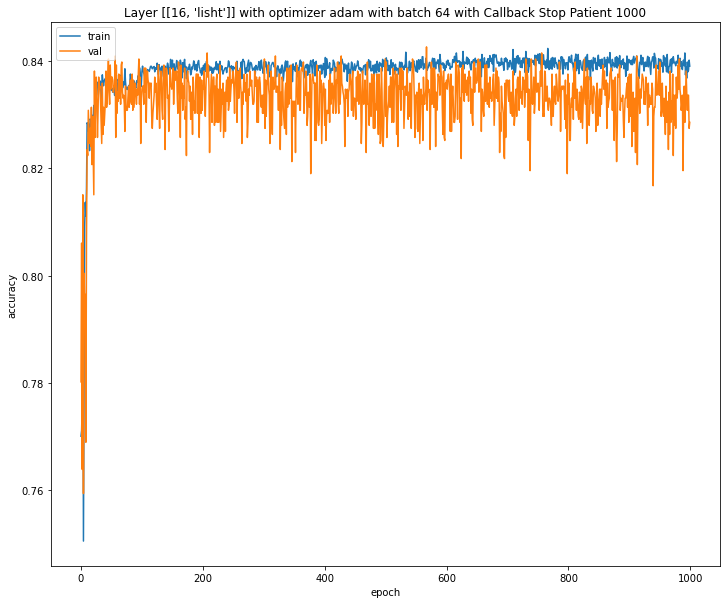

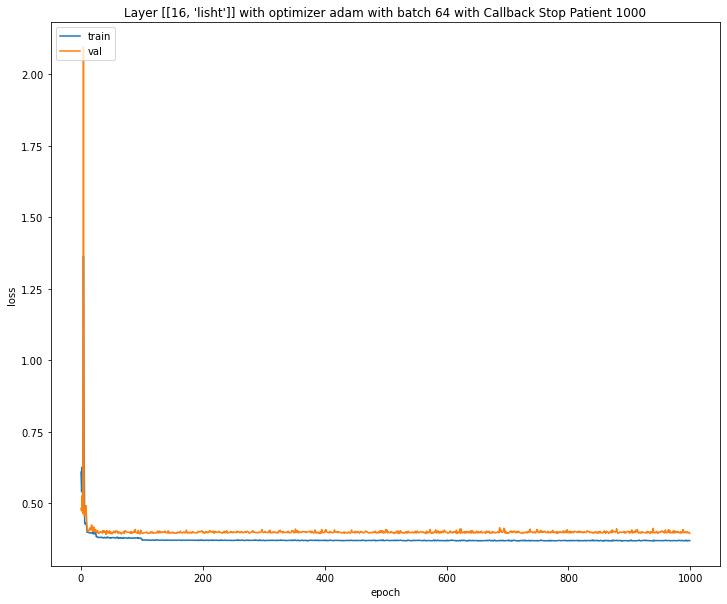

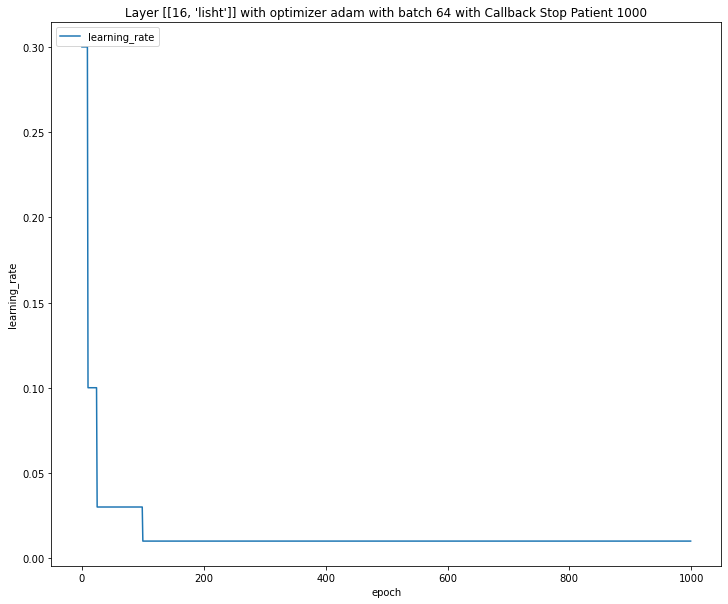

--- ANN with hidden layers [[16, 'lisht']], batch size 14232, epoch size 1000, optimizer adam  ---
[16, 'lisht']
[[[16, 'lisht']], [[128, 'lisht']], [[128, 'lisht'], [128, 'lisht']], [[128, 'swish'], [128, 'swish']]]
Epoch 1/1000
1/1 [==============================] - 0s 87ms/step - loss: 1.0040 - accuracy: 0.3889 - val_loss: 1.8211 - val_accuracy: 0.5132
Epoch 2/1000
1/1 [==============================] - 0s 33ms/step - loss: 1.9802 - accuracy: 0.4967 - val_loss: 1.5260 - val_accuracy: 0.5149
Epoch 3/1000
1/1 [==============================] - 0s 32ms/step - loss: 1.6953 - accuracy: 0.4975 - val_loss: 0.8149 - val_accuracy: 0.6498


C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(
C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


Epoch 4/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.9456 - accuracy: 0.6490 - val_loss: 1.0788 - val_accuracy: 0.7088
Epoch 5/1000
1/1 [==============================] - 0s 36ms/step - loss: 1.1507 - accuracy: 0.7028 - val_loss: 0.7910 - val_accuracy: 0.7066
Epoch 6/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.8680 - accuracy: 0.7077 - val_loss: 0.8598 - val_accuracy: 0.6352
Epoch 7/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.9704 - accuracy: 0.6225 - val_loss: 0.5559 - val_accuracy: 0.7532
Epoch 8/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.6292 - accuracy: 0.7221 - val_loss: 1.2899 - val_accuracy: 0.5284
Epoch 9/1000
1/1 [==============================] - 0s 34ms/step - loss: 1.2926 - accuracy: 0.5423 - val_loss: 0.5778 - val_accuracy: 0.7695
Epoch 10/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.6728 - accuracy: 0.7516 - val_loss: 1.0802 - val_accuracy: 0.6661
Epoch 11/100

C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


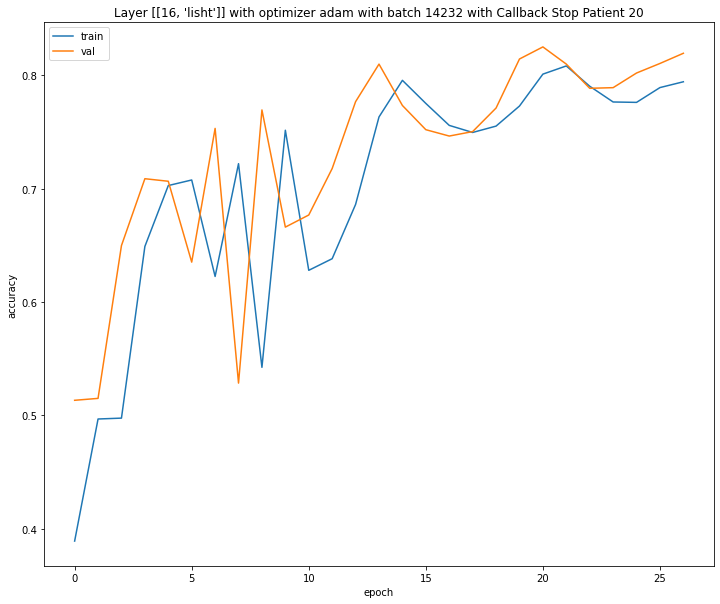

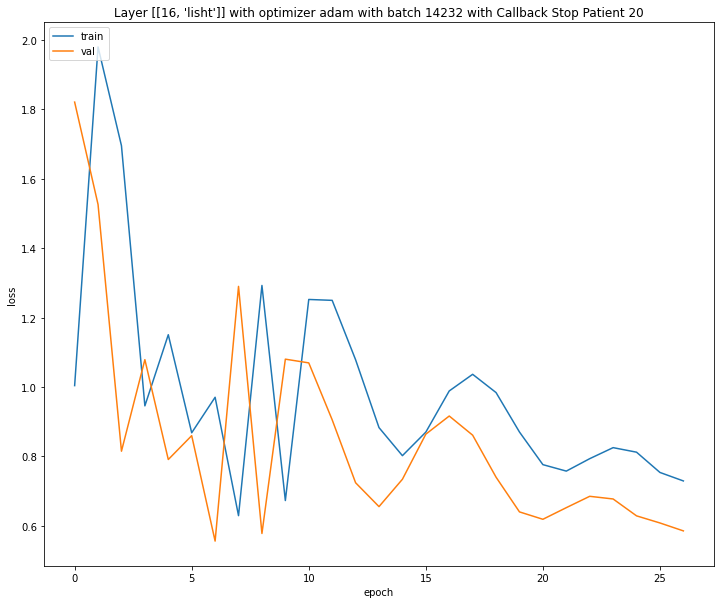

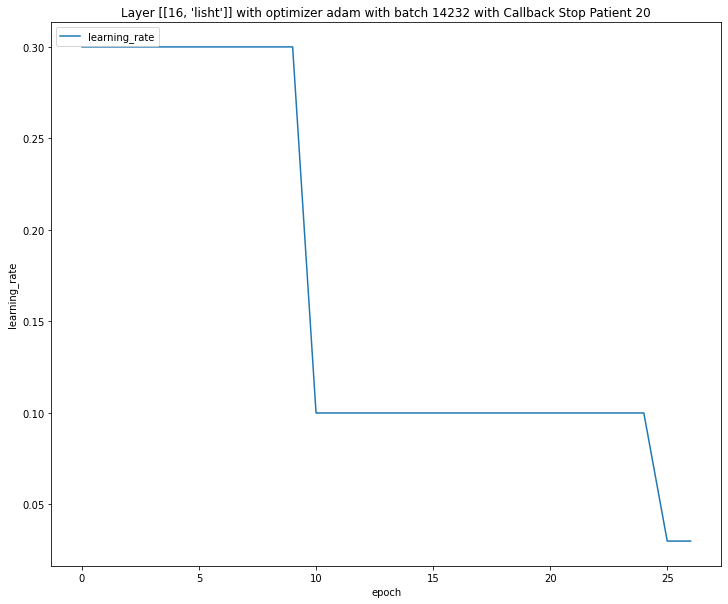

--- ANN with hidden layers [[16, 'lisht']], batch size 14232, epoch size 1000, optimizer adam  ---
[16, 'lisht']
[[[16, 'lisht']], [[128, 'lisht']], [[128, 'lisht'], [128, 'lisht']], [[128, 'swish'], [128, 'swish']]]
Epoch 1/1000
1/1 [==============================] - 0s 82ms/step - loss: 0.7757 - accuracy: 0.3998 - val_loss: 1.3899 - val_accuracy: 0.5239
Epoch 2/1000
1/1 [==============================] - 0s 32ms/step - loss: 1.4458 - accuracy: 0.5084 - val_loss: 0.8285 - val_accuracy: 0.6858
Epoch 3/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.8474 - accuracy: 0.6681 - val_loss: 0.8565 - val_accuracy: 0.7313


C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(
C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


Epoch 4/1000
1/1 [==============================] - 0s 37ms/step - loss: 0.8832 - accuracy: 0.7283 - val_loss: 0.7116 - val_accuracy: 0.7386
Epoch 5/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.7345 - accuracy: 0.7434 - val_loss: 0.5839 - val_accuracy: 0.7718
Epoch 6/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.6168 - accuracy: 0.7463 - val_loss: 0.4924 - val_accuracy: 0.7830
Epoch 7/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.5008 - accuracy: 0.7754 - val_loss: 1.8714 - val_accuracy: 0.5621
Epoch 8/1000
1/1 [==============================] - 0s 38ms/step - loss: 1.8641 - accuracy: 0.5787 - val_loss: 0.7480 - val_accuracy: 0.7291
Epoch 9/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.7937 - accuracy: 0.7104 - val_loss: 1.2302 - val_accuracy: 0.6549
Epoch 10/1000
1/1 [==============================] - 0s 37ms/step - loss: 1.3129 - accuracy: 0.6329 - val_loss: 1.0919 - val_accuracy: 0.7094
Epoch 11/100

Epoch 62/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.4521 - accuracy: 0.8211 - val_loss: 0.4377 - val_accuracy: 0.8184
Epoch 63/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.4474 - accuracy: 0.8215 - val_loss: 0.4340 - val_accuracy: 0.8196
Epoch 64/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.4429 - accuracy: 0.8217 - val_loss: 0.4306 - val_accuracy: 0.8173
Epoch 65/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.4386 - accuracy: 0.8209 - val_loss: 0.4275 - val_accuracy: 0.8168
Epoch 66/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.4345 - accuracy: 0.8207 - val_loss: 0.4246 - val_accuracy: 0.8162
Epoch 67/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.4307 - accuracy: 0.8203 - val_loss: 0.4220 - val_accuracy: 0.8151
Epoch 68/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.4272 - accuracy: 0.8203 - val_loss: 0.4195 - val_accuracy: 0.8151
Epoch 

1/1 [==============================] - 0s 31ms/step - loss: 0.4015 - accuracy: 0.8255 - val_loss: 0.3985 - val_accuracy: 0.8156
Epoch 120/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.4015 - accuracy: 0.8255 - val_loss: 0.3984 - val_accuracy: 0.8156
Epoch 121/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.4014 - accuracy: 0.8254 - val_loss: 0.3984 - val_accuracy: 0.8162
Epoch 122/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.4013 - accuracy: 0.8254 - val_loss: 0.3983 - val_accuracy: 0.8162
Epoch 123/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.4013 - accuracy: 0.8256 - val_loss: 0.3983 - val_accuracy: 0.8162
Epoch 124/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.4012 - accuracy: 0.8257 - val_loss: 0.3982 - val_accuracy: 0.8162
Epoch 125/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.4012 - accuracy: 0.8256 - val_loss: 0.3982 - val_accuracy: 0.8173
Epoch 126/1000

1/1 [==============================] - 0s 35ms/step - loss: 0.3981 - accuracy: 0.8272 - val_loss: 0.3952 - val_accuracy: 0.8196
Epoch 177/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.3981 - accuracy: 0.8273 - val_loss: 0.3952 - val_accuracy: 0.8196
Epoch 178/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.3980 - accuracy: 0.8273 - val_loss: 0.3951 - val_accuracy: 0.8196
Epoch 179/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.3979 - accuracy: 0.8273 - val_loss: 0.3951 - val_accuracy: 0.8196
Epoch 180/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.3979 - accuracy: 0.8273 - val_loss: 0.3950 - val_accuracy: 0.8196
Epoch 181/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.3978 - accuracy: 0.8272 - val_loss: 0.3950 - val_accuracy: 0.8196
Epoch 182/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.3978 - accuracy: 0.8273 - val_loss: 0.3949 - val_accuracy: 0.8196
Epoch 183/1000

1/1 [==============================] - 0s 34ms/step - loss: 0.3948 - accuracy: 0.8297 - val_loss: 0.3919 - val_accuracy: 0.8235
Epoch 234/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.3948 - accuracy: 0.8299 - val_loss: 0.3919 - val_accuracy: 0.8235
Epoch 235/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.3947 - accuracy: 0.8299 - val_loss: 0.3918 - val_accuracy: 0.8229
Epoch 236/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.3947 - accuracy: 0.8302 - val_loss: 0.3918 - val_accuracy: 0.8224
Epoch 237/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.3946 - accuracy: 0.8302 - val_loss: 0.3917 - val_accuracy: 0.8224
Epoch 238/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.3946 - accuracy: 0.8302 - val_loss: 0.3916 - val_accuracy: 0.8218
Epoch 239/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.3945 - accuracy: 0.8302 - val_loss: 0.3916 - val_accuracy: 0.8218
Epoch 240/1000

1/1 [==============================] - 0s 33ms/step - loss: 0.3915 - accuracy: 0.8309 - val_loss: 0.3889 - val_accuracy: 0.8229
Epoch 291/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.3915 - accuracy: 0.8309 - val_loss: 0.3889 - val_accuracy: 0.8229
Epoch 292/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.3914 - accuracy: 0.8310 - val_loss: 0.3888 - val_accuracy: 0.8229
Epoch 293/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.3914 - accuracy: 0.8310 - val_loss: 0.3888 - val_accuracy: 0.8229
Epoch 294/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.3913 - accuracy: 0.8312 - val_loss: 0.3887 - val_accuracy: 0.8229
Epoch 295/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.3913 - accuracy: 0.8312 - val_loss: 0.3887 - val_accuracy: 0.8229
Epoch 296/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.3912 - accuracy: 0.8312 - val_loss: 0.3886 - val_accuracy: 0.8229
Epoch 297/1000

1/1 [==============================] - 0s 36ms/step - loss: 0.3883 - accuracy: 0.8324 - val_loss: 0.3864 - val_accuracy: 0.8235
Epoch 348/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.3883 - accuracy: 0.8323 - val_loss: 0.3864 - val_accuracy: 0.8235
Epoch 349/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.3882 - accuracy: 0.8323 - val_loss: 0.3863 - val_accuracy: 0.8235
Epoch 350/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.3882 - accuracy: 0.8322 - val_loss: 0.3863 - val_accuracy: 0.8235
Epoch 351/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.3881 - accuracy: 0.8321 - val_loss: 0.3862 - val_accuracy: 0.8241
Epoch 352/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.3881 - accuracy: 0.8322 - val_loss: 0.3862 - val_accuracy: 0.8241
Epoch 353/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.3880 - accuracy: 0.8323 - val_loss: 0.3862 - val_accuracy: 0.8241
Epoch 354/1000

1/1 [==============================] - 0s 42ms/step - loss: 0.3859 - accuracy: 0.8342 - val_loss: 0.3844 - val_accuracy: 0.8263
Epoch 405/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.3858 - accuracy: 0.8342 - val_loss: 0.3843 - val_accuracy: 0.8263
Epoch 406/1000
1/1 [==============================] - 0s 37ms/step - loss: 0.3858 - accuracy: 0.8342 - val_loss: 0.3843 - val_accuracy: 0.8263
Epoch 407/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.3858 - accuracy: 0.8342 - val_loss: 0.3843 - val_accuracy: 0.8269
Epoch 408/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.3857 - accuracy: 0.8342 - val_loss: 0.3842 - val_accuracy: 0.8269
Epoch 409/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.3857 - accuracy: 0.8343 - val_loss: 0.3842 - val_accuracy: 0.8269
Epoch 410/1000
1/1 [==============================] - 0s 37ms/step - loss: 0.3857 - accuracy: 0.8343 - val_loss: 0.3842 - val_accuracy: 0.8269
Epoch 411/1000

1/1 [==============================] - 0s 34ms/step - loss: 0.3843 - accuracy: 0.8352 - val_loss: 0.3830 - val_accuracy: 0.8280
Epoch 462/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.3842 - accuracy: 0.8352 - val_loss: 0.3829 - val_accuracy: 0.8280
Epoch 463/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.3842 - accuracy: 0.8352 - val_loss: 0.3829 - val_accuracy: 0.8280
Epoch 464/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.3842 - accuracy: 0.8352 - val_loss: 0.3829 - val_accuracy: 0.8280
Epoch 465/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.3842 - accuracy: 0.8352 - val_loss: 0.3829 - val_accuracy: 0.8280
Epoch 466/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.3842 - accuracy: 0.8352 - val_loss: 0.3829 - val_accuracy: 0.8274
Epoch 467/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.3841 - accuracy: 0.8351 - val_loss: 0.3828 - val_accuracy: 0.8274
Epoch 468/1000

1/1 [==============================] - 0s 50ms/step - loss: 0.3832 - accuracy: 0.8350 - val_loss: 0.3818 - val_accuracy: 0.8280
Epoch 519/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.3831 - accuracy: 0.8352 - val_loss: 0.3818 - val_accuracy: 0.8280
Epoch 520/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.3831 - accuracy: 0.8351 - val_loss: 0.3818 - val_accuracy: 0.8280
Epoch 521/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.3831 - accuracy: 0.8351 - val_loss: 0.3818 - val_accuracy: 0.8280
Epoch 522/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.3831 - accuracy: 0.8350 - val_loss: 0.3818 - val_accuracy: 0.8280
Epoch 523/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.3831 - accuracy: 0.8350 - val_loss: 0.3817 - val_accuracy: 0.8280
Epoch 524/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.3831 - accuracy: 0.8350 - val_loss: 0.3817 - val_accuracy: 0.8280
Epoch 525/1000

1/1 [==============================] - 0s 35ms/step - loss: 0.3822 - accuracy: 0.8353 - val_loss: 0.3807 - val_accuracy: 0.8263
Epoch 576/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.3822 - accuracy: 0.8353 - val_loss: 0.3807 - val_accuracy: 0.8263
Epoch 577/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.3822 - accuracy: 0.8353 - val_loss: 0.3807 - val_accuracy: 0.8263
Epoch 578/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.3822 - accuracy: 0.8353 - val_loss: 0.3806 - val_accuracy: 0.8263
Epoch 579/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.3822 - accuracy: 0.8354 - val_loss: 0.3806 - val_accuracy: 0.8263
Epoch 580/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.3822 - accuracy: 0.8354 - val_loss: 0.3806 - val_accuracy: 0.8269
Epoch 581/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.3822 - accuracy: 0.8354 - val_loss: 0.3806 - val_accuracy: 0.8269
Epoch 582/1000

1/1 [==============================] - 0s 33ms/step - loss: 0.3814 - accuracy: 0.8356 - val_loss: 0.3796 - val_accuracy: 0.8269
Epoch 633/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.3814 - accuracy: 0.8357 - val_loss: 0.3796 - val_accuracy: 0.8269
Epoch 634/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.3814 - accuracy: 0.8357 - val_loss: 0.3795 - val_accuracy: 0.8269
Epoch 635/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.3814 - accuracy: 0.8357 - val_loss: 0.3795 - val_accuracy: 0.8269
Epoch 636/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.3814 - accuracy: 0.8356 - val_loss: 0.3795 - val_accuracy: 0.8269
Epoch 637/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.3813 - accuracy: 0.8356 - val_loss: 0.3795 - val_accuracy: 0.8269
Epoch 638/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.3813 - accuracy: 0.8356 - val_loss: 0.3795 - val_accuracy: 0.8274
Epoch 639/1000

1/1 [==============================] - 0s 32ms/step - loss: 0.3807 - accuracy: 0.8361 - val_loss: 0.3786 - val_accuracy: 0.8286
Epoch 690/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.3806 - accuracy: 0.8361 - val_loss: 0.3786 - val_accuracy: 0.8286
Epoch 691/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.3806 - accuracy: 0.8361 - val_loss: 0.3786 - val_accuracy: 0.8286
Epoch 692/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.3806 - accuracy: 0.8360 - val_loss: 0.3786 - val_accuracy: 0.8286
Epoch 693/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.3806 - accuracy: 0.8360 - val_loss: 0.3786 - val_accuracy: 0.8286
Epoch 694/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.3806 - accuracy: 0.8360 - val_loss: 0.3786 - val_accuracy: 0.8286
Epoch 695/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.3806 - accuracy: 0.8359 - val_loss: 0.3786 - val_accuracy: 0.8286
Epoch 696/1000

1/1 [==============================] - 0s 36ms/step - loss: 0.3799 - accuracy: 0.8359 - val_loss: 0.3778 - val_accuracy: 0.8302
Epoch 747/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.3799 - accuracy: 0.8359 - val_loss: 0.3777 - val_accuracy: 0.8302
Epoch 748/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.3799 - accuracy: 0.8358 - val_loss: 0.3777 - val_accuracy: 0.8302
Epoch 749/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.3799 - accuracy: 0.8359 - val_loss: 0.3777 - val_accuracy: 0.8302
Epoch 750/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.3799 - accuracy: 0.8359 - val_loss: 0.3777 - val_accuracy: 0.8302
Epoch 751/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.3799 - accuracy: 0.8358 - val_loss: 0.3777 - val_accuracy: 0.8302
Epoch 752/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.3799 - accuracy: 0.8358 - val_loss: 0.3777 - val_accuracy: 0.8302
Epoch 753/1000

1/1 [==============================] - 0s 33ms/step - loss: 0.3792 - accuracy: 0.8360 - val_loss: 0.3769 - val_accuracy: 0.8291
Epoch 804/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.3792 - accuracy: 0.8361 - val_loss: 0.3769 - val_accuracy: 0.8286
Epoch 805/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.3792 - accuracy: 0.8361 - val_loss: 0.3769 - val_accuracy: 0.8286
Epoch 806/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.3792 - accuracy: 0.8360 - val_loss: 0.3769 - val_accuracy: 0.8286
Epoch 807/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.3792 - accuracy: 0.8361 - val_loss: 0.3769 - val_accuracy: 0.8286
Epoch 808/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.3792 - accuracy: 0.8361 - val_loss: 0.3768 - val_accuracy: 0.8291
Epoch 809/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.3791 - accuracy: 0.8361 - val_loss: 0.3768 - val_accuracy: 0.8291
Epoch 810/1000

1/1 [==============================] - 0s 46ms/step - loss: 0.3785 - accuracy: 0.8362 - val_loss: 0.3761 - val_accuracy: 0.8291
Epoch 861/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.3785 - accuracy: 0.8361 - val_loss: 0.3761 - val_accuracy: 0.8291
Epoch 862/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.3785 - accuracy: 0.8361 - val_loss: 0.3761 - val_accuracy: 0.8291
Epoch 863/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.3785 - accuracy: 0.8362 - val_loss: 0.3761 - val_accuracy: 0.8291
Epoch 864/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.3785 - accuracy: 0.8363 - val_loss: 0.3761 - val_accuracy: 0.8297
Epoch 865/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.3785 - accuracy: 0.8364 - val_loss: 0.3761 - val_accuracy: 0.8297
Epoch 866/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.3785 - accuracy: 0.8364 - val_loss: 0.3760 - val_accuracy: 0.8297
Epoch 867/1000

1/1 [==============================] - 0s 30ms/step - loss: 0.3779 - accuracy: 0.8368 - val_loss: 0.3755 - val_accuracy: 0.8302
Epoch 918/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.3779 - accuracy: 0.8368 - val_loss: 0.3755 - val_accuracy: 0.8302
Epoch 919/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.3779 - accuracy: 0.8368 - val_loss: 0.3755 - val_accuracy: 0.8302
Epoch 920/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.3779 - accuracy: 0.8367 - val_loss: 0.3754 - val_accuracy: 0.8302
Epoch 921/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.3778 - accuracy: 0.8368 - val_loss: 0.3754 - val_accuracy: 0.8302
Epoch 922/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.3778 - accuracy: 0.8368 - val_loss: 0.3754 - val_accuracy: 0.8302
Epoch 923/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.3778 - accuracy: 0.8368 - val_loss: 0.3754 - val_accuracy: 0.8302
Epoch 924/1000

1/1 [==============================] - 0s 33ms/step - loss: 0.3773 - accuracy: 0.8371 - val_loss: 0.3750 - val_accuracy: 0.8314
Epoch 975/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.3773 - accuracy: 0.8371 - val_loss: 0.3750 - val_accuracy: 0.8314
Epoch 976/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.3773 - accuracy: 0.8371 - val_loss: 0.3750 - val_accuracy: 0.8314
Epoch 977/1000
1/1 [==============================] - 0s 30ms/step - loss: 0.3773 - accuracy: 0.8371 - val_loss: 0.3750 - val_accuracy: 0.8314
Epoch 978/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.3773 - accuracy: 0.8371 - val_loss: 0.3750 - val_accuracy: 0.8314
Epoch 979/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.3773 - accuracy: 0.8371 - val_loss: 0.3750 - val_accuracy: 0.8302
Epoch 980/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.3773 - accuracy: 0.8371 - val_loss: 0.3750 - val_accuracy: 0.8302
Epoch 981/1000

C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


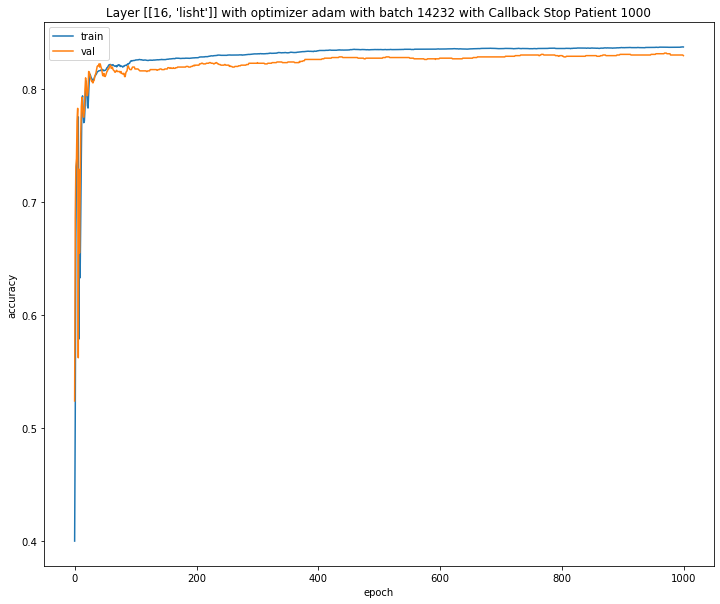

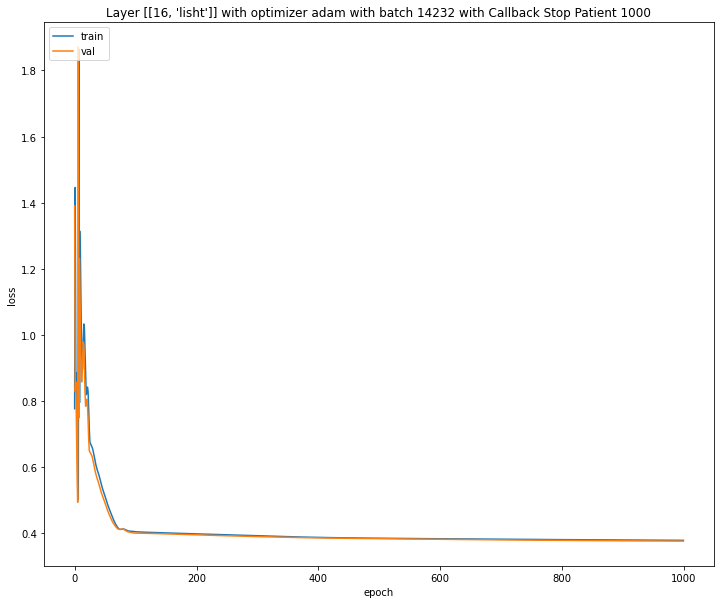

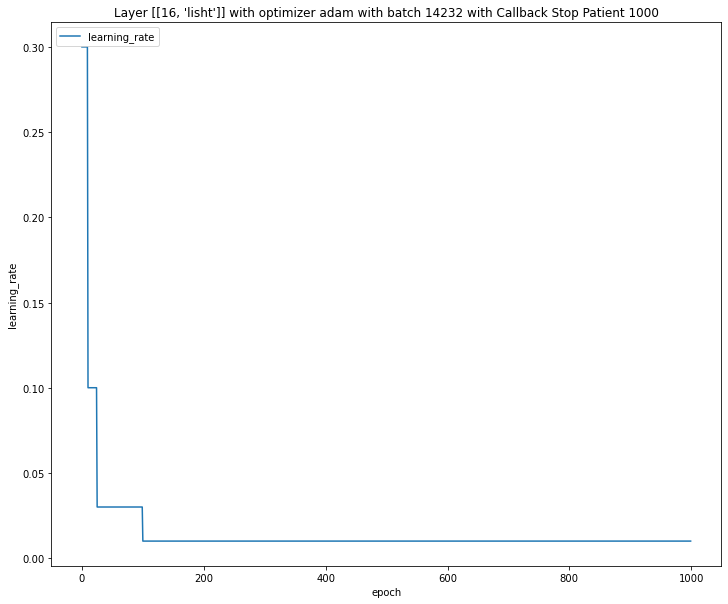

--- ANN with hidden layers [[128, 'lisht']], batch size 64, epoch size 1000, optimizer adam  ---
[128, 'lisht']
[[[16, 'lisht']], [[128, 'lisht']], [[128, 'lisht'], [128, 'lisht']], [[128, 'swish'], [128, 'swish']]]
Epoch 1/1000
 15/223 [=>............................] - ETA: 1s - loss: 6.7133 - accuracy: 0.5948

C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


223/223 [==============================] - 2s 9ms/step - loss: 1.9867 - accuracy: 0.7342 - val_loss: 0.8433 - val_accuracy: 0.7493
Epoch 2/1000
  1/223 [..............................] - ETA: 1s - loss: 0.9716 - accuracy: 0.7344

C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


223/223 [==============================] - 2s 9ms/step - loss: 1.6705 - accuracy: 0.7456 - val_loss: 8.2778 - val_accuracy: 0.6998
Epoch 3/1000
223/223 [==============================] - 2s 10ms/step - loss: 11.1354 - accuracy: 0.7335 - val_loss: 3.7132 - val_accuracy: 0.7544
Epoch 4/1000
223/223 [==============================] - 2s 11ms/step - loss: 1.9326 - accuracy: 0.7603 - val_loss: 1.0485 - val_accuracy: 0.7954
Epoch 5/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.7234 - accuracy: 0.7797 - val_loss: 0.5108 - val_accuracy: 0.7943
Epoch 6/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.4883 - accuracy: 0.8070 - val_loss: 0.6338 - val_accuracy: 0.7583
Epoch 7/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.4956 - accuracy: 0.8038 - val_loss: 0.4972 - val_accuracy: 0.7982
Epoch 8/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.4542 - accuracy: 0.8148 - val_loss: 0.4644 - val_accuracy: 0.7853


C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


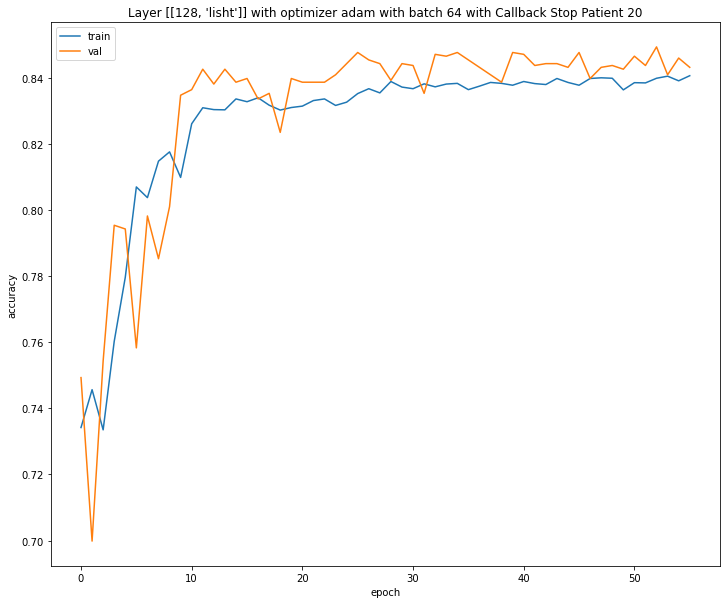

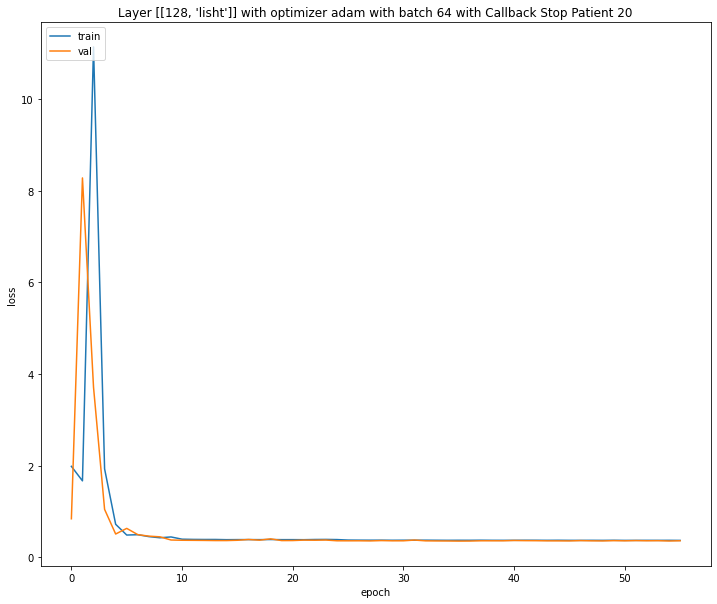

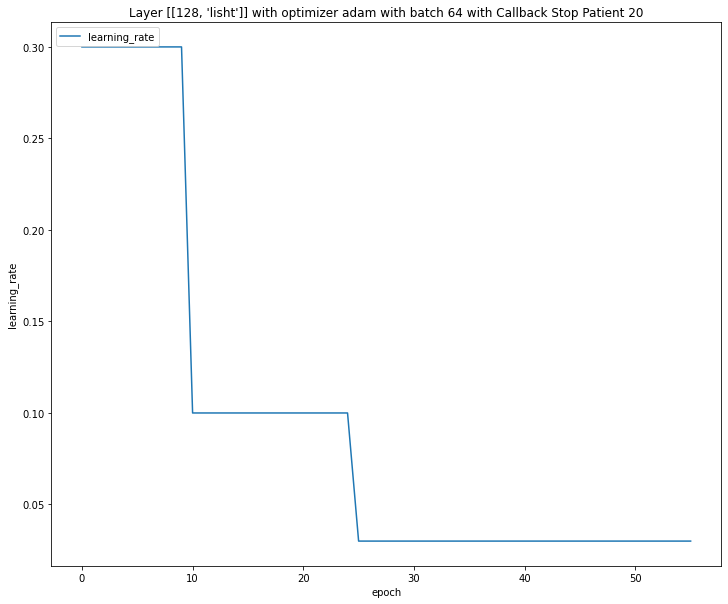

--- ANN with hidden layers [[128, 'lisht']], batch size 64, epoch size 1000, optimizer adam  ---
[128, 'lisht']
[[[16, 'lisht']], [[128, 'lisht']], [[128, 'lisht'], [128, 'lisht']], [[128, 'swish'], [128, 'swish']]]
Epoch 1/1000
 15/223 [=>............................] - ETA: 1s - loss: 3.7389 - accuracy: 0.6198

C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


223/223 [==============================] - 2s 9ms/step - loss: 2.1639 - accuracy: 0.7249 - val_loss: 0.7409 - val_accuracy: 0.7841
Epoch 2/1000
  1/223 [..............................] - ETA: 2s - loss: 0.6872 - accuracy: 0.7812

C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


223/223 [==============================] - 2s 9ms/step - loss: 1.1463 - accuracy: 0.7475 - val_loss: 1.4802 - val_accuracy: 0.7544
Epoch 3/1000
223/223 [==============================] - 2s 9ms/step - loss: 5.2881 - accuracy: 0.7286 - val_loss: 2.1513 - val_accuracy: 0.7971
Epoch 4/1000
223/223 [==============================] - 2s 9ms/step - loss: 3.4180 - accuracy: 0.7402 - val_loss: 3.1062 - val_accuracy: 0.7128
Epoch 5/1000
223/223 [==============================] - 2s 9ms/step - loss: 1.2950 - accuracy: 0.7634 - val_loss: 0.7355 - val_accuracy: 0.7465
Epoch 6/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.5593 - accuracy: 0.7910 - val_loss: 0.5063 - val_accuracy: 0.8083
Epoch 7/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.4941 - accuracy: 0.8059 - val_loss: 0.4804 - val_accuracy: 0.7898
Epoch 8/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.4623 - accuracy: 0.8047 - val_loss: 0.4214 - val_accuracy: 0.8066
Epoch

223/223 [==============================] - 2s 9ms/step - loss: 0.3735 - accuracy: 0.8355 - val_loss: 0.3806 - val_accuracy: 0.8297
Epoch 59/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3729 - accuracy: 0.8375 - val_loss: 0.3841 - val_accuracy: 0.8297
Epoch 60/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3715 - accuracy: 0.8385 - val_loss: 0.3903 - val_accuracy: 0.8263
Epoch 61/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3732 - accuracy: 0.8361 - val_loss: 0.3846 - val_accuracy: 0.8257
Epoch 62/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3730 - accuracy: 0.8393 - val_loss: 0.3849 - val_accuracy: 0.8246
Epoch 63/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3713 - accuracy: 0.8382 - val_loss: 0.3913 - val_accuracy: 0.8269
Epoch 64/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3726 - accuracy: 0.8382 - val_loss: 0.3973 - val_accuracy: 0.8145

223/223 [==============================] - 2s 10ms/step - loss: 0.3588 - accuracy: 0.8426 - val_loss: 0.3845 - val_accuracy: 0.8319
Epoch 115/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3585 - accuracy: 0.8436 - val_loss: 0.3810 - val_accuracy: 0.8325
Epoch 116/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3587 - accuracy: 0.8423 - val_loss: 0.3851 - val_accuracy: 0.8314
Epoch 117/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3582 - accuracy: 0.8420 - val_loss: 0.3840 - val_accuracy: 0.8308
Epoch 118/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3595 - accuracy: 0.8428 - val_loss: 0.3808 - val_accuracy: 0.8302
Epoch 119/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3577 - accuracy: 0.8430 - val_loss: 0.3872 - val_accuracy: 0.8308
Epoch 120/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3579 - accuracy: 0.8427 - val_loss: 0.3837 - val_accur

223/223 [==============================] - 2s 9ms/step - loss: 0.3549 - accuracy: 0.8449 - val_loss: 0.3897 - val_accuracy: 0.8241
Epoch 171/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3540 - accuracy: 0.8438 - val_loss: 0.3814 - val_accuracy: 0.8314
Epoch 172/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3541 - accuracy: 0.8454 - val_loss: 0.3859 - val_accuracy: 0.8291
Epoch 173/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3538 - accuracy: 0.8447 - val_loss: 0.3867 - val_accuracy: 0.8331
Epoch 174/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3559 - accuracy: 0.8447 - val_loss: 0.4094 - val_accuracy: 0.8151
Epoch 175/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3534 - accuracy: 0.8460 - val_loss: 0.4001 - val_accuracy: 0.8269
Epoch 176/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3537 - accuracy: 0.8444 - val_loss: 0.3881 - val_accuracy:

223/223 [==============================] - 2s 10ms/step - loss: 0.3510 - accuracy: 0.8469 - val_loss: 0.3851 - val_accuracy: 0.8325
Epoch 227/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3492 - accuracy: 0.8490 - val_loss: 0.3976 - val_accuracy: 0.8229
Epoch 228/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3493 - accuracy: 0.8484 - val_loss: 0.3833 - val_accuracy: 0.8387
Epoch 229/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3508 - accuracy: 0.8468 - val_loss: 0.3808 - val_accuracy: 0.8297
Epoch 230/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3505 - accuracy: 0.8470 - val_loss: 0.3826 - val_accuracy: 0.8347
Epoch 231/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3509 - accuracy: 0.8469 - val_loss: 0.3873 - val_accuracy: 0.8359
Epoch 232/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3508 - accuracy: 0.8470 - val_loss: 0.3903 - val_accurac

223/223 [==============================] - 2s 9ms/step - loss: 0.3464 - accuracy: 0.8491 - val_loss: 0.3861 - val_accuracy: 0.8308
Epoch 283/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3455 - accuracy: 0.8515 - val_loss: 0.3934 - val_accuracy: 0.8257
Epoch 284/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3466 - accuracy: 0.8501 - val_loss: 0.4054 - val_accuracy: 0.8235
Epoch 285/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3467 - accuracy: 0.8505 - val_loss: 0.3968 - val_accuracy: 0.8229
Epoch 286/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3476 - accuracy: 0.8501 - val_loss: 0.3937 - val_accuracy: 0.8252
Epoch 287/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3478 - accuracy: 0.8490 - val_loss: 0.3829 - val_accuracy: 0.8308
Epoch 288/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3451 - accuracy: 0.8487 - val_loss: 0.3916 - val_accuracy:

223/223 [==============================] - 2s 10ms/step - loss: 0.3429 - accuracy: 0.8526 - val_loss: 0.3931 - val_accuracy: 0.8235
Epoch 339/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3404 - accuracy: 0.8510 - val_loss: 0.4360 - val_accuracy: 0.8184
Epoch 340/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3422 - accuracy: 0.8520 - val_loss: 0.3990 - val_accuracy: 0.8173
Epoch 341/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3438 - accuracy: 0.8516 - val_loss: 0.4005 - val_accuracy: 0.8224
Epoch 342/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3406 - accuracy: 0.8535 - val_loss: 0.3953 - val_accuracy: 0.8184
Epoch 343/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3412 - accuracy: 0.8517 - val_loss: 0.3998 - val_accuracy: 0.8252
Epoch 344/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3433 - accuracy: 0.8509 - val_loss: 0.4252 - val_accurac

223/223 [==============================] - 2s 9ms/step - loss: 0.3394 - accuracy: 0.8538 - val_loss: 0.3980 - val_accuracy: 0.8263
Epoch 395/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3411 - accuracy: 0.8532 - val_loss: 0.3991 - val_accuracy: 0.8201
Epoch 396/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3402 - accuracy: 0.8513 - val_loss: 0.4035 - val_accuracy: 0.8229
Epoch 397/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3389 - accuracy: 0.8536 - val_loss: 0.4080 - val_accuracy: 0.8156
Epoch 398/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3389 - accuracy: 0.8541 - val_loss: 0.3999 - val_accuracy: 0.8246
Epoch 399/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3408 - accuracy: 0.8537 - val_loss: 0.4006 - val_accuracy: 0.8252
Epoch 400/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3413 - accuracy: 0.8506 - val_loss: 0.4222 - val_accurac

Epoch 450/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3356 - accuracy: 0.8539 - val_loss: 0.3987 - val_accuracy: 0.8229
Epoch 451/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3401 - accuracy: 0.8538 - val_loss: 0.4029 - val_accuracy: 0.8235
Epoch 452/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3407 - accuracy: 0.8538 - val_loss: 0.4186 - val_accuracy: 0.8117
Epoch 453/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3379 - accuracy: 0.8564 - val_loss: 0.4022 - val_accuracy: 0.8162
Epoch 454/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3372 - accuracy: 0.8523 - val_loss: 0.4113 - val_accuracy: 0.8190
Epoch 455/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3348 - accuracy: 0.8572 - val_loss: 0.3987 - val_accuracy: 0.8190
Epoch 456/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3371 - accuracy: 0.8520 - val_loss: 0.394

223/223 [==============================] - 2s 11ms/step - loss: 0.3350 - accuracy: 0.8574 - val_loss: 0.4081 - val_accuracy: 0.8201
Epoch 506/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3342 - accuracy: 0.8564 - val_loss: 0.4058 - val_accuracy: 0.8257
Epoch 507/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.3346 - accuracy: 0.8555 - val_loss: 0.4114 - val_accuracy: 0.8156
Epoch 508/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3379 - accuracy: 0.8558 - val_loss: 0.4236 - val_accuracy: 0.8117
Epoch 509/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3321 - accuracy: 0.8569 - val_loss: 0.4084 - val_accuracy: 0.8201
Epoch 510/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3373 - accuracy: 0.8531 - val_loss: 0.4083 - val_accuracy: 0.8241
Epoch 511/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3330 - accuracy: 0.8572 - val_loss: 0.3990 - val_accu

Epoch 561/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3343 - accuracy: 0.8575 - val_loss: 0.4193 - val_accuracy: 0.8184
Epoch 562/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3347 - accuracy: 0.8569 - val_loss: 0.4092 - val_accuracy: 0.8235
Epoch 563/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3286 - accuracy: 0.8609 - val_loss: 0.4275 - val_accuracy: 0.8212
Epoch 564/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3305 - accuracy: 0.8581 - val_loss: 0.4043 - val_accuracy: 0.8212
Epoch 565/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3334 - accuracy: 0.8557 - val_loss: 0.4186 - val_accuracy: 0.8151
Epoch 566/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3350 - accuracy: 0.8563 - val_loss: 0.4060 - val_accuracy: 0.8207
Epoch 567/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3284 - accuracy: 0.8607 - val_loss: 0.4189 

Epoch 617/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3378 - accuracy: 0.8511 - val_loss: 0.4173 - val_accuracy: 0.8190
Epoch 618/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3334 - accuracy: 0.8574 - val_loss: 0.4127 - val_accuracy: 0.8201
Epoch 619/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3296 - accuracy: 0.8587 - val_loss: 0.4120 - val_accuracy: 0.8179
Epoch 620/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3315 - accuracy: 0.8586 - val_loss: 0.4229 - val_accuracy: 0.8089
Epoch 621/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3287 - accuracy: 0.8598 - val_loss: 0.4392 - val_accuracy: 0.8049
Epoch 622/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3330 - accuracy: 0.8564 - val_loss: 0.4414 - val_accuracy: 0.8145
Epoch 623/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3317 - accuracy: 0.8574 - val_loss: 0.4

Epoch 673/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3325 - accuracy: 0.8585 - val_loss: 0.4124 - val_accuracy: 0.8246
Epoch 674/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3312 - accuracy: 0.8569 - val_loss: 0.4140 - val_accuracy: 0.8218
Epoch 675/1000
223/223 [==============================] - 2s 8ms/step - loss: 0.3271 - accuracy: 0.8607 - val_loss: 0.4320 - val_accuracy: 0.8106
Epoch 676/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3346 - accuracy: 0.8565 - val_loss: 0.4191 - val_accuracy: 0.8117
Epoch 677/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3263 - accuracy: 0.8603 - val_loss: 0.4243 - val_accuracy: 0.8145
Epoch 678/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3296 - accuracy: 0.8598 - val_loss: 0.4103 - val_accuracy: 0.8229
Epoch 679/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3290 - accuracy: 0.8600 - val_loss: 0.4164 

Epoch 729/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3287 - accuracy: 0.8581 - val_loss: 0.4265 - val_accuracy: 0.8139
Epoch 730/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3347 - accuracy: 0.8579 - val_loss: 0.4203 - val_accuracy: 0.8168
Epoch 731/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3357 - accuracy: 0.8562 - val_loss: 0.4195 - val_accuracy: 0.8162
Epoch 732/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3283 - accuracy: 0.8594 - val_loss: 0.4258 - val_accuracy: 0.8139
Epoch 733/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3297 - accuracy: 0.8605 - val_loss: 0.4285 - val_accuracy: 0.8083
Epoch 734/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3310 - accuracy: 0.8590 - val_loss: 0.5626 - val_accuracy: 0.7836
Epoch 735/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3360 - accuracy: 0.8562 - val_loss: 0.4225

Epoch 785/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3322 - accuracy: 0.8565 - val_loss: 0.4258 - val_accuracy: 0.8145
Epoch 786/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.3307 - accuracy: 0.8583 - val_loss: 0.4319 - val_accuracy: 0.8139
Epoch 787/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3315 - accuracy: 0.8584 - val_loss: 0.4358 - val_accuracy: 0.8094
Epoch 788/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3371 - accuracy: 0.8559 - val_loss: 0.4330 - val_accuracy: 0.8128
Epoch 789/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3283 - accuracy: 0.8588 - val_loss: 0.4176 - val_accuracy: 0.8212
Epoch 790/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.3315 - accuracy: 0.8581 - val_loss: 0.4244 - val_accuracy: 0.8094
Epoch 791/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.3318 - accuracy: 0.8598 - val_loss: 0.42

223/223 [==============================] - 2s 9ms/step - loss: 0.3251 - accuracy: 0.8609 - val_loss: 0.4281 - val_accuracy: 0.8196
Epoch 842/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.3247 - accuracy: 0.8621 - val_loss: 0.4305 - val_accuracy: 0.8038
Epoch 843/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3281 - accuracy: 0.8590 - val_loss: 0.4420 - val_accuracy: 0.8123
Epoch 844/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3260 - accuracy: 0.8599 - val_loss: 0.4227 - val_accuracy: 0.8145
Epoch 845/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3284 - accuracy: 0.8591 - val_loss: 0.4212 - val_accuracy: 0.8168
Epoch 846/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3318 - accuracy: 0.8576 - val_loss: 0.4516 - val_accuracy: 0.8083
Epoch 847/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3265 - accuracy: 0.8602 - val_loss: 0.4217 - val_accurac

223/223 [==============================] - 2s 9ms/step - loss: 0.3258 - accuracy: 0.8611 - val_loss: 0.4421 - val_accuracy: 0.8089
Epoch 898/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3302 - accuracy: 0.8587 - val_loss: 0.4730 - val_accuracy: 0.8016
Epoch 899/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3265 - accuracy: 0.8594 - val_loss: 0.4341 - val_accuracy: 0.8162
Epoch 900/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3250 - accuracy: 0.8619 - val_loss: 0.4377 - val_accuracy: 0.8128
Epoch 901/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3295 - accuracy: 0.8569 - val_loss: 0.5099 - val_accuracy: 0.8016
Epoch 902/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3268 - accuracy: 0.8636 - val_loss: 0.4349 - val_accuracy: 0.8173
Epoch 903/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3246 - accuracy: 0.8619 - val_loss: 0.4277 - val_accuracy:

223/223 [==============================] - 2s 9ms/step - loss: 0.3313 - accuracy: 0.8576 - val_loss: 0.4453 - val_accuracy: 0.8156
Epoch 954/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3253 - accuracy: 0.8615 - val_loss: 0.4484 - val_accuracy: 0.8066
Epoch 955/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3297 - accuracy: 0.8587 - val_loss: 0.4308 - val_accuracy: 0.8151
Epoch 956/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3270 - accuracy: 0.8590 - val_loss: 0.4425 - val_accuracy: 0.8145
Epoch 957/1000
223/223 [==============================] - 2s 8ms/step - loss: 0.3284 - accuracy: 0.8600 - val_loss: 0.4662 - val_accuracy: 0.8055
Epoch 958/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3311 - accuracy: 0.8598 - val_loss: 0.5202 - val_accuracy: 0.7971
Epoch 959/1000
223/223 [==============================] - 2s 9ms/step - loss: 0.3238 - accuracy: 0.8630 - val_loss: 0.4398 - val_accuracy: 

C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


0.8227848101265823
Specificity :  0.7901098901098901
Precision :  0.7891832229580574
Negative predictive value :  0.8235967926689576
False positive rate :  0.2098901098901099
False negative rate :  0.17721518987341772
False discovery rate :  0.2108167770419426
Accuracy :  0.806070826306914



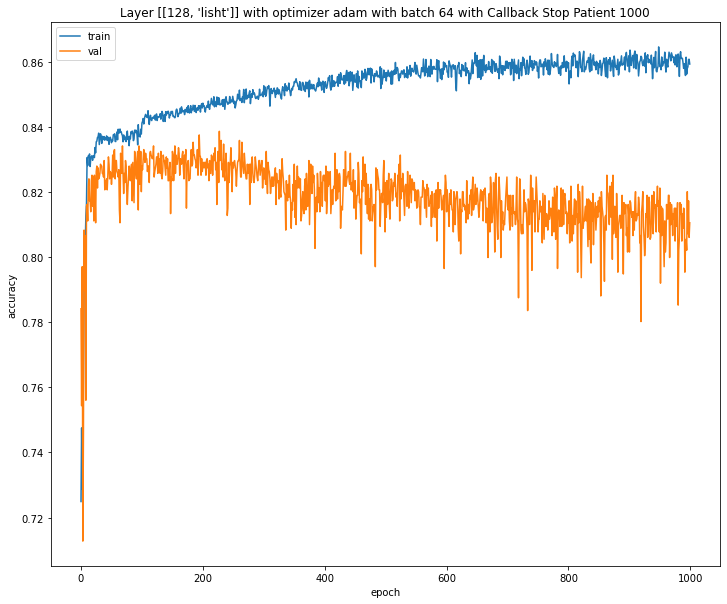

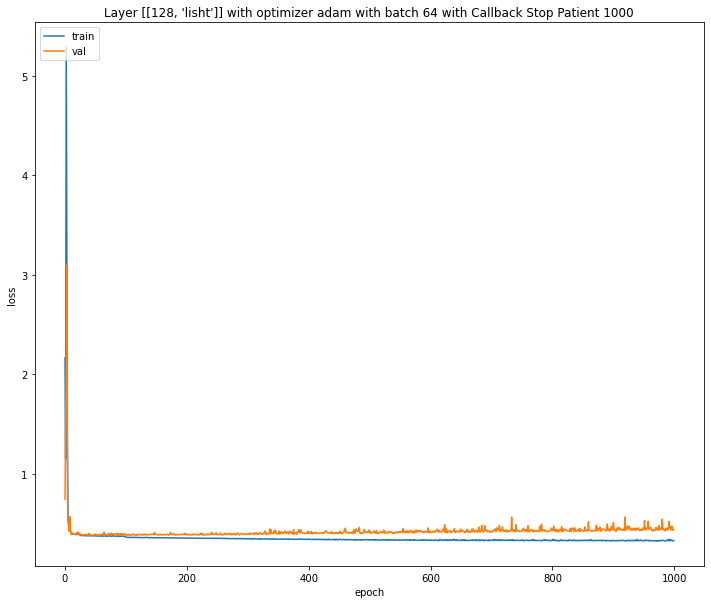

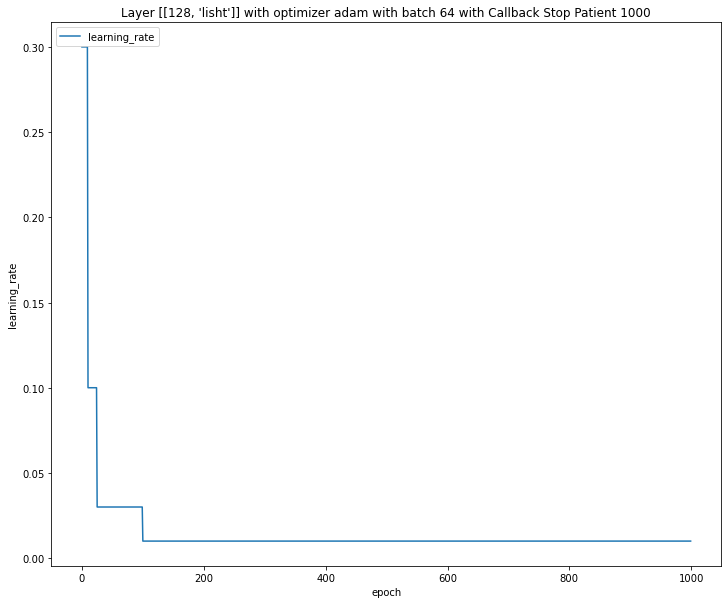

--- ANN with hidden layers [[128, 'lisht']], batch size 14232, epoch size 1000, optimizer adam  ---
[128, 'lisht']
[[[16, 'lisht']], [[128, 'lisht']], [[128, 'lisht'], [128, 'lisht']], [[128, 'swish'], [128, 'swish']]]
Epoch 1/1000


C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 165ms/step - loss: 0.7259 - accuracy: 0.5131 - val_loss: 10.1934 - val_accuracy: 0.5059
Epoch 2/1000
1/1 [==============================] - 0s 66ms/step - loss: 11.2724 - accuracy: 0.4967 - val_loss: 2.1957 - val_accuracy: 0.5155
Epoch 3/1000
1/1 [==============================] - 0s 66ms/step - loss: 2.7234 - accuracy: 0.5080 - val_loss: 4.5652 - val_accuracy: 0.5020


C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


Epoch 4/1000
1/1 [==============================] - 0s 76ms/step - loss: 4.6396 - accuracy: 0.5121 - val_loss: 2.5686 - val_accuracy: 0.5655
Epoch 5/1000
1/1 [==============================] - 0s 71ms/step - loss: 3.1290 - accuracy: 0.5706 - val_loss: 3.4135 - val_accuracy: 0.5700
Epoch 6/1000
1/1 [==============================] - 0s 69ms/step - loss: 4.3410 - accuracy: 0.5666 - val_loss: 1.7995 - val_accuracy: 0.7077
Epoch 7/1000
1/1 [==============================] - 0s 73ms/step - loss: 2.8009 - accuracy: 0.7101 - val_loss: 2.8054 - val_accuracy: 0.7352
Epoch 8/1000
1/1 [==============================] - 0s 58ms/step - loss: 3.8278 - accuracy: 0.7302 - val_loss: 1.9181 - val_accuracy: 0.7431
Epoch 9/1000
1/1 [==============================] - 0s 58ms/step - loss: 2.9716 - accuracy: 0.7338 - val_loss: 1.8179 - val_accuracy: 0.7752
Epoch 10/1000
1/1 [==============================] - 0s 111ms/step - loss: 2.6579 - accuracy: 0.7738 - val_loss: 1.7543 - val_accuracy: 0.7892
Epoch 11/10

Epoch 62/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.4202 - accuracy: 0.8212 - val_loss: 0.4346 - val_accuracy: 0.8100
Epoch 63/1000
1/1 [==============================] - 0s 61ms/step - loss: 0.4213 - accuracy: 0.8212 - val_loss: 0.4342 - val_accuracy: 0.8117
Epoch 64/1000
1/1 [==============================] - 0s 61ms/step - loss: 0.4187 - accuracy: 0.8210 - val_loss: 0.4371 - val_accuracy: 0.8111
Epoch 65/1000
1/1 [==============================] - 0s 60ms/step - loss: 0.4168 - accuracy: 0.8189 - val_loss: 0.4370 - val_accuracy: 0.8094
Epoch 66/1000
1/1 [==============================] - 0s 73ms/step - loss: 0.4163 - accuracy: 0.8185 - val_loss: 0.4307 - val_accuracy: 0.8106
Epoch 67/1000
1/1 [==============================] - 0s 90ms/step - loss: 0.4154 - accuracy: 0.8192 - val_loss: 0.4289 - val_accuracy: 0.8089
Epoch 68/1000
1/1 [==============================] - 0s 69ms/step - loss: 0.4140 - accuracy: 0.8201 - val_loss: 0.4311 - val_accuracy: 0.8139
Epoch 

1/1 [==============================] - 0s 85ms/step - loss: 0.3888 - accuracy: 0.8323 - val_loss: 0.4082 - val_accuracy: 0.8173
Epoch 120/1000
1/1 [==============================] - 0s 85ms/step - loss: 0.3887 - accuracy: 0.8325 - val_loss: 0.4080 - val_accuracy: 0.8173
Epoch 121/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.3886 - accuracy: 0.8326 - val_loss: 0.4078 - val_accuracy: 0.8173
Epoch 122/1000
1/1 [==============================] - 0s 65ms/step - loss: 0.3885 - accuracy: 0.8326 - val_loss: 0.4078 - val_accuracy: 0.8173
Epoch 123/1000
1/1 [==============================] - 0s 91ms/step - loss: 0.3884 - accuracy: 0.8326 - val_loss: 0.4078 - val_accuracy: 0.8179
Epoch 124/1000
1/1 [==============================] - 0s 96ms/step - loss: 0.3883 - accuracy: 0.8327 - val_loss: 0.4077 - val_accuracy: 0.8184
Epoch 125/1000
1/1 [==============================] - 0s 78ms/step - loss: 0.3882 - accuracy: 0.8327 - val_loss: 0.4076 - val_accuracy: 0.8179
Epoch 126/1000

1/1 [==============================] - 0s 77ms/step - loss: 0.3835 - accuracy: 0.8352 - val_loss: 0.4038 - val_accuracy: 0.8173
Epoch 177/1000
1/1 [==============================] - 0s 78ms/step - loss: 0.3834 - accuracy: 0.8353 - val_loss: 0.4037 - val_accuracy: 0.8179
Epoch 178/1000
1/1 [==============================] - 0s 77ms/step - loss: 0.3834 - accuracy: 0.8354 - val_loss: 0.4037 - val_accuracy: 0.8184
Epoch 179/1000
1/1 [==============================] - 0s 69ms/step - loss: 0.3833 - accuracy: 0.8354 - val_loss: 0.4036 - val_accuracy: 0.8196
Epoch 180/1000
1/1 [==============================] - 0s 83ms/step - loss: 0.3832 - accuracy: 0.8355 - val_loss: 0.4035 - val_accuracy: 0.8196
Epoch 181/1000
1/1 [==============================] - 0s 67ms/step - loss: 0.3831 - accuracy: 0.8357 - val_loss: 0.4035 - val_accuracy: 0.8196
Epoch 182/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.3830 - accuracy: 0.8358 - val_loss: 0.4034 - val_accuracy: 0.8196
Epoch 183/1000

1/1 [==============================] - 0s 58ms/step - loss: 0.3793 - accuracy: 0.8380 - val_loss: 0.4008 - val_accuracy: 0.8207
Epoch 234/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.3792 - accuracy: 0.8378 - val_loss: 0.4008 - val_accuracy: 0.8212
Epoch 235/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.3792 - accuracy: 0.8377 - val_loss: 0.4007 - val_accuracy: 0.8212
Epoch 236/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.3791 - accuracy: 0.8378 - val_loss: 0.4007 - val_accuracy: 0.8212
Epoch 237/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.3790 - accuracy: 0.8379 - val_loss: 0.4006 - val_accuracy: 0.8212
Epoch 238/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.3790 - accuracy: 0.8379 - val_loss: 0.4006 - val_accuracy: 0.8212
Epoch 239/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.3789 - accuracy: 0.8379 - val_loss: 0.4005 - val_accuracy: 0.8212
Epoch 240/1000

1/1 [==============================] - 0s 55ms/step - loss: 0.3758 - accuracy: 0.8381 - val_loss: 0.3986 - val_accuracy: 0.8235
Epoch 291/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.3758 - accuracy: 0.8380 - val_loss: 0.3985 - val_accuracy: 0.8235
Epoch 292/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.3757 - accuracy: 0.8380 - val_loss: 0.3985 - val_accuracy: 0.8235
Epoch 293/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.3756 - accuracy: 0.8380 - val_loss: 0.3985 - val_accuracy: 0.8235
Epoch 294/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.3756 - accuracy: 0.8380 - val_loss: 0.3984 - val_accuracy: 0.8235
Epoch 295/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.3755 - accuracy: 0.8380 - val_loss: 0.3984 - val_accuracy: 0.8235
Epoch 296/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.3755 - accuracy: 0.8382 - val_loss: 0.3984 - val_accuracy: 0.8229
Epoch 297/1000

1/1 [==============================] - 0s 63ms/step - loss: 0.3728 - accuracy: 0.8391 - val_loss: 0.3969 - val_accuracy: 0.8229
Epoch 348/1000
1/1 [==============================] - 0s 64ms/step - loss: 0.3728 - accuracy: 0.8391 - val_loss: 0.3968 - val_accuracy: 0.8229
Epoch 349/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.3727 - accuracy: 0.8392 - val_loss: 0.3968 - val_accuracy: 0.8235
Epoch 350/1000
1/1 [==============================] - 0s 59ms/step - loss: 0.3727 - accuracy: 0.8392 - val_loss: 0.3968 - val_accuracy: 0.8235
Epoch 351/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.3726 - accuracy: 0.8392 - val_loss: 0.3968 - val_accuracy: 0.8241
Epoch 352/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.3726 - accuracy: 0.8393 - val_loss: 0.3967 - val_accuracy: 0.8241
Epoch 353/1000
1/1 [==============================] - 0s 93ms/step - loss: 0.3725 - accuracy: 0.8393 - val_loss: 0.3967 - val_accuracy: 0.8241
Epoch 354/1000

1/1 [==============================] - 0s 54ms/step - loss: 0.3702 - accuracy: 0.8401 - val_loss: 0.3957 - val_accuracy: 0.8246
Epoch 405/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.3702 - accuracy: 0.8401 - val_loss: 0.3957 - val_accuracy: 0.8246
Epoch 406/1000
1/1 [==============================] - 0s 67ms/step - loss: 0.3701 - accuracy: 0.8402 - val_loss: 0.3956 - val_accuracy: 0.8246
Epoch 407/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.3701 - accuracy: 0.8402 - val_loss: 0.3956 - val_accuracy: 0.8246
Epoch 408/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.3700 - accuracy: 0.8402 - val_loss: 0.3956 - val_accuracy: 0.8246
Epoch 409/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.3700 - accuracy: 0.8401 - val_loss: 0.3956 - val_accuracy: 0.8246
Epoch 410/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.3700 - accuracy: 0.8401 - val_loss: 0.3956 - val_accuracy: 0.8246
Epoch 411/1000

1/1 [==============================] - 0s 58ms/step - loss: 0.3679 - accuracy: 0.8414 - val_loss: 0.3948 - val_accuracy: 0.8263
Epoch 462/1000
1/1 [==============================] - 0s 81ms/step - loss: 0.3678 - accuracy: 0.8413 - val_loss: 0.3948 - val_accuracy: 0.8263
Epoch 463/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.3678 - accuracy: 0.8413 - val_loss: 0.3948 - val_accuracy: 0.8263
Epoch 464/1000
1/1 [==============================] - 0s 78ms/step - loss: 0.3677 - accuracy: 0.8413 - val_loss: 0.3948 - val_accuracy: 0.8263
Epoch 465/1000
1/1 [==============================] - 0s 66ms/step - loss: 0.3677 - accuracy: 0.8413 - val_loss: 0.3948 - val_accuracy: 0.8263
Epoch 466/1000
1/1 [==============================] - 0s 59ms/step - loss: 0.3677 - accuracy: 0.8413 - val_loss: 0.3947 - val_accuracy: 0.8263
Epoch 467/1000
1/1 [==============================] - 0s 60ms/step - loss: 0.3676 - accuracy: 0.8414 - val_loss: 0.3947 - val_accuracy: 0.8263
Epoch 468/1000

1/1 [==============================] - 0s 57ms/step - loss: 0.3657 - accuracy: 0.8420 - val_loss: 0.3942 - val_accuracy: 0.8257
Epoch 519/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.3657 - accuracy: 0.8421 - val_loss: 0.3942 - val_accuracy: 0.8257
Epoch 520/1000
1/1 [==============================] - 0s 61ms/step - loss: 0.3657 - accuracy: 0.8420 - val_loss: 0.3942 - val_accuracy: 0.8257
Epoch 521/1000
1/1 [==============================] - 0s 62ms/step - loss: 0.3656 - accuracy: 0.8420 - val_loss: 0.3942 - val_accuracy: 0.8257
Epoch 522/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.3656 - accuracy: 0.8420 - val_loss: 0.3942 - val_accuracy: 0.8257
Epoch 523/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.3655 - accuracy: 0.8420 - val_loss: 0.3942 - val_accuracy: 0.8257
Epoch 524/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.3655 - accuracy: 0.8421 - val_loss: 0.3942 - val_accuracy: 0.8257
Epoch 525/1000

1/1 [==============================] - 0s 57ms/step - loss: 0.3638 - accuracy: 0.8423 - val_loss: 0.3938 - val_accuracy: 0.8252
Epoch 576/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.3637 - accuracy: 0.8423 - val_loss: 0.3938 - val_accuracy: 0.8252
Epoch 577/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.3637 - accuracy: 0.8423 - val_loss: 0.3938 - val_accuracy: 0.8252
Epoch 578/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.3637 - accuracy: 0.8423 - val_loss: 0.3938 - val_accuracy: 0.8252
Epoch 579/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.3636 - accuracy: 0.8423 - val_loss: 0.3938 - val_accuracy: 0.8246
Epoch 580/1000
1/1 [==============================] - 0s 60ms/step - loss: 0.3636 - accuracy: 0.8423 - val_loss: 0.3938 - val_accuracy: 0.8246
Epoch 581/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.3636 - accuracy: 0.8423 - val_loss: 0.3938 - val_accuracy: 0.8246
Epoch 582/1000

1/1 [==============================] - 0s 80ms/step - loss: 0.3620 - accuracy: 0.8431 - val_loss: 0.3936 - val_accuracy: 0.8252
Epoch 633/1000
1/1 [==============================] - 0s 67ms/step - loss: 0.3619 - accuracy: 0.8431 - val_loss: 0.3936 - val_accuracy: 0.8252
Epoch 634/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.3619 - accuracy: 0.8431 - val_loss: 0.3936 - val_accuracy: 0.8252
Epoch 635/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.3619 - accuracy: 0.8431 - val_loss: 0.3936 - val_accuracy: 0.8252
Epoch 636/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.3618 - accuracy: 0.8430 - val_loss: 0.3936 - val_accuracy: 0.8252
Epoch 637/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.3618 - accuracy: 0.8431 - val_loss: 0.3936 - val_accuracy: 0.8252
Epoch 638/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.3618 - accuracy: 0.8431 - val_loss: 0.3936 - val_accuracy: 0.8252
Epoch 639/1000

1/1 [==============================] - 0s 51ms/step - loss: 0.3603 - accuracy: 0.8439 - val_loss: 0.3935 - val_accuracy: 0.8263
Epoch 690/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.3603 - accuracy: 0.8439 - val_loss: 0.3935 - val_accuracy: 0.8263
Epoch 691/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.3602 - accuracy: 0.8439 - val_loss: 0.3935 - val_accuracy: 0.8263
Epoch 692/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.3602 - accuracy: 0.8440 - val_loss: 0.3935 - val_accuracy: 0.8263
Epoch 693/1000
1/1 [==============================] - 0s 59ms/step - loss: 0.3602 - accuracy: 0.8440 - val_loss: 0.3935 - val_accuracy: 0.8263
Epoch 694/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.3601 - accuracy: 0.8440 - val_loss: 0.3935 - val_accuracy: 0.8263
Epoch 695/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.3601 - accuracy: 0.8441 - val_loss: 0.3935 - val_accuracy: 0.8263
Epoch 696/1000

C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


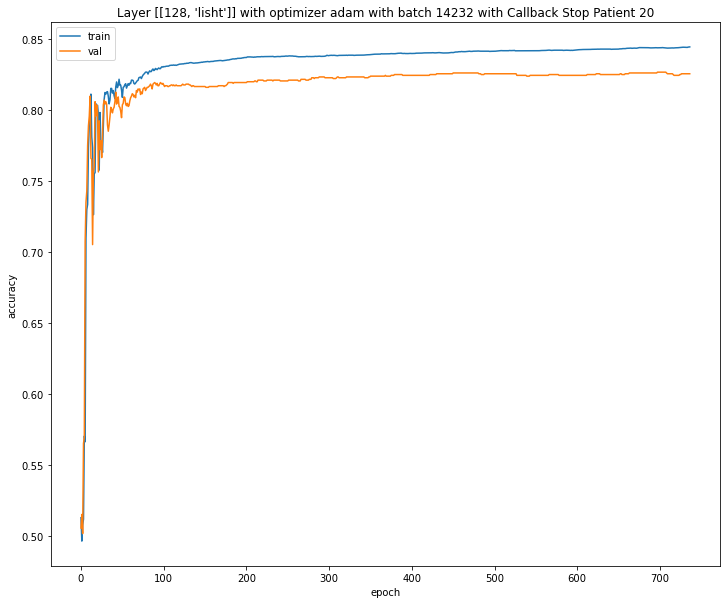

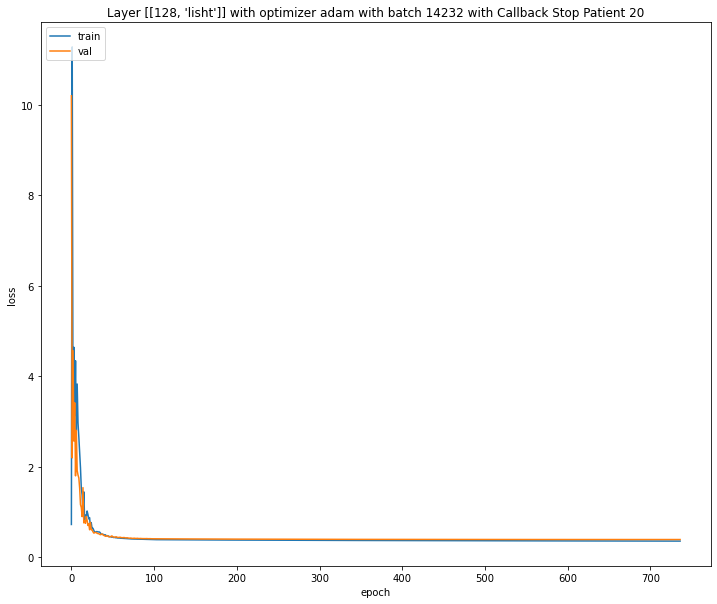

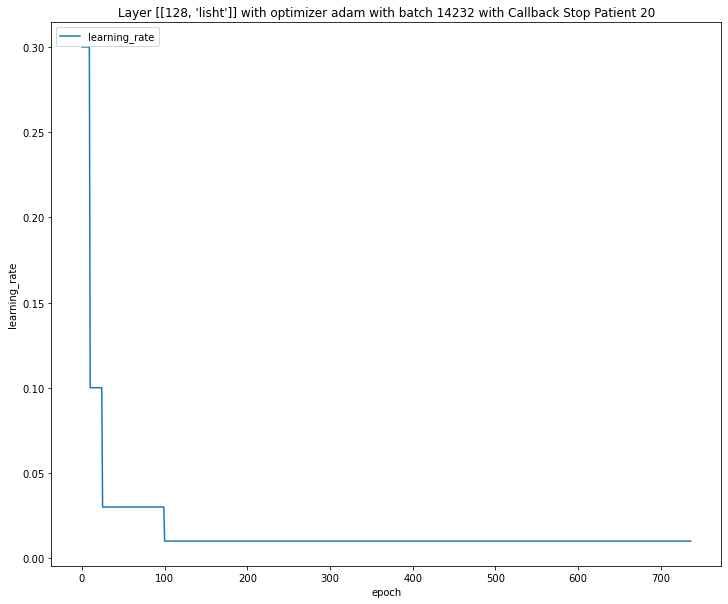

--- ANN with hidden layers [[128, 'lisht']], batch size 14232, epoch size 1000, optimizer adam  ---
[128, 'lisht']
[[[16, 'lisht']], [[128, 'lisht']], [[128, 'lisht'], [128, 'lisht']], [[128, 'swish'], [128, 'swish']]]
Epoch 1/1000
1/1 [==============================] - 0s 115ms/step - loss: 0.7292 - accuracy: 0.4261 - val_loss: 11.1157 - val_accuracy: 0.5087
Epoch 2/1000
1/1 [==============================] - ETA: 0s - loss: 11.2683 - accuracy: 0.4967

C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(
C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 53ms/step - loss: 11.2683 - accuracy: 0.4967 - val_loss: 2.8489 - val_accuracy: 0.5087
Epoch 3/1000
1/1 [==============================] - 0s 56ms/step - loss: 2.9026 - accuracy: 0.4967 - val_loss: 1.7201 - val_accuracy: 0.6273
Epoch 4/1000
1/1 [==============================] - 0s 61ms/step - loss: 1.8144 - accuracy: 0.6322 - val_loss: 1.1082 - val_accuracy: 0.6352
Epoch 5/1000
1/1 [==============================] - 0s 69ms/step - loss: 1.1785 - accuracy: 0.6316 - val_loss: 1.2284 - val_accuracy: 0.6886
Epoch 6/1000
1/1 [==============================] - 0s 61ms/step - loss: 1.3017 - accuracy: 0.6788 - val_loss: 1.3700 - val_accuracy: 0.7442
Epoch 7/1000
1/1 [==============================] - 0s 56ms/step - loss: 1.4319 - accuracy: 0.7337 - val_loss: 3.5278 - val_accuracy: 0.5638
Epoch 8/1000
1/1 [==============================] - 0s 54ms/step - loss: 3.6679 - accuracy: 0.5497 - val_loss: 2.3829 - val_accuracy: 0.6374
Epoch 9/1000
1/1 [=======

Epoch 60/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.4425 - accuracy: 0.8195 - val_loss: 0.4431 - val_accuracy: 0.8139
Epoch 61/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.4471 - accuracy: 0.8177 - val_loss: 0.4353 - val_accuracy: 0.8179
Epoch 62/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.4376 - accuracy: 0.8234 - val_loss: 0.4332 - val_accuracy: 0.8207
Epoch 63/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.4310 - accuracy: 0.8232 - val_loss: 0.4421 - val_accuracy: 0.8162
Epoch 64/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.4355 - accuracy: 0.8186 - val_loss: 0.4381 - val_accuracy: 0.8179
Epoch 65/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.4318 - accuracy: 0.8197 - val_loss: 0.4256 - val_accuracy: 0.8201
Epoch 66/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.4233 - accuracy: 0.8253 - val_loss: 0.4235 - val_accuracy: 0.8212
Epoch 

1/1 [==============================] - 0s 51ms/step - loss: 0.3883 - accuracy: 0.8332 - val_loss: 0.3981 - val_accuracy: 0.8286
Epoch 118/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.3882 - accuracy: 0.8330 - val_loss: 0.3981 - val_accuracy: 0.8286
Epoch 119/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.3881 - accuracy: 0.8332 - val_loss: 0.3981 - val_accuracy: 0.8286
Epoch 120/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.3881 - accuracy: 0.8333 - val_loss: 0.3981 - val_accuracy: 0.8291
Epoch 121/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.3880 - accuracy: 0.8335 - val_loss: 0.3980 - val_accuracy: 0.8286
Epoch 122/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.3879 - accuracy: 0.8335 - val_loss: 0.3979 - val_accuracy: 0.8286
Epoch 123/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.3878 - accuracy: 0.8336 - val_loss: 0.3977 - val_accuracy: 0.8280
Epoch 124/1000

1/1 [==============================] - 0s 60ms/step - loss: 0.3845 - accuracy: 0.8336 - val_loss: 0.3950 - val_accuracy: 0.8280
Epoch 175/1000
1/1 [==============================] - 0s 62ms/step - loss: 0.3845 - accuracy: 0.8335 - val_loss: 0.3949 - val_accuracy: 0.8280
Epoch 176/1000
1/1 [==============================] - 0s 64ms/step - loss: 0.3844 - accuracy: 0.8335 - val_loss: 0.3949 - val_accuracy: 0.8280
Epoch 177/1000
1/1 [==============================] - 0s 61ms/step - loss: 0.3844 - accuracy: 0.8335 - val_loss: 0.3949 - val_accuracy: 0.8280
Epoch 178/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.3843 - accuracy: 0.8335 - val_loss: 0.3948 - val_accuracy: 0.8280
Epoch 179/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.3842 - accuracy: 0.8335 - val_loss: 0.3948 - val_accuracy: 0.8274
Epoch 180/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.3842 - accuracy: 0.8335 - val_loss: 0.3947 - val_accuracy: 0.8274
Epoch 181/1000

1/1 [==============================] - 0s 52ms/step - loss: 0.3817 - accuracy: 0.8350 - val_loss: 0.3932 - val_accuracy: 0.8291
Epoch 232/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.3817 - accuracy: 0.8349 - val_loss: 0.3931 - val_accuracy: 0.8291
Epoch 233/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.3816 - accuracy: 0.8350 - val_loss: 0.3931 - val_accuracy: 0.8291
Epoch 234/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.3816 - accuracy: 0.8350 - val_loss: 0.3931 - val_accuracy: 0.8291
Epoch 235/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.3815 - accuracy: 0.8350 - val_loss: 0.3931 - val_accuracy: 0.8291
Epoch 236/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.3815 - accuracy: 0.8352 - val_loss: 0.3931 - val_accuracy: 0.8291
Epoch 237/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.3815 - accuracy: 0.8351 - val_loss: 0.3930 - val_accuracy: 0.8286
Epoch 238/1000

1/1 [==============================] - 0s 52ms/step - loss: 0.3794 - accuracy: 0.8362 - val_loss: 0.3921 - val_accuracy: 0.8291
Epoch 289/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.3794 - accuracy: 0.8362 - val_loss: 0.3921 - val_accuracy: 0.8291
Epoch 290/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.3794 - accuracy: 0.8362 - val_loss: 0.3921 - val_accuracy: 0.8291
Epoch 291/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.3793 - accuracy: 0.8362 - val_loss: 0.3921 - val_accuracy: 0.8291
Epoch 292/1000
1/1 [==============================] - 0s 49ms/step - loss: 0.3793 - accuracy: 0.8363 - val_loss: 0.3921 - val_accuracy: 0.8291
Epoch 293/1000
1/1 [==============================] - 0s 49ms/step - loss: 0.3793 - accuracy: 0.8362 - val_loss: 0.3921 - val_accuracy: 0.8291
Epoch 294/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.3792 - accuracy: 0.8364 - val_loss: 0.3921 - val_accuracy: 0.8291
Epoch 295/1000

1/1 [==============================] - 0s 50ms/step - loss: 0.3775 - accuracy: 0.8366 - val_loss: 0.3917 - val_accuracy: 0.8286
Epoch 346/1000
1/1 [==============================] - 0s 49ms/step - loss: 0.3775 - accuracy: 0.8365 - val_loss: 0.3917 - val_accuracy: 0.8286
Epoch 347/1000
1/1 [==============================] - 0s 49ms/step - loss: 0.3775 - accuracy: 0.8364 - val_loss: 0.3917 - val_accuracy: 0.8286
Epoch 348/1000
1/1 [==============================] - 0s 49ms/step - loss: 0.3774 - accuracy: 0.8364 - val_loss: 0.3917 - val_accuracy: 0.8286
Epoch 349/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.3774 - accuracy: 0.8364 - val_loss: 0.3916 - val_accuracy: 0.8286
Epoch 350/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.3774 - accuracy: 0.8364 - val_loss: 0.3916 - val_accuracy: 0.8286
Epoch 351/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.3773 - accuracy: 0.8364 - val_loss: 0.3916 - val_accuracy: 0.8286
Epoch 352/1000

1/1 [==============================] - 0s 57ms/step - loss: 0.3758 - accuracy: 0.8375 - val_loss: 0.3915 - val_accuracy: 0.8308
Epoch 403/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.3758 - accuracy: 0.8375 - val_loss: 0.3915 - val_accuracy: 0.8308
Epoch 404/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.3758 - accuracy: 0.8375 - val_loss: 0.3915 - val_accuracy: 0.8314
Epoch 405/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.3757 - accuracy: 0.8375 - val_loss: 0.3915 - val_accuracy: 0.8314
Epoch 406/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.3757 - accuracy: 0.8375 - val_loss: 0.3915 - val_accuracy: 0.8314
Epoch 407/1000
1/1 [==============================] - 0s 65ms/step - loss: 0.3757 - accuracy: 0.8375 - val_loss: 0.3914 - val_accuracy: 0.8314
Epoch 408/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.3757 - accuracy: 0.8375 - val_loss: 0.3914 - val_accuracy: 0.8314
Epoch 409/1000

1/1 [==============================] - 0s 56ms/step - loss: 0.3743 - accuracy: 0.8381 - val_loss: 0.3913 - val_accuracy: 0.8325
Epoch 460/1000
1/1 [==============================] - 0s 65ms/step - loss: 0.3743 - accuracy: 0.8381 - val_loss: 0.3913 - val_accuracy: 0.8331
Epoch 461/1000
1/1 [==============================] - 0s 62ms/step - loss: 0.3742 - accuracy: 0.8381 - val_loss: 0.3913 - val_accuracy: 0.8331
Epoch 462/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.3742 - accuracy: 0.8381 - val_loss: 0.3913 - val_accuracy: 0.8331
Epoch 463/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.3742 - accuracy: 0.8381 - val_loss: 0.3913 - val_accuracy: 0.8331
Epoch 464/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.3742 - accuracy: 0.8381 - val_loss: 0.3913 - val_accuracy: 0.8331
Epoch 465/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.3741 - accuracy: 0.8382 - val_loss: 0.3913 - val_accuracy: 0.8331
Epoch 466/1000

1/1 [==============================] - 0s 56ms/step - loss: 0.3728 - accuracy: 0.8387 - val_loss: 0.3912 - val_accuracy: 0.8336
Epoch 517/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.3728 - accuracy: 0.8387 - val_loss: 0.3912 - val_accuracy: 0.8336
Epoch 518/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.3728 - accuracy: 0.8387 - val_loss: 0.3912 - val_accuracy: 0.8336
Epoch 519/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.3728 - accuracy: 0.8387 - val_loss: 0.3912 - val_accuracy: 0.8336
Epoch 520/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.3727 - accuracy: 0.8387 - val_loss: 0.3912 - val_accuracy: 0.8336
Epoch 521/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.3727 - accuracy: 0.8387 - val_loss: 0.3912 - val_accuracy: 0.8336
Epoch 522/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.3727 - accuracy: 0.8387 - val_loss: 0.3912 - val_accuracy: 0.8336
Epoch 523/1000

1/1 [==============================] - 0s 56ms/step - loss: 0.3714 - accuracy: 0.8390 - val_loss: 0.3910 - val_accuracy: 0.8336
Epoch 574/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.3714 - accuracy: 0.8390 - val_loss: 0.3910 - val_accuracy: 0.8336
Epoch 575/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.3714 - accuracy: 0.8390 - val_loss: 0.3910 - val_accuracy: 0.8331
Epoch 576/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.3714 - accuracy: 0.8391 - val_loss: 0.3910 - val_accuracy: 0.8331
Epoch 577/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.3714 - accuracy: 0.8392 - val_loss: 0.3909 - val_accuracy: 0.8331
Epoch 578/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.3713 - accuracy: 0.8392 - val_loss: 0.3909 - val_accuracy: 0.8331
Epoch 579/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.3713 - accuracy: 0.8392 - val_loss: 0.3909 - val_accuracy: 0.8331
Epoch 580/1000

1/1 [==============================] - 0s 74ms/step - loss: 0.3701 - accuracy: 0.8407 - val_loss: 0.3906 - val_accuracy: 0.8331
Epoch 631/1000
1/1 [==============================] - 0s 68ms/step - loss: 0.3701 - accuracy: 0.8407 - val_loss: 0.3906 - val_accuracy: 0.8331
Epoch 632/1000
1/1 [==============================] - 0s 67ms/step - loss: 0.3701 - accuracy: 0.8408 - val_loss: 0.3906 - val_accuracy: 0.8331
Epoch 633/1000
1/1 [==============================] - 0s 62ms/step - loss: 0.3700 - accuracy: 0.8408 - val_loss: 0.3906 - val_accuracy: 0.8331
Epoch 634/1000
1/1 [==============================] - 0s 63ms/step - loss: 0.3700 - accuracy: 0.8409 - val_loss: 0.3906 - val_accuracy: 0.8331
Epoch 635/1000
1/1 [==============================] - 0s 62ms/step - loss: 0.3700 - accuracy: 0.8409 - val_loss: 0.3906 - val_accuracy: 0.8331
Epoch 636/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.3700 - accuracy: 0.8409 - val_loss: 0.3906 - val_accuracy: 0.8331
Epoch 637/1000

1/1 [==============================] - 0s 54ms/step - loss: 0.3688 - accuracy: 0.8413 - val_loss: 0.3902 - val_accuracy: 0.8319
Epoch 688/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.3688 - accuracy: 0.8413 - val_loss: 0.3902 - val_accuracy: 0.8319
Epoch 689/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.3688 - accuracy: 0.8414 - val_loss: 0.3902 - val_accuracy: 0.8319
Epoch 690/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.3688 - accuracy: 0.8414 - val_loss: 0.3902 - val_accuracy: 0.8319
Epoch 691/1000
1/1 [==============================] - 0s 62ms/step - loss: 0.3687 - accuracy: 0.8414 - val_loss: 0.3902 - val_accuracy: 0.8319
Epoch 692/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.3687 - accuracy: 0.8413 - val_loss: 0.3902 - val_accuracy: 0.8319
Epoch 693/1000
1/1 [==============================] - 0s 64ms/step - loss: 0.3687 - accuracy: 0.8413 - val_loss: 0.3902 - val_accuracy: 0.8319
Epoch 694/1000

1/1 [==============================] - 0s 58ms/step - loss: 0.3676 - accuracy: 0.8419 - val_loss: 0.3899 - val_accuracy: 0.8325
Epoch 745/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.3676 - accuracy: 0.8419 - val_loss: 0.3898 - val_accuracy: 0.8325
Epoch 746/1000
1/1 [==============================] - 0s 59ms/step - loss: 0.3676 - accuracy: 0.8418 - val_loss: 0.3898 - val_accuracy: 0.8325
Epoch 747/1000
1/1 [==============================] - 0s 60ms/step - loss: 0.3675 - accuracy: 0.8418 - val_loss: 0.3898 - val_accuracy: 0.8325
Epoch 748/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.3675 - accuracy: 0.8418 - val_loss: 0.3898 - val_accuracy: 0.8325
Epoch 749/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.3675 - accuracy: 0.8418 - val_loss: 0.3898 - val_accuracy: 0.8325
Epoch 750/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.3675 - accuracy: 0.8416 - val_loss: 0.3898 - val_accuracy: 0.8325
Epoch 751/1000

1/1 [==============================] - 0s 68ms/step - loss: 0.3664 - accuracy: 0.8420 - val_loss: 0.3896 - val_accuracy: 0.8336
Epoch 802/1000
1/1 [==============================] - 0s 64ms/step - loss: 0.3664 - accuracy: 0.8420 - val_loss: 0.3896 - val_accuracy: 0.8336
Epoch 803/1000
1/1 [==============================] - 0s 67ms/step - loss: 0.3664 - accuracy: 0.8420 - val_loss: 0.3895 - val_accuracy: 0.8336
Epoch 804/1000
1/1 [==============================] - 0s 61ms/step - loss: 0.3664 - accuracy: 0.8420 - val_loss: 0.3895 - val_accuracy: 0.8336
Epoch 805/1000
1/1 [==============================] - 0s 66ms/step - loss: 0.3664 - accuracy: 0.8420 - val_loss: 0.3895 - val_accuracy: 0.8336
Epoch 806/1000
1/1 [==============================] - 0s 62ms/step - loss: 0.3663 - accuracy: 0.8420 - val_loss: 0.3895 - val_accuracy: 0.8336
Epoch 807/1000
1/1 [==============================] - 0s 62ms/step - loss: 0.3663 - accuracy: 0.8421 - val_loss: 0.3895 - val_accuracy: 0.8336
Epoch 808/1000

1/1 [==============================] - 0s 59ms/step - loss: 0.3653 - accuracy: 0.8419 - val_loss: 0.3894 - val_accuracy: 0.8342
Epoch 859/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.3653 - accuracy: 0.8419 - val_loss: 0.3894 - val_accuracy: 0.8342
Epoch 860/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.3653 - accuracy: 0.8419 - val_loss: 0.3894 - val_accuracy: 0.8342
Epoch 861/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.3653 - accuracy: 0.8419 - val_loss: 0.3894 - val_accuracy: 0.8342
Epoch 862/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.3652 - accuracy: 0.8419 - val_loss: 0.3893 - val_accuracy: 0.8342
Epoch 863/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.3652 - accuracy: 0.8419 - val_loss: 0.3893 - val_accuracy: 0.8342
Epoch 864/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.3652 - accuracy: 0.8419 - val_loss: 0.3893 - val_accuracy: 0.8342
Epoch 865/1000

1/1 [==============================] - 0s 58ms/step - loss: 0.3642 - accuracy: 0.8423 - val_loss: 0.3893 - val_accuracy: 0.8331
Epoch 916/1000
1/1 [==============================] - 0s 60ms/step - loss: 0.3642 - accuracy: 0.8423 - val_loss: 0.3893 - val_accuracy: 0.8331
Epoch 917/1000
1/1 [==============================] - 0s 64ms/step - loss: 0.3642 - accuracy: 0.8423 - val_loss: 0.3893 - val_accuracy: 0.8331
Epoch 918/1000
1/1 [==============================] - 0s 63ms/step - loss: 0.3642 - accuracy: 0.8423 - val_loss: 0.3892 - val_accuracy: 0.8331
Epoch 919/1000
1/1 [==============================] - 0s 62ms/step - loss: 0.3642 - accuracy: 0.8423 - val_loss: 0.3892 - val_accuracy: 0.8331
Epoch 920/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.3641 - accuracy: 0.8422 - val_loss: 0.3892 - val_accuracy: 0.8331
Epoch 921/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.3641 - accuracy: 0.8422 - val_loss: 0.3892 - val_accuracy: 0.8331
Epoch 922/1000

1/1 [==============================] - 0s 61ms/step - loss: 0.3632 - accuracy: 0.8420 - val_loss: 0.3892 - val_accuracy: 0.8314
Epoch 973/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.3632 - accuracy: 0.8420 - val_loss: 0.3892 - val_accuracy: 0.8314
Epoch 974/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.3632 - accuracy: 0.8420 - val_loss: 0.3892 - val_accuracy: 0.8314
Epoch 975/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.3631 - accuracy: 0.8420 - val_loss: 0.3892 - val_accuracy: 0.8314
Epoch 976/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.3631 - accuracy: 0.8420 - val_loss: 0.3892 - val_accuracy: 0.8314
Epoch 977/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.3631 - accuracy: 0.8420 - val_loss: 0.3892 - val_accuracy: 0.8314
Epoch 978/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.3631 - accuracy: 0.8423 - val_loss: 0.3892 - val_accuracy: 0.8314
Epoch 979/1000

C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


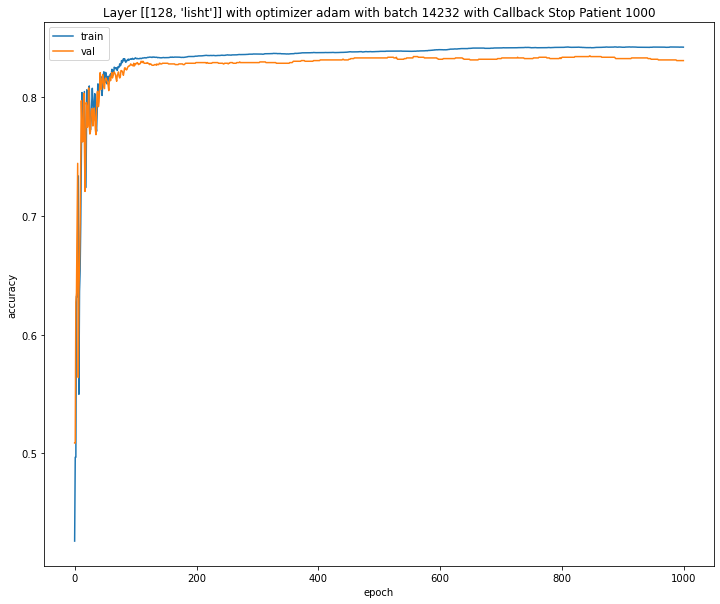

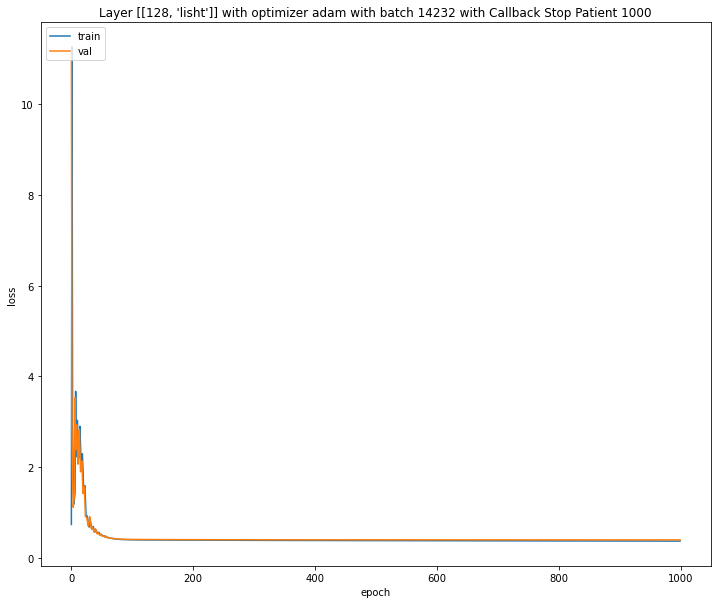

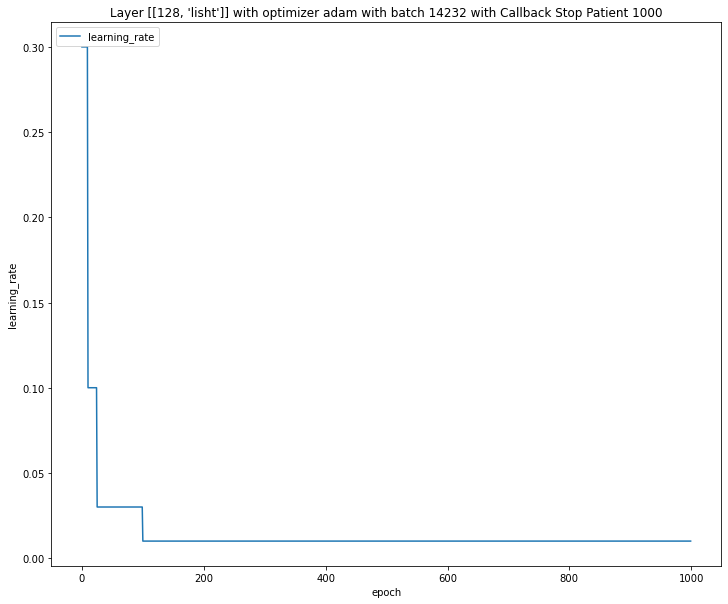

--- ANN with hidden layers [[128, 'lisht'], [128, 'lisht']], batch size 64, epoch size 1000, optimizer adam  ---
[128, 'lisht']
[[[16, 'lisht']], [[128, 'lisht']], [[128, 'lisht'], [128, 'lisht']], [[128, 'swish'], [128, 'swish']]]
[128, 'lisht']
[[[16, 'lisht']], [[128, 'lisht']], [[128, 'lisht'], [128, 'lisht']], [[128, 'swish'], [128, 'swish']]]
Epoch 1/1000
 12/223 [>.............................] - ETA: 2s - loss: 173.8084 - accuracy: 0.5013

C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


223/223 [==============================] - 3s 12ms/step - loss: 169.0396 - accuracy: 0.6594 - val_loss: 441.9643 - val_accuracy: 0.5087
Epoch 2/1000
  1/223 [..............................] - ETA: 2s - loss: 419.4402 - accuracy: 0.5312

C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


223/223 [==============================] - 3s 15ms/step - loss: 255.9233 - accuracy: 0.7155 - val_loss: 9.6880 - val_accuracy: 0.7937
Epoch 3/1000
223/223 [==============================] - 3s 12ms/step - loss: 9.3035 - accuracy: 0.7522 - val_loss: 2.1600 - val_accuracy: 0.7903
Epoch 4/1000
223/223 [==============================] - 3s 12ms/step - loss: 2.1652 - accuracy: 0.7542 - val_loss: 1.9491 - val_accuracy: 0.6970
Epoch 5/1000
223/223 [==============================] - ETA: 0s - loss: 1.6795 - accuracy: 0.76 - 3s 12ms/step - loss: 1.6644 - accuracy: 0.7630 - val_loss: 2.1588 - val_accuracy: 0.6374
Epoch 6/1000
223/223 [==============================] - 2s 10ms/step - loss: 1.2156 - accuracy: 0.7674 - val_loss: 0.7545 - val_accuracy: 0.8089
Epoch 7/1000
223/223 [==============================] - 3s 13ms/step - loss: 0.9790 - accuracy: 0.7689 - val_loss: 0.6112 - val_accuracy: 0.7684
Epoch 8/1000
223/223 [==============================] - 3s 12ms/step - loss: 0.7577 - accuracy: 0.7

C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


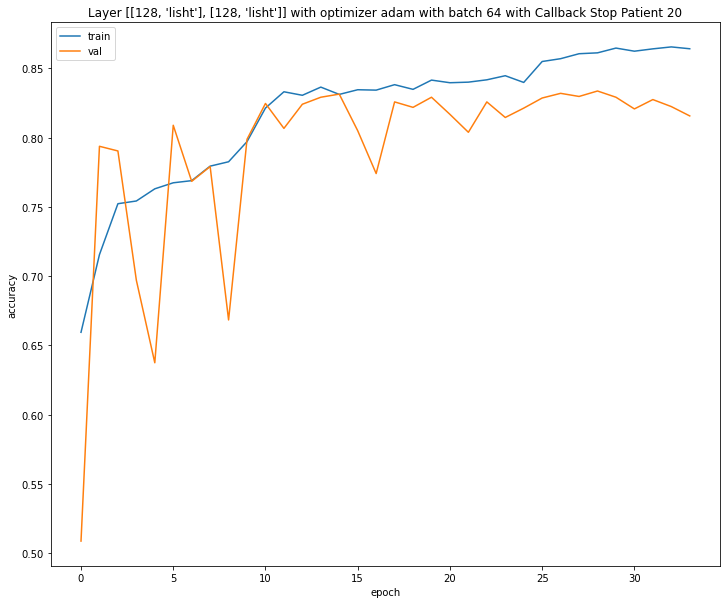

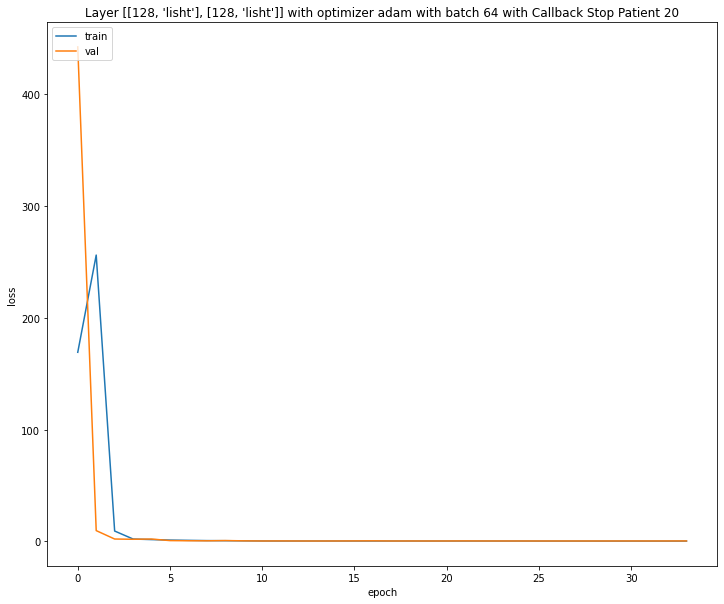

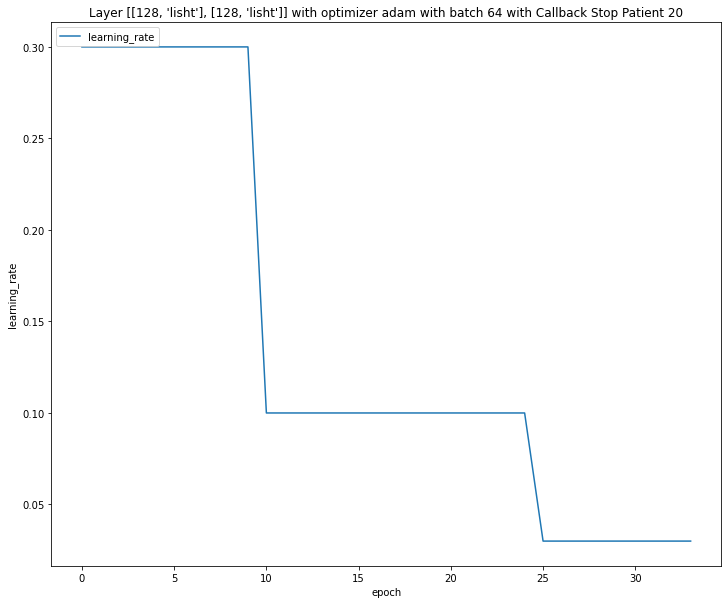

--- ANN with hidden layers [[128, 'lisht'], [128, 'lisht']], batch size 64, epoch size 1000, optimizer adam  ---
[128, 'lisht']
[[[16, 'lisht']], [[128, 'lisht']], [[128, 'lisht'], [128, 'lisht']], [[128, 'swish'], [128, 'swish']]]
[128, 'lisht']
[[[16, 'lisht']], [[128, 'lisht']], [[128, 'lisht'], [128, 'lisht']], [[128, 'swish'], [128, 'swish']]]
Epoch 1/1000
 12/223 [>.............................] - ETA: 2s - loss: 147.0276 - accuracy: 0.5208

C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


223/223 [==============================] - 3s 11ms/step - loss: 42.2749 - accuracy: 0.6769 - val_loss: 6.8055 - val_accuracy: 0.7870
Epoch 2/1000
  1/223 [..............................] - ETA: 2s - loss: 13.6445 - accuracy: 0.7031

C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


223/223 [==============================] - 2s 11ms/step - loss: 3.3776 - accuracy: 0.7537 - val_loss: 0.5079 - val_accuracy: 0.8106
Epoch 3/1000
223/223 [==============================] - 3s 11ms/step - loss: 0.5880 - accuracy: 0.7901 - val_loss: 0.4966 - val_accuracy: 0.8184
Epoch 4/1000
223/223 [==============================] - 3s 12ms/step - loss: 0.5914 - accuracy: 0.7896 - val_loss: 0.7082 - val_accuracy: 0.7459
Epoch 5/1000
223/223 [==============================] - 3s 12ms/step - loss: 0.5412 - accuracy: 0.7988 - val_loss: 0.4700 - val_accuracy: 0.7915
Epoch 6/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.4652 - accuracy: 0.8073 - val_loss: 0.4252 - val_accuracy: 0.8117
Epoch 7/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.4533 - accuracy: 0.8113 - val_loss: 0.4344 - val_accuracy: 0.8055
Epoch 8/1000
223/223 [==============================] - 3s 13ms/step - loss: 0.4450 - accuracy: 0.8122 - val_loss: 0.4086 - val_accuracy: 0.827

Epoch 58/1000
223/223 [==============================] - 3s 12ms/step - loss: 0.2972 - accuracy: 0.8709 - val_loss: 0.4595 - val_accuracy: 0.8094
Epoch 59/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.2959 - accuracy: 0.8754 - val_loss: 0.4614 - val_accuracy: 0.8061
Epoch 60/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3004 - accuracy: 0.8742 - val_loss: 0.4547 - val_accuracy: 0.8207
Epoch 61/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.2996 - accuracy: 0.8748 - val_loss: 0.4431 - val_accuracy: 0.8201
Epoch 62/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.2968 - accuracy: 0.8743 - val_loss: 0.4343 - val_accuracy: 0.8212
Epoch 63/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.2875 - accuracy: 0.8779 - val_loss: 0.4555 - val_accuracy: 0.8252
Epoch 64/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.2944 - accuracy: 0.8768 - val_loss: 0.4480 -

223/223 [==============================] - 2s 10ms/step - loss: 0.1627 - accuracy: 0.9387 - val_loss: 0.5820 - val_accuracy: 0.8111
Epoch 115/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.1647 - accuracy: 0.9372 - val_loss: 0.5992 - val_accuracy: 0.8100
Epoch 116/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.1616 - accuracy: 0.9384 - val_loss: 0.5977 - val_accuracy: 0.8173
Epoch 117/1000
223/223 [==============================] - 3s 13ms/step - loss: 0.1601 - accuracy: 0.9392 - val_loss: 0.6076 - val_accuracy: 0.8156
Epoch 118/1000
223/223 [==============================] - 3s 12ms/step - loss: 0.1605 - accuracy: 0.9388 - val_loss: 0.6264 - val_accuracy: 0.8139
Epoch 119/1000
223/223 [==============================] - 3s 12ms/step - loss: 0.1594 - accuracy: 0.9377 - val_loss: 0.6104 - val_accuracy: 0.8139
Epoch 120/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.1553 - accuracy: 0.9401 - val_loss: 0.6236 - val_acc

Epoch 170/1000
223/223 [==============================] - 3s 11ms/step - loss: 0.1123 - accuracy: 0.9578 - val_loss: 0.8525 - val_accuracy: 0.7920
Epoch 171/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.1090 - accuracy: 0.9576 - val_loss: 0.8532 - val_accuracy: 0.7915
Epoch 172/1000
223/223 [==============================] - 3s 11ms/step - loss: 0.1058 - accuracy: 0.9612 - val_loss: 0.8482 - val_accuracy: 0.7948
Epoch 173/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.1081 - accuracy: 0.9603 - val_loss: 0.8838 - val_accuracy: 0.8010
Epoch 174/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.1025 - accuracy: 0.9615 - val_loss: 0.8811 - val_accuracy: 0.7982
Epoch 175/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.1083 - accuracy: 0.9604 - val_loss: 0.8746 - val_accuracy: 0.7915
Epoch 176/1000
223/223 [==============================] - 3s 12ms/step - loss: 0.1112 - accuracy: 0.9576 - val_loss: 0

Epoch 226/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0898 - accuracy: 0.9677 - val_loss: 1.0692 - val_accuracy: 0.7830
Epoch 227/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0839 - accuracy: 0.9687 - val_loss: 1.1181 - val_accuracy: 0.7836
Epoch 228/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0811 - accuracy: 0.9729 - val_loss: 1.1180 - val_accuracy: 0.7825
Epoch 229/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0817 - accuracy: 0.9714 - val_loss: 1.1067 - val_accuracy: 0.7960
Epoch 230/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0918 - accuracy: 0.9642 - val_loss: 1.1189 - val_accuracy: 0.7898
Epoch 231/1000
223/223 [==============================] - 3s 12ms/step - loss: 0.0788 - accuracy: 0.9722 - val_loss: 1.1648 - val_accuracy: 0.7881
Epoch 232/1000
223/223 [==============================] - 3s 11ms/step - loss: 0.0850 - accuracy: 0.9696 - val_loss: 1

Epoch 282/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.1112 - accuracy: 0.9607 - val_loss: 1.3817 - val_accuracy: 0.8033
Epoch 283/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.1048 - accuracy: 0.9609 - val_loss: 1.3126 - val_accuracy: 0.7954
Epoch 284/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.0912 - accuracy: 0.9660 - val_loss: 1.3118 - val_accuracy: 0.7903
Epoch 285/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0814 - accuracy: 0.9714 - val_loss: 1.2398 - val_accuracy: 0.7988
Epoch 286/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0704 - accuracy: 0.9755 - val_loss: 1.2927 - val_accuracy: 0.7830
Epoch 287/1000
223/223 [==============================] - 3s 11ms/step - loss: 0.0693 - accuracy: 0.9743 - val_loss: 1.3156 - val_accuracy: 0.8004
Epoch 288/1000
223/223 [==============================] - 3s 12ms/step - loss: 0.0633 - accuracy: 0.9770 - val_loss: 1

Epoch 338/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0863 - accuracy: 0.9693 - val_loss: 1.5124 - val_accuracy: 0.7976
Epoch 339/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0903 - accuracy: 0.9667 - val_loss: 1.4826 - val_accuracy: 0.7864
Epoch 340/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0833 - accuracy: 0.9699 - val_loss: 1.4740 - val_accuracy: 0.7841
Epoch 341/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0540 - accuracy: 0.9823 - val_loss: 1.4523 - val_accuracy: 0.7976
Epoch 342/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0906 - accuracy: 0.9682 - val_loss: 1.5755 - val_accuracy: 0.8072
Epoch 343/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.1182 - accuracy: 0.9600 - val_loss: 1.5738 - val_accuracy: 0.7909
Epoch 344/1000
223/223 [==============================] - 3s 11ms/step - loss: 0.1202 - accuracy: 0.9622 - val_loss: 1

Epoch 394/1000
223/223 [==============================] - 3s 12ms/step - loss: 0.0212 - accuracy: 0.9961 - val_loss: 1.5579 - val_accuracy: 0.7988
Epoch 395/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.0231 - accuracy: 0.9961 - val_loss: 1.6012 - val_accuracy: 0.8038
Epoch 396/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0216 - accuracy: 0.9956 - val_loss: 1.6025 - val_accuracy: 0.7988
Epoch 397/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0256 - accuracy: 0.9952 - val_loss: 1.6034 - val_accuracy: 0.7982
Epoch 398/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0206 - accuracy: 0.9963 - val_loss: 1.5988 - val_accuracy: 0.7982
Epoch 399/1000
223/223 [==============================] - 3s 12ms/step - loss: 0.0211 - accuracy: 0.9954 - val_loss: 1.6019 - val_accuracy: 0.8016
Epoch 400/1000
223/223 [==============================] - 3s 11ms/step - loss: 0.0204 - accuracy: 0.9963 - val_loss: 1

Epoch 450/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.0752 - accuracy: 0.9736 - val_loss: 1.7800 - val_accuracy: 0.7920
Epoch 451/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0795 - accuracy: 0.9713 - val_loss: 1.6838 - val_accuracy: 0.7808
Epoch 452/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0573 - accuracy: 0.9809 - val_loss: 1.6652 - val_accuracy: 0.7892
Epoch 453/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0424 - accuracy: 0.9866 - val_loss: 1.6973 - val_accuracy: 0.7943
Epoch 454/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0446 - accuracy: 0.9864 - val_loss: 1.7355 - val_accuracy: 0.7875
Epoch 455/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.0575 - accuracy: 0.9818 - val_loss: 1.6701 - val_accuracy: 0.7982
Epoch 456/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.0397 - accuracy: 0.9882 - val_loss: 1

Epoch 506/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0184 - accuracy: 0.9961 - val_loss: 1.8163 - val_accuracy: 0.7943
Epoch 507/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0143 - accuracy: 0.9980 - val_loss: 1.8256 - val_accuracy: 0.7915
Epoch 508/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0154 - accuracy: 0.9974 - val_loss: 1.8053 - val_accuracy: 0.7898
Epoch 509/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0138 - accuracy: 0.9982 - val_loss: 1.7980 - val_accuracy: 0.7909
Epoch 510/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0134 - accuracy: 0.9976 - val_loss: 1.8261 - val_accuracy: 0.7976
Epoch 511/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0149 - accuracy: 0.9975 - val_loss: 1.8382 - val_accuracy: 0.7948
Epoch 512/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0148 - accuracy: 0.9975 - val_loss: 1

223/223 [==============================] - 2s 10ms/step - loss: 0.0862 - accuracy: 0.9722 - val_loss: 1.9239 - val_accuracy: 0.7830
Epoch 562/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0979 - accuracy: 0.9716 - val_loss: 1.9731 - val_accuracy: 0.7797
Epoch 563/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0961 - accuracy: 0.9666 - val_loss: 1.9280 - val_accuracy: 0.7841
Epoch 564/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0561 - accuracy: 0.9811 - val_loss: 1.9727 - val_accuracy: 0.7965
Epoch 565/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0402 - accuracy: 0.9870 - val_loss: 1.8992 - val_accuracy: 0.7858
Epoch 566/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0474 - accuracy: 0.9839 - val_loss: 1.8744 - val_accuracy: 0.7920
Epoch 567/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0525 - accuracy: 0.9843 - val_loss: 2.0201 - val_acc

Epoch 617/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0119 - accuracy: 0.9979 - val_loss: 1.9521 - val_accuracy: 0.7976
Epoch 618/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0109 - accuracy: 0.9980 - val_loss: 1.9969 - val_accuracy: 0.8016
Epoch 619/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0103 - accuracy: 0.9983 - val_loss: 1.9963 - val_accuracy: 0.7993
Epoch 620/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0133 - accuracy: 0.9973 - val_loss: 1.9447 - val_accuracy: 0.7999
Epoch 621/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0092 - accuracy: 0.9988 - val_loss: 1.9468 - val_accuracy: 0.8016
Epoch 622/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0124 - accuracy: 0.9973 - val_loss: 1.9843 - val_accuracy: 0.7886
Epoch 623/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0092 - accuracy: 0.9986 - val_loss: 1

Epoch 673/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0114 - accuracy: 0.9984 - val_loss: 2.0726 - val_accuracy: 0.7971
Epoch 674/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0107 - accuracy: 0.9986 - val_loss: 2.0702 - val_accuracy: 0.7982
Epoch 675/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0081 - accuracy: 0.9989 - val_loss: 2.0600 - val_accuracy: 0.7965
Epoch 676/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0101 - accuracy: 0.9980 - val_loss: 2.0870 - val_accuracy: 0.7999
Epoch 677/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0104 - accuracy: 0.9985 - val_loss: 2.1216 - val_accuracy: 0.7982
Epoch 678/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0086 - accuracy: 0.9983 - val_loss: 2.0941 - val_accuracy: 0.7993
Epoch 679/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0082 - accuracy: 0.9990 - val_loss: 2

Epoch 729/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0496 - accuracy: 0.9839 - val_loss: 2.0944 - val_accuracy: 0.7892
Epoch 730/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0498 - accuracy: 0.9844 - val_loss: 2.0594 - val_accuracy: 0.7976
Epoch 731/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0777 - accuracy: 0.9738 - val_loss: 2.2235 - val_accuracy: 0.7864
Epoch 732/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0600 - accuracy: 0.9798 - val_loss: 2.1283 - val_accuracy: 0.7881
Epoch 733/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0552 - accuracy: 0.9839 - val_loss: 2.1215 - val_accuracy: 0.7915
Epoch 734/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0339 - accuracy: 0.9914 - val_loss: 2.0149 - val_accuracy: 0.7982
Epoch 735/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0256 - accuracy: 0.9923 - val_loss: 2

223/223 [==============================] - 2s 10ms/step - loss: 0.0083 - accuracy: 0.9985 - val_loss: 2.1368 - val_accuracy: 0.7948
Epoch 785/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0084 - accuracy: 0.9988 - val_loss: 2.2076 - val_accuracy: 0.8004
Epoch 786/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0194 - accuracy: 0.9960 - val_loss: 2.1409 - val_accuracy: 0.7909
Epoch 787/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0096 - accuracy: 0.9982 - val_loss: 2.1810 - val_accuracy: 0.7954
Epoch 788/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0119 - accuracy: 0.9978 - val_loss: 2.1463 - val_accuracy: 0.7909
Epoch 789/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0104 - accuracy: 0.9984 - val_loss: 2.1425 - val_accuracy: 0.7909
Epoch 790/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0085 - accuracy: 0.9985 - val_loss: 2.1384 - val_acc

Epoch 840/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0109 - accuracy: 0.9974 - val_loss: 2.2005 - val_accuracy: 0.7847
Epoch 841/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0128 - accuracy: 0.9972 - val_loss: 2.2647 - val_accuracy: 0.7886
Epoch 842/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0110 - accuracy: 0.9978 - val_loss: 2.2705 - val_accuracy: 0.7903
Epoch 843/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0089 - accuracy: 0.9980 - val_loss: 2.2973 - val_accuracy: 0.7965
Epoch 844/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0072 - accuracy: 0.9989 - val_loss: 2.2670 - val_accuracy: 0.7976
Epoch 845/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0088 - accuracy: 0.9984 - val_loss: 2.2632 - val_accuracy: 0.7937
Epoch 846/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0065 - accuracy: 0.9987 - val_loss: 2

Epoch 896/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.1245 - accuracy: 0.9644 - val_loss: 2.3490 - val_accuracy: 0.7898
Epoch 897/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0962 - accuracy: 0.9687 - val_loss: 2.2979 - val_accuracy: 0.8021
Epoch 898/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.1317 - accuracy: 0.9622 - val_loss: 2.4785 - val_accuracy: 0.7847
Epoch 899/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0988 - accuracy: 0.9689 - val_loss: 2.3395 - val_accuracy: 0.7858
Epoch 900/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0994 - accuracy: 0.9713 - val_loss: 2.3048 - val_accuracy: 0.7898
Epoch 901/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.1536 - accuracy: 0.9590 - val_loss: 2.4267 - val_accuracy: 0.7858
Epoch 902/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.1461 - accuracy: 0.9608 - val_loss: 2

Epoch 952/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0061 - accuracy: 0.9987 - val_loss: 2.2541 - val_accuracy: 0.7948
Epoch 953/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0073 - accuracy: 0.9985 - val_loss: 2.2479 - val_accuracy: 0.7976
Epoch 954/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0069 - accuracy: 0.9987 - val_loss: 2.2652 - val_accuracy: 0.7740
Epoch 955/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0080 - accuracy: 0.9986 - val_loss: 2.2736 - val_accuracy: 0.7971
Epoch 956/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0074 - accuracy: 0.9988 - val_loss: 2.2474 - val_accuracy: 0.7915
Epoch 957/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0078 - accuracy: 0.9987 - val_loss: 2.2460 - val_accuracy: 0.7937
Epoch 958/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.0082 - accuracy: 0.9989 - val_loss: 2

C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


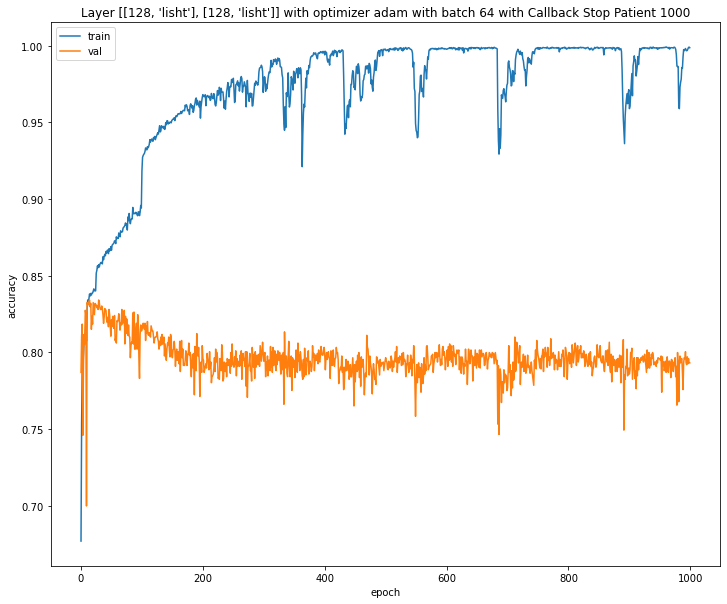

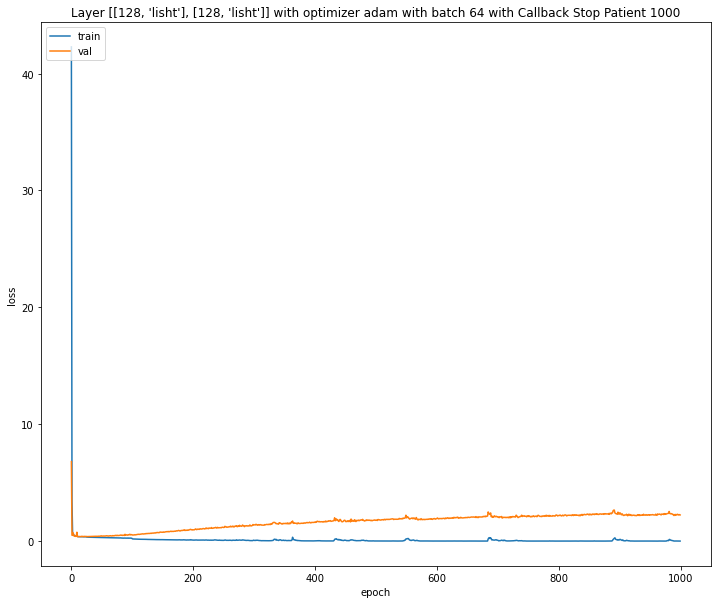

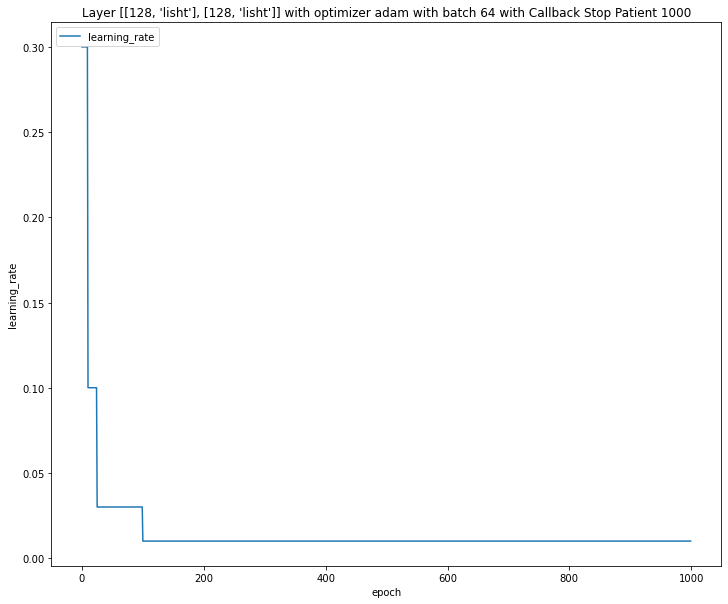

--- ANN with hidden layers [[128, 'lisht'], [128, 'lisht']], batch size 14232, epoch size 1000, optimizer adam  ---
[128, 'lisht']
[[[16, 'lisht']], [[128, 'lisht']], [[128, 'lisht'], [128, 'lisht']], [[128, 'swish'], [128, 'swish']]]
[128, 'lisht']
[[[16, 'lisht']], [[128, 'lisht']], [[128, 'lisht'], [128, 'lisht']], [[128, 'swish'], [128, 'swish']]]
Epoch 1/1000
1/1 [==============================] - 0s 127ms/step - loss: 0.8900 - accuracy: 0.4428 - val_loss: 383.7710 - val_accuracy: 0.5104


C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(
C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


Epoch 2/1000
1/1 [==============================] - 0s 76ms/step - loss: 403.5237 - accuracy: 0.4967 - val_loss: 6.2219 - val_accuracy: 0.5104
Epoch 3/1000
1/1 [==============================] - 0s 76ms/step - loss: 6.4432 - accuracy: 0.4967 - val_loss: 161.9267 - val_accuracy: 0.4896
Epoch 4/1000
1/1 [==============================] - 0s 79ms/step - loss: 161.5947 - accuracy: 0.5033 - val_loss: 149.4325 - val_accuracy: 0.4896
Epoch 5/1000
1/1 [==============================] - 0s 81ms/step - loss: 150.4271 - accuracy: 0.5033 - val_loss: 88.2245 - val_accuracy: 0.4896
Epoch 6/1000
1/1 [==============================] - 0s 85ms/step - loss: 88.1749 - accuracy: 0.5033 - val_loss: 30.5572 - val_accuracy: 0.5104
Epoch 7/1000
1/1 [==============================] - 0s 81ms/step - loss: 32.5471 - accuracy: 0.4967 - val_loss: 4.7806 - val_accuracy: 0.5773
Epoch 8/1000
1/1 [==============================] - 0s 79ms/step - loss: 5.0548 - accuracy: 0.5612 - val_loss: 328.6206 - val_accuracy: 0.48

C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


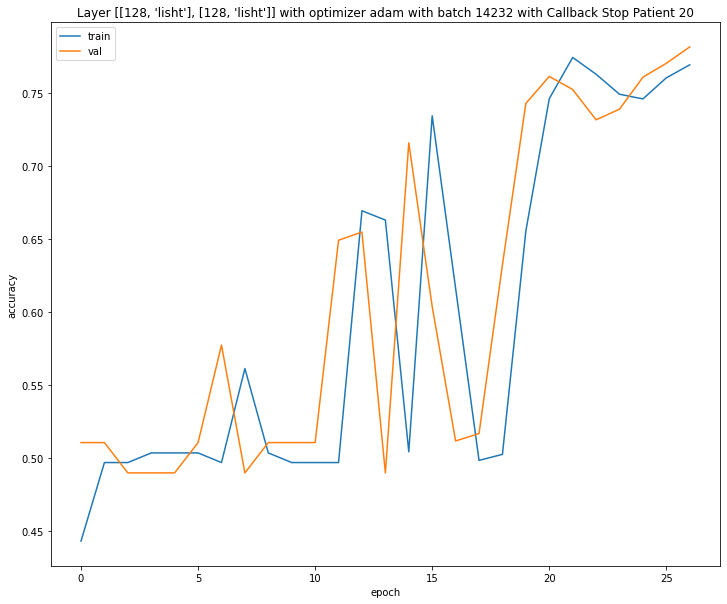

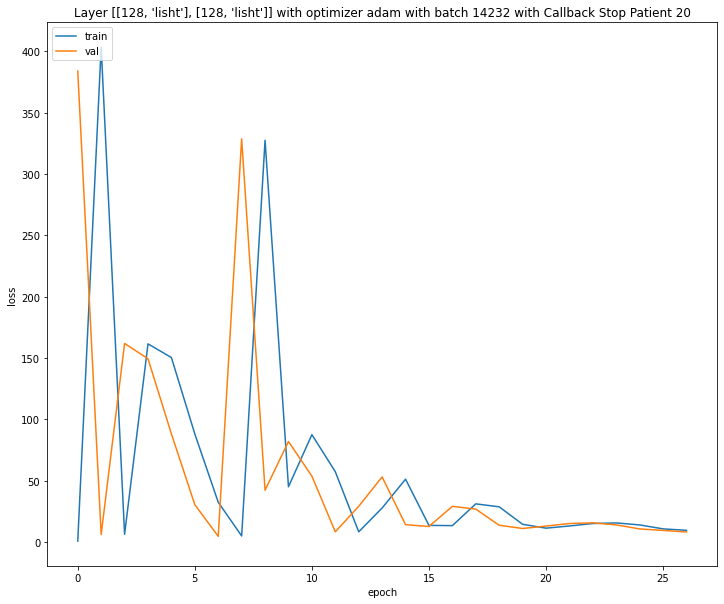

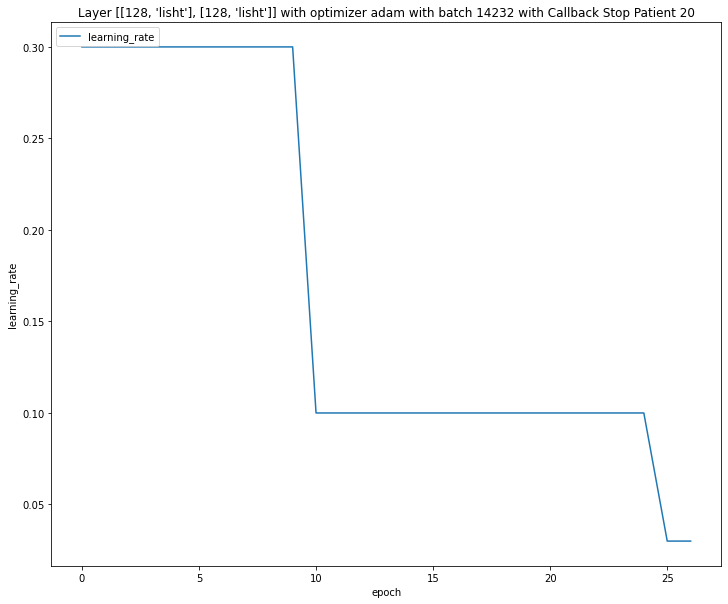

--- ANN with hidden layers [[128, 'lisht'], [128, 'lisht']], batch size 14232, epoch size 1000, optimizer adam  ---
[128, 'lisht']
[[[16, 'lisht']], [[128, 'lisht']], [[128, 'lisht'], [128, 'lisht']], [[128, 'swish'], [128, 'swish']]]
[128, 'lisht']
[[[16, 'lisht']], [[128, 'lisht']], [[128, 'lisht'], [128, 'lisht']], [[128, 'swish'], [128, 'swish']]]
Epoch 1/1000
1/1 [==============================] - 0s 132ms/step - loss: 0.7077 - accuracy: 0.4423 - val_loss: 383.8292 - val_accuracy: 0.5082


C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(
C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


Epoch 2/1000
1/1 [==============================] - 0s 80ms/step - loss: 426.1407 - accuracy: 0.4967 - val_loss: 8.5841 - val_accuracy: 0.5087
Epoch 3/1000
1/1 [==============================] - 0s 77ms/step - loss: 9.7158 - accuracy: 0.4967 - val_loss: 82.6021 - val_accuracy: 0.4918
Epoch 4/1000
1/1 [==============================] - 0s 79ms/step - loss: 79.8441 - accuracy: 0.5033 - val_loss: 173.1693 - val_accuracy: 0.4918
Epoch 5/1000
1/1 [==============================] - 0s 75ms/step - loss: 172.6314 - accuracy: 0.5033 - val_loss: 67.9063 - val_accuracy: 0.4918
Epoch 6/1000
1/1 [==============================] - 0s 78ms/step - loss: 65.8353 - accuracy: 0.5033 - val_loss: 121.2965 - val_accuracy: 0.5082
Epoch 7/1000
1/1 [==============================] - 0s 79ms/step - loss: 132.8006 - accuracy: 0.4967 - val_loss: 76.8525 - val_accuracy: 0.5082
Epoch 8/1000
1/1 [==============================] - 0s 80ms/step - loss: 85.6622 - accuracy: 0.4967 - val_loss: 281.3177 - val_accuracy: 0.

1/1 [==============================] - 0s 76ms/step - loss: 1.3667 - accuracy: 0.7499 - val_loss: 1.1372 - val_accuracy: 0.7875
Epoch 60/1000
1/1 [==============================] - 0s 81ms/step - loss: 1.1632 - accuracy: 0.7820 - val_loss: 0.9904 - val_accuracy: 0.8089
Epoch 61/1000
1/1 [==============================] - 0s 77ms/step - loss: 0.9990 - accuracy: 0.8108 - val_loss: 0.9982 - val_accuracy: 0.8218
Epoch 62/1000
1/1 [==============================] - 0s 80ms/step - loss: 0.9888 - accuracy: 0.8172 - val_loss: 1.1177 - val_accuracy: 0.8083
Epoch 63/1000
1/1 [==============================] - 0s 84ms/step - loss: 1.0851 - accuracy: 0.8106 - val_loss: 1.2028 - val_accuracy: 0.8010
Epoch 64/1000
1/1 [==============================] - 0s 83ms/step - loss: 1.1586 - accuracy: 0.8032 - val_loss: 1.1331 - val_accuracy: 0.8027
Epoch 65/1000
1/1 [==============================] - 0s 79ms/step - loss: 1.1041 - accuracy: 0.8072 - val_loss: 0.9908 - val_accuracy: 0.8151
Epoch 66/1000
1/1 [=

Epoch 117/1000
1/1 [==============================] - 0s 78ms/step - loss: 0.4261 - accuracy: 0.8186 - val_loss: 0.4531 - val_accuracy: 0.8049
Epoch 118/1000
1/1 [==============================] - 0s 77ms/step - loss: 0.4249 - accuracy: 0.8187 - val_loss: 0.4533 - val_accuracy: 0.8094
Epoch 119/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.4245 - accuracy: 0.8194 - val_loss: 0.4451 - val_accuracy: 0.8151
Epoch 120/1000
1/1 [==============================] - 0s 85ms/step - loss: 0.4211 - accuracy: 0.8231 - val_loss: 0.4428 - val_accuracy: 0.8168
Epoch 121/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.4233 - accuracy: 0.8256 - val_loss: 0.4436 - val_accuracy: 0.8190
Epoch 122/1000
1/1 [==============================] - 0s 77ms/step - loss: 0.4266 - accuracy: 0.8264 - val_loss: 0.4442 - val_accuracy: 0.8201
Epoch 123/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.4278 - accuracy: 0.8260 - val_loss: 0.4445 - val_accuracy: 0.8190

1/1 [==============================] - 0s 88ms/step - loss: 0.4037 - accuracy: 0.8288 - val_loss: 0.4177 - val_accuracy: 0.8201
Epoch 175/1000
1/1 [==============================] - 0s 85ms/step - loss: 0.4035 - accuracy: 0.8288 - val_loss: 0.4172 - val_accuracy: 0.8207
Epoch 176/1000
1/1 [==============================] - 0s 79ms/step - loss: 0.4033 - accuracy: 0.8292 - val_loss: 0.4167 - val_accuracy: 0.8212
Epoch 177/1000
1/1 [==============================] - 0s 81ms/step - loss: 0.4032 - accuracy: 0.8297 - val_loss: 0.4165 - val_accuracy: 0.8207
Epoch 178/1000
1/1 [==============================] - 0s 80ms/step - loss: 0.4030 - accuracy: 0.8297 - val_loss: 0.4165 - val_accuracy: 0.8207
Epoch 179/1000
1/1 [==============================] - 0s 99ms/step - loss: 0.4029 - accuracy: 0.8295 - val_loss: 0.4164 - val_accuracy: 0.8207
Epoch 180/1000
1/1 [==============================] - 0s 82ms/step - loss: 0.4027 - accuracy: 0.8291 - val_loss: 0.4161 - val_accuracy: 0.8212
Epoch 181/1000

1/1 [==============================] - 0s 75ms/step - loss: 0.3970 - accuracy: 0.8301 - val_loss: 0.4065 - val_accuracy: 0.8252
Epoch 232/1000
1/1 [==============================] - 0s 83ms/step - loss: 0.3969 - accuracy: 0.8300 - val_loss: 0.4063 - val_accuracy: 0.8252
Epoch 233/1000
1/1 [==============================] - 0s 82ms/step - loss: 0.3968 - accuracy: 0.8299 - val_loss: 0.4062 - val_accuracy: 0.8246
Epoch 234/1000
1/1 [==============================] - 0s 79ms/step - loss: 0.3967 - accuracy: 0.8297 - val_loss: 0.4060 - val_accuracy: 0.8246
Epoch 235/1000
1/1 [==============================] - 0s 80ms/step - loss: 0.3967 - accuracy: 0.8298 - val_loss: 0.4058 - val_accuracy: 0.8246
Epoch 236/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.3966 - accuracy: 0.8298 - val_loss: 0.4057 - val_accuracy: 0.8246
Epoch 237/1000
1/1 [==============================] - 0s 77ms/step - loss: 0.3965 - accuracy: 0.8298 - val_loss: 0.4056 - val_accuracy: 0.8246
Epoch 238/1000

1/1 [==============================] - 0s 77ms/step - loss: 0.3926 - accuracy: 0.8319 - val_loss: 0.3990 - val_accuracy: 0.8241
Epoch 289/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.3925 - accuracy: 0.8319 - val_loss: 0.3989 - val_accuracy: 0.8241
Epoch 290/1000
1/1 [==============================] - 0s 77ms/step - loss: 0.3924 - accuracy: 0.8319 - val_loss: 0.3988 - val_accuracy: 0.8241
Epoch 291/1000
1/1 [==============================] - 0s 80ms/step - loss: 0.3923 - accuracy: 0.8319 - val_loss: 0.3987 - val_accuracy: 0.8241
Epoch 292/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.3923 - accuracy: 0.8318 - val_loss: 0.3986 - val_accuracy: 0.8246
Epoch 293/1000
1/1 [==============================] - 0s 85ms/step - loss: 0.3922 - accuracy: 0.8317 - val_loss: 0.3985 - val_accuracy: 0.8246
Epoch 294/1000
1/1 [==============================] - 0s 87ms/step - loss: 0.3921 - accuracy: 0.8318 - val_loss: 0.3984 - val_accuracy: 0.8246
Epoch 295/1000

1/1 [==============================] - 0s 82ms/step - loss: 0.3890 - accuracy: 0.8322 - val_loss: 0.3937 - val_accuracy: 0.8286
Epoch 346/1000
1/1 [==============================] - 0s 88ms/step - loss: 0.3890 - accuracy: 0.8322 - val_loss: 0.3936 - val_accuracy: 0.8291
Epoch 347/1000
1/1 [==============================] - 0s 78ms/step - loss: 0.3889 - accuracy: 0.8323 - val_loss: 0.3936 - val_accuracy: 0.8291
Epoch 348/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.3889 - accuracy: 0.8323 - val_loss: 0.3935 - val_accuracy: 0.8291
Epoch 349/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.3888 - accuracy: 0.8323 - val_loss: 0.3934 - val_accuracy: 0.8291
Epoch 350/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.3887 - accuracy: 0.8323 - val_loss: 0.3933 - val_accuracy: 0.8291
Epoch 351/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.3887 - accuracy: 0.8323 - val_loss: 0.3932 - val_accuracy: 0.8291
Epoch 352/1000

1/1 [==============================] - 0s 81ms/step - loss: 0.3862 - accuracy: 0.8333 - val_loss: 0.3897 - val_accuracy: 0.8286
Epoch 403/1000
1/1 [==============================] - 0s 84ms/step - loss: 0.3861 - accuracy: 0.8333 - val_loss: 0.3896 - val_accuracy: 0.8286
Epoch 404/1000
1/1 [==============================] - 0s 86ms/step - loss: 0.3861 - accuracy: 0.8331 - val_loss: 0.3896 - val_accuracy: 0.8286
Epoch 405/1000
1/1 [==============================] - 0s 80ms/step - loss: 0.3860 - accuracy: 0.8331 - val_loss: 0.3895 - val_accuracy: 0.8286
Epoch 406/1000
1/1 [==============================] - 0s 81ms/step - loss: 0.3860 - accuracy: 0.8331 - val_loss: 0.3894 - val_accuracy: 0.8286
Epoch 407/1000
1/1 [==============================] - 0s 80ms/step - loss: 0.3860 - accuracy: 0.8333 - val_loss: 0.3894 - val_accuracy: 0.8286
Epoch 408/1000
1/1 [==============================] - 0s 77ms/step - loss: 0.3859 - accuracy: 0.8333 - val_loss: 0.3893 - val_accuracy: 0.8286
Epoch 409/1000

1/1 [==============================] - 0s 77ms/step - loss: 0.3838 - accuracy: 0.8334 - val_loss: 0.3865 - val_accuracy: 0.8302
Epoch 460/1000
1/1 [==============================] - 0s 77ms/step - loss: 0.3838 - accuracy: 0.8333 - val_loss: 0.3864 - val_accuracy: 0.8302
Epoch 461/1000
1/1 [==============================] - 0s 77ms/step - loss: 0.3837 - accuracy: 0.8333 - val_loss: 0.3864 - val_accuracy: 0.8302
Epoch 462/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.3837 - accuracy: 0.8334 - val_loss: 0.3863 - val_accuracy: 0.8308
Epoch 463/1000
1/1 [==============================] - 0s 80ms/step - loss: 0.3836 - accuracy: 0.8335 - val_loss: 0.3863 - val_accuracy: 0.8308
Epoch 464/1000
1/1 [==============================] - 0s 85ms/step - loss: 0.3836 - accuracy: 0.8335 - val_loss: 0.3862 - val_accuracy: 0.8308
Epoch 465/1000
1/1 [==============================] - 0s 83ms/step - loss: 0.3836 - accuracy: 0.8336 - val_loss: 0.3862 - val_accuracy: 0.8308
Epoch 466/1000

1/1 [==============================] - 0s 84ms/step - loss: 0.3817 - accuracy: 0.8346 - val_loss: 0.3838 - val_accuracy: 0.8325
Epoch 517/1000
1/1 [==============================] - 0s 77ms/step - loss: 0.3817 - accuracy: 0.8346 - val_loss: 0.3838 - val_accuracy: 0.8325
Epoch 518/1000
1/1 [==============================] - 0s 77ms/step - loss: 0.3817 - accuracy: 0.8347 - val_loss: 0.3838 - val_accuracy: 0.8325
Epoch 519/1000
1/1 [==============================] - 0s 79ms/step - loss: 0.3816 - accuracy: 0.8347 - val_loss: 0.3837 - val_accuracy: 0.8325
Epoch 520/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.3816 - accuracy: 0.8347 - val_loss: 0.3837 - val_accuracy: 0.8325
Epoch 521/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.3816 - accuracy: 0.8346 - val_loss: 0.3836 - val_accuracy: 0.8325
Epoch 522/1000
1/1 [==============================] - 0s 77ms/step - loss: 0.3815 - accuracy: 0.8346 - val_loss: 0.3836 - val_accuracy: 0.8325
Epoch 523/1000

1/1 [==============================] - 0s 85ms/step - loss: 0.3799 - accuracy: 0.8348 - val_loss: 0.3816 - val_accuracy: 0.8319
Epoch 574/1000
1/1 [==============================] - 0s 92ms/step - loss: 0.3799 - accuracy: 0.8348 - val_loss: 0.3816 - val_accuracy: 0.8319
Epoch 575/1000
1/1 [==============================] - 0s 87ms/step - loss: 0.3799 - accuracy: 0.8347 - val_loss: 0.3815 - val_accuracy: 0.8319
Epoch 576/1000
1/1 [==============================] - 0s 90ms/step - loss: 0.3799 - accuracy: 0.8347 - val_loss: 0.3815 - val_accuracy: 0.8319
Epoch 577/1000
1/1 [==============================] - 0s 83ms/step - loss: 0.3798 - accuracy: 0.8347 - val_loss: 0.3815 - val_accuracy: 0.8319
Epoch 578/1000
1/1 [==============================] - 0s 77ms/step - loss: 0.3798 - accuracy: 0.8346 - val_loss: 0.3814 - val_accuracy: 0.8319
Epoch 579/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.3798 - accuracy: 0.8346 - val_loss: 0.3814 - val_accuracy: 0.8319
Epoch 580/1000

1/1 [==============================] - 0s 76ms/step - loss: 0.3783 - accuracy: 0.8359 - val_loss: 0.3797 - val_accuracy: 0.8342
Epoch 631/1000
1/1 [==============================] - 0s 83ms/step - loss: 0.3783 - accuracy: 0.8358 - val_loss: 0.3797 - val_accuracy: 0.8342
Epoch 632/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.3783 - accuracy: 0.8357 - val_loss: 0.3796 - val_accuracy: 0.8342
Epoch 633/1000
1/1 [==============================] - 0s 82ms/step - loss: 0.3783 - accuracy: 0.8357 - val_loss: 0.3796 - val_accuracy: 0.8342
Epoch 634/1000
1/1 [==============================] - 0s 88ms/step - loss: 0.3782 - accuracy: 0.8357 - val_loss: 0.3796 - val_accuracy: 0.8342
Epoch 635/1000
1/1 [==============================] - 0s 84ms/step - loss: 0.3782 - accuracy: 0.8357 - val_loss: 0.3795 - val_accuracy: 0.8342
Epoch 636/1000
1/1 [==============================] - 0s 79ms/step - loss: 0.3782 - accuracy: 0.8357 - val_loss: 0.3795 - val_accuracy: 0.8342
Epoch 637/1000

1/1 [==============================] - 0s 75ms/step - loss: 0.3769 - accuracy: 0.8363 - val_loss: 0.3780 - val_accuracy: 0.8347
Epoch 688/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.3769 - accuracy: 0.8363 - val_loss: 0.3780 - val_accuracy: 0.8347
Epoch 689/1000
1/1 [==============================] - 0s 78ms/step - loss: 0.3768 - accuracy: 0.8364 - val_loss: 0.3780 - val_accuracy: 0.8347
Epoch 690/1000
1/1 [==============================] - 0s 77ms/step - loss: 0.3768 - accuracy: 0.8364 - val_loss: 0.3780 - val_accuracy: 0.8347
Epoch 691/1000
1/1 [==============================] - 0s 77ms/step - loss: 0.3768 - accuracy: 0.8364 - val_loss: 0.3779 - val_accuracy: 0.8347
Epoch 692/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.3768 - accuracy: 0.8364 - val_loss: 0.3779 - val_accuracy: 0.8347
Epoch 693/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.3767 - accuracy: 0.8364 - val_loss: 0.3779 - val_accuracy: 0.8347
Epoch 694/1000

1/1 [==============================] - 0s 83ms/step - loss: 0.3756 - accuracy: 0.8368 - val_loss: 0.3766 - val_accuracy: 0.8353
Epoch 745/1000
1/1 [==============================] - 0s 89ms/step - loss: 0.3755 - accuracy: 0.8368 - val_loss: 0.3766 - val_accuracy: 0.8353
Epoch 746/1000
1/1 [==============================] - 0s 81ms/step - loss: 0.3755 - accuracy: 0.8368 - val_loss: 0.3765 - val_accuracy: 0.8353
Epoch 747/1000
1/1 [==============================] - 0s 91ms/step - loss: 0.3755 - accuracy: 0.8368 - val_loss: 0.3765 - val_accuracy: 0.8353
Epoch 748/1000
1/1 [==============================] - 0s 81ms/step - loss: 0.3755 - accuracy: 0.8368 - val_loss: 0.3765 - val_accuracy: 0.8353
Epoch 749/1000
1/1 [==============================] - 0s 77ms/step - loss: 0.3754 - accuracy: 0.8367 - val_loss: 0.3765 - val_accuracy: 0.8353
Epoch 750/1000
1/1 [==============================] - 0s 84ms/step - loss: 0.3754 - accuracy: 0.8368 - val_loss: 0.3765 - val_accuracy: 0.8353
Epoch 751/1000

1/1 [==============================] - 0s 86ms/step - loss: 0.3743 - accuracy: 0.8373 - val_loss: 0.3753 - val_accuracy: 0.8387
Epoch 802/1000
1/1 [==============================] - 0s 85ms/step - loss: 0.3743 - accuracy: 0.8373 - val_loss: 0.3753 - val_accuracy: 0.8387
Epoch 803/1000
1/1 [==============================] - 0s 86ms/step - loss: 0.3743 - accuracy: 0.8373 - val_loss: 0.3753 - val_accuracy: 0.8387
Epoch 804/1000
1/1 [==============================] - 0s 84ms/step - loss: 0.3743 - accuracy: 0.8373 - val_loss: 0.3753 - val_accuracy: 0.8387
Epoch 805/1000
1/1 [==============================] - 0s 78ms/step - loss: 0.3743 - accuracy: 0.8375 - val_loss: 0.3752 - val_accuracy: 0.8387
Epoch 806/1000
1/1 [==============================] - 0s 81ms/step - loss: 0.3742 - accuracy: 0.8375 - val_loss: 0.3752 - val_accuracy: 0.8387
Epoch 807/1000
1/1 [==============================] - 0s 78ms/step - loss: 0.3742 - accuracy: 0.8375 - val_loss: 0.3752 - val_accuracy: 0.8387
Epoch 808/1000

1/1 [==============================] - 0s 79ms/step - loss: 0.3732 - accuracy: 0.8375 - val_loss: 0.3742 - val_accuracy: 0.8392
Epoch 859/1000
1/1 [==============================] - 0s 80ms/step - loss: 0.3732 - accuracy: 0.8375 - val_loss: 0.3742 - val_accuracy: 0.8392
Epoch 860/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.3732 - accuracy: 0.8375 - val_loss: 0.3742 - val_accuracy: 0.8392
Epoch 861/1000
1/1 [==============================] - 0s 77ms/step - loss: 0.3732 - accuracy: 0.8376 - val_loss: 0.3742 - val_accuracy: 0.8392
Epoch 862/1000
1/1 [==============================] - 0s 85ms/step - loss: 0.3731 - accuracy: 0.8377 - val_loss: 0.3741 - val_accuracy: 0.8392
Epoch 863/1000
1/1 [==============================] - 0s 83ms/step - loss: 0.3731 - accuracy: 0.8377 - val_loss: 0.3741 - val_accuracy: 0.8398
Epoch 864/1000
1/1 [==============================] - 0s 84ms/step - loss: 0.3731 - accuracy: 0.8376 - val_loss: 0.3741 - val_accuracy: 0.8398
Epoch 865/1000

1/1 [==============================] - 0s 78ms/step - loss: 0.3722 - accuracy: 0.8381 - val_loss: 0.3732 - val_accuracy: 0.8398
Epoch 916/1000
1/1 [==============================] - 0s 77ms/step - loss: 0.3722 - accuracy: 0.8381 - val_loss: 0.3732 - val_accuracy: 0.8398
Epoch 917/1000
1/1 [==============================] - 0s 79ms/step - loss: 0.3721 - accuracy: 0.8382 - val_loss: 0.3732 - val_accuracy: 0.8398
Epoch 918/1000
1/1 [==============================] - 0s 80ms/step - loss: 0.3721 - accuracy: 0.8382 - val_loss: 0.3732 - val_accuracy: 0.8398
Epoch 919/1000
1/1 [==============================] - 0s 79ms/step - loss: 0.3721 - accuracy: 0.8382 - val_loss: 0.3732 - val_accuracy: 0.8398
Epoch 920/1000
1/1 [==============================] - 0s 81ms/step - loss: 0.3721 - accuracy: 0.8383 - val_loss: 0.3732 - val_accuracy: 0.8398
Epoch 921/1000
1/1 [==============================] - 0s 77ms/step - loss: 0.3721 - accuracy: 0.8383 - val_loss: 0.3731 - val_accuracy: 0.8398
Epoch 922/1000

1/1 [==============================] - 0s 83ms/step - loss: 0.3712 - accuracy: 0.8388 - val_loss: 0.3724 - val_accuracy: 0.8387
Epoch 973/1000
1/1 [==============================] - 0s 81ms/step - loss: 0.3712 - accuracy: 0.8388 - val_loss: 0.3724 - val_accuracy: 0.8387
Epoch 974/1000
1/1 [==============================] - 0s 81ms/step - loss: 0.3712 - accuracy: 0.8388 - val_loss: 0.3724 - val_accuracy: 0.8387
Epoch 975/1000
1/1 [==============================] - 0s 82ms/step - loss: 0.3711 - accuracy: 0.8388 - val_loss: 0.3723 - val_accuracy: 0.8387
Epoch 976/1000
1/1 [==============================] - 0s 85ms/step - loss: 0.3711 - accuracy: 0.8388 - val_loss: 0.3723 - val_accuracy: 0.8387
Epoch 977/1000
1/1 [==============================] - 0s 89ms/step - loss: 0.3711 - accuracy: 0.8388 - val_loss: 0.3723 - val_accuracy: 0.8387
Epoch 978/1000
1/1 [==============================] - 0s 85ms/step - loss: 0.3711 - accuracy: 0.8387 - val_loss: 0.3723 - val_accuracy: 0.8387
Epoch 979/1000

C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


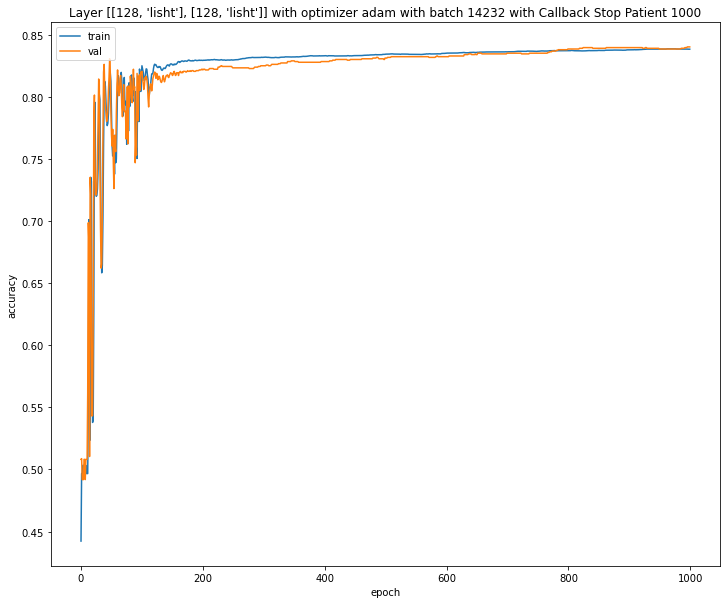

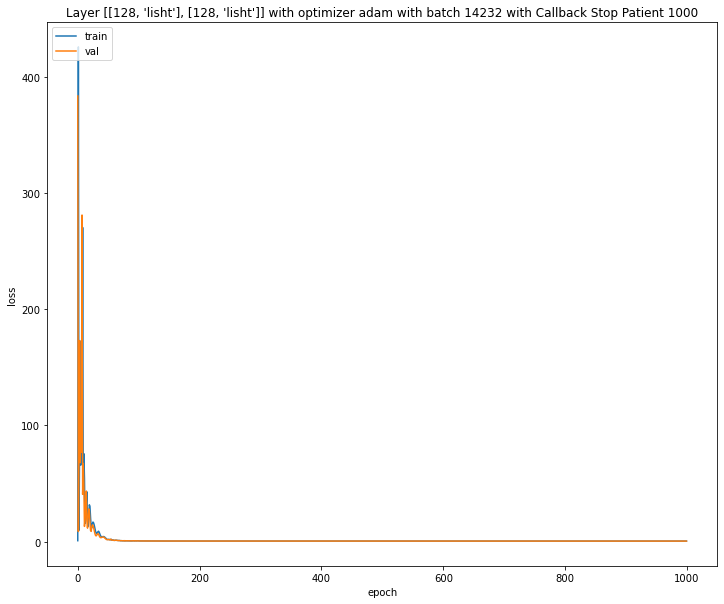

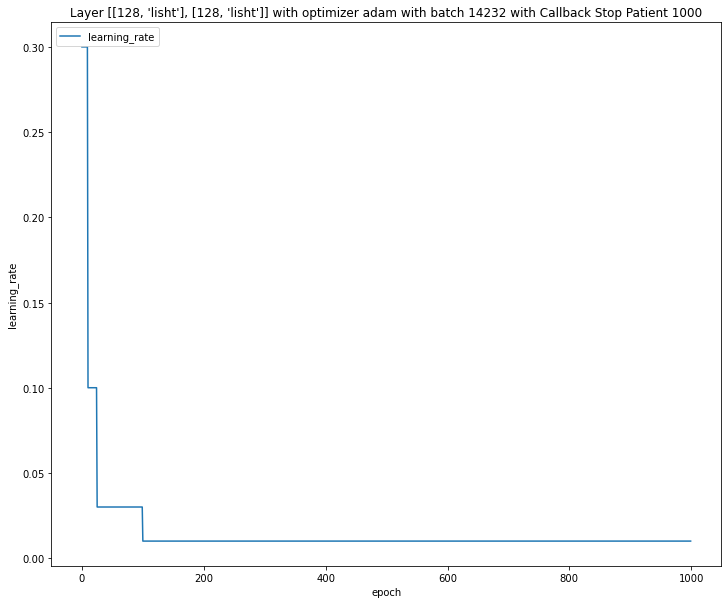

--- ANN with hidden layers [[128, 'swish'], [128, 'swish']], batch size 64, epoch size 1000, optimizer adam  ---
[128, 'swish']
[[[16, 'lisht']], [[128, 'lisht']], [[128, 'lisht'], [128, 'lisht']], [[128, 'swish'], [128, 'swish']]]
[128, 'swish']
[[[16, 'lisht']], [[128, 'lisht']], [[128, 'lisht'], [128, 'lisht']], [[128, 'swish'], [128, 'swish']]]
Epoch 1/1000
 12/223 [>.............................] - ETA: 2s - loss: 49.3101 - accuracy: 0.5560

C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


223/223 [==============================] - 2s 11ms/step - loss: 3.5224 - accuracy: 0.5499 - val_loss: 0.6968 - val_accuracy: 0.4986
Epoch 2/1000
  1/223 [..............................] - ETA: 2s - loss: 0.7001 - accuracy: 0.4688

C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


223/223 [==============================] - 2s 10ms/step - loss: 0.6959 - accuracy: 0.5174 - val_loss: 0.6922 - val_accuracy: 0.5014
Epoch 3/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.7016 - accuracy: 0.4983 - val_loss: 0.6934 - val_accuracy: 0.5014
Epoch 4/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.6949 - accuracy: 0.5028 - val_loss: 0.6947 - val_accuracy: 0.5014
Epoch 5/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.6962 - accuracy: 0.5011 - val_loss: 0.7037 - val_accuracy: 0.5014
Epoch 6/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.6977 - accuracy: 0.4975 - val_loss: 0.6960 - val_accuracy: 0.5014
Epoch 7/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.6965 - accuracy: 0.5007 - val_loss: 0.6932 - val_accuracy: 0.4986
Epoch 8/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.6971 - accuracy: 0.5020 - val_loss: 0.6949 - val_accuracy: 0.501

C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(
C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

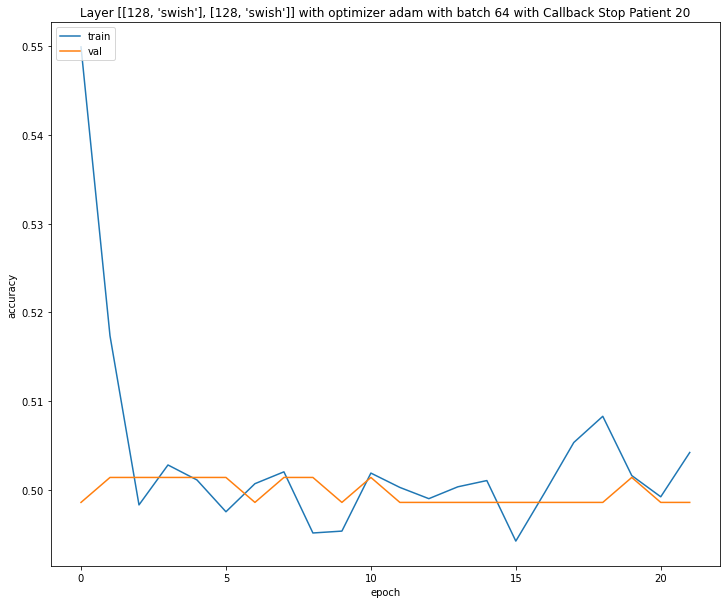

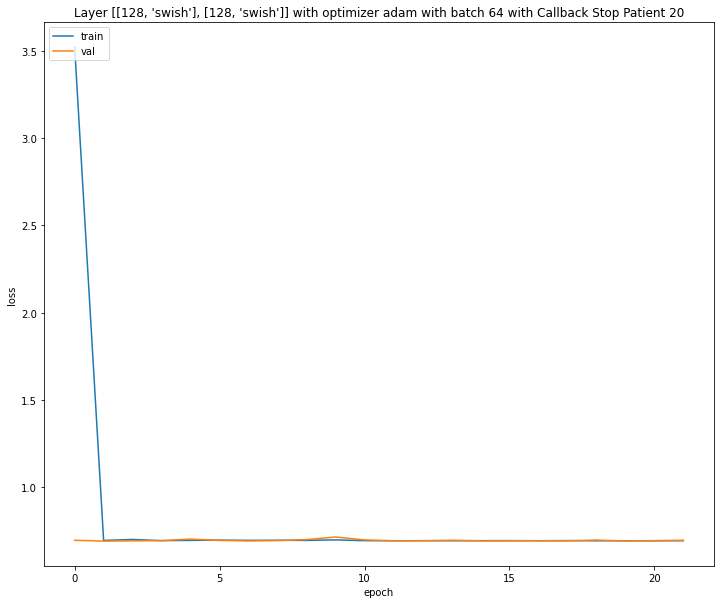

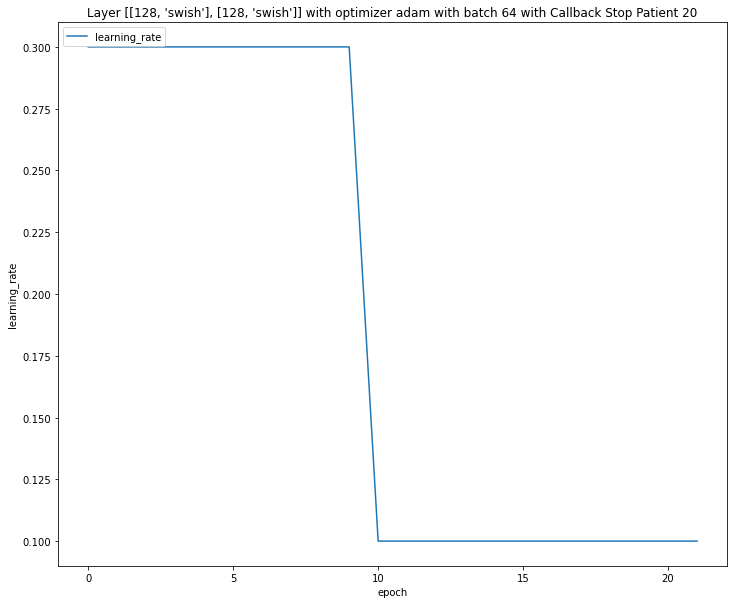

--- ANN with hidden layers [[128, 'swish'], [128, 'swish']], batch size 64, epoch size 1000, optimizer adam  ---
[128, 'swish']
[[[16, 'lisht']], [[128, 'lisht']], [[128, 'lisht'], [128, 'lisht']], [[128, 'swish'], [128, 'swish']]]
[128, 'swish']
[[[16, 'lisht']], [[128, 'lisht']], [[128, 'lisht'], [128, 'lisht']], [[128, 'swish'], [128, 'swish']]]
Epoch 1/1000
 12/223 [>.............................] - ETA: 2s - loss: 78.4431 - accuracy: 0.6042

C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


223/223 [==============================] - 2s 11ms/step - loss: 5.4394 - accuracy: 0.6977 - val_loss: 0.5076 - val_accuracy: 0.7487
Epoch 2/1000
  1/223 [..............................] - ETA: 2s - loss: 0.4755 - accuracy: 0.7969

C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


223/223 [==============================] - 2s 10ms/step - loss: 0.4842 - accuracy: 0.7903 - val_loss: 0.4321 - val_accuracy: 0.8061
Epoch 3/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.4865 - accuracy: 0.7860 - val_loss: 0.4801 - val_accuracy: 0.7763
Epoch 4/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.4413 - accuracy: 0.8110 - val_loss: 0.5006 - val_accuracy: 0.8021
Epoch 5/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.4639 - accuracy: 0.7995 - val_loss: 0.4141 - val_accuracy: 0.8179
Epoch 6/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.4589 - accuracy: 0.8056 - val_loss: 0.4619 - val_accuracy: 0.8184
Epoch 7/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.4461 - accuracy: 0.8152 - val_loss: 0.4468 - val_accuracy: 0.7988
Epoch 8/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.4526 - accuracy: 0.8106 - val_loss: 0.4241 - val_accuracy: 0.805

Epoch 58/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3507 - accuracy: 0.8508 - val_loss: 0.4174 - val_accuracy: 0.8246
Epoch 59/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3503 - accuracy: 0.8496 - val_loss: 0.4150 - val_accuracy: 0.8280
Epoch 60/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3497 - accuracy: 0.8524 - val_loss: 0.4094 - val_accuracy: 0.8235
Epoch 61/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3507 - accuracy: 0.8494 - val_loss: 0.4250 - val_accuracy: 0.8218
Epoch 62/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3484 - accuracy: 0.8501 - val_loss: 0.4231 - val_accuracy: 0.8286
Epoch 63/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3506 - accuracy: 0.8508 - val_loss: 0.4228 - val_accuracy: 0.8274
Epoch 64/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3484 - accuracy: 0.8522 - val_loss: 0.4294 -

223/223 [==============================] - 2s 11ms/step - loss: 0.3267 - accuracy: 0.8621 - val_loss: 0.4577 - val_accuracy: 0.8263
Epoch 115/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3271 - accuracy: 0.8629 - val_loss: 0.4579 - val_accuracy: 0.8263
Epoch 116/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3261 - accuracy: 0.8610 - val_loss: 0.4659 - val_accuracy: 0.8269
Epoch 117/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3263 - accuracy: 0.8608 - val_loss: 0.4582 - val_accuracy: 0.8274
Epoch 118/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3260 - accuracy: 0.8618 - val_loss: 0.4602 - val_accuracy: 0.8252
Epoch 119/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3260 - accuracy: 0.8620 - val_loss: 0.4668 - val_accuracy: 0.8274
Epoch 120/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3258 - accuracy: 0.8624 - val_loss: 0.4654 - val_acc

Epoch 170/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3187 - accuracy: 0.8663 - val_loss: 0.4799 - val_accuracy: 0.8246
Epoch 171/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3183 - accuracy: 0.8657 - val_loss: 0.4777 - val_accuracy: 0.8241
Epoch 172/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3187 - accuracy: 0.8657 - val_loss: 0.4840 - val_accuracy: 0.8280
Epoch 173/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3185 - accuracy: 0.8667 - val_loss: 0.4868 - val_accuracy: 0.8252
Epoch 174/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3185 - accuracy: 0.8671 - val_loss: 0.4780 - val_accuracy: 0.8229
Epoch 175/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.3187 - accuracy: 0.8668 - val_loss: 0.4886 - val_accuracy: 0.8241
Epoch 176/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3181 - accuracy: 0.8657 - val_loss: 0

Epoch 226/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3120 - accuracy: 0.8719 - val_loss: 0.5084 - val_accuracy: 0.8241
Epoch 227/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3114 - accuracy: 0.8704 - val_loss: 0.5117 - val_accuracy: 0.8212
Epoch 228/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3108 - accuracy: 0.8706 - val_loss: 0.5196 - val_accuracy: 0.8207
Epoch 229/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3115 - accuracy: 0.8704 - val_loss: 0.5243 - val_accuracy: 0.8252
Epoch 230/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.3108 - accuracy: 0.8694 - val_loss: 0.5123 - val_accuracy: 0.8241
Epoch 231/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3105 - accuracy: 0.8714 - val_loss: 0.5081 - val_accuracy: 0.8218
Epoch 232/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.3115 - accuracy: 0.8704 - val_loss: 0

Epoch 282/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.3037 - accuracy: 0.8737 - val_loss: 0.5376 - val_accuracy: 0.8224
Epoch 283/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.3028 - accuracy: 0.8744 - val_loss: 0.5199 - val_accuracy: 0.8196
Epoch 284/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.3037 - accuracy: 0.8740 - val_loss: 0.5281 - val_accuracy: 0.8196
Epoch 285/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.3057 - accuracy: 0.8723 - val_loss: 0.5299 - val_accuracy: 0.8190
Epoch 286/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.3035 - accuracy: 0.8747 - val_loss: 0.5267 - val_accuracy: 0.8184
Epoch 287/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.3031 - accuracy: 0.8746 - val_loss: 0.5390 - val_accuracy: 0.8184
Epoch 288/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.3028 - accuracy: 0.8738 - val_loss: 0

Epoch 338/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2968 - accuracy: 0.8761 - val_loss: 0.5706 - val_accuracy: 0.8190
Epoch 339/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2965 - accuracy: 0.8771 - val_loss: 0.5666 - val_accuracy: 0.8196
Epoch 340/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.2963 - accuracy: 0.8780 - val_loss: 0.5781 - val_accuracy: 0.8207
Epoch 341/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.2969 - accuracy: 0.8782 - val_loss: 0.5748 - val_accuracy: 0.8212
Epoch 342/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.2962 - accuracy: 0.8772 - val_loss: 0.5733 - val_accuracy: 0.8184
Epoch 343/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.2963 - accuracy: 0.8771 - val_loss: 0.5867 - val_accuracy: 0.8162
Epoch 344/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2963 - accuracy: 0.8774 - val_loss: 0

Epoch 394/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.2908 - accuracy: 0.8803 - val_loss: 0.6188 - val_accuracy: 0.8151
Epoch 395/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.2905 - accuracy: 0.8806 - val_loss: 0.6068 - val_accuracy: 0.8128
Epoch 396/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.2903 - accuracy: 0.8801 - val_loss: 0.6190 - val_accuracy: 0.8134
Epoch 397/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.2914 - accuracy: 0.8774 - val_loss: 0.6196 - val_accuracy: 0.8145
Epoch 398/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.2909 - accuracy: 0.8795 - val_loss: 0.6111 - val_accuracy: 0.8207
Epoch 399/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.2896 - accuracy: 0.8808 - val_loss: 0.6179 - val_accuracy: 0.8156
Epoch 400/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2900 - accuracy: 0.8802 - val_loss: 0

Epoch 450/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2840 - accuracy: 0.8818 - val_loss: 0.6564 - val_accuracy: 0.8190
Epoch 451/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2843 - accuracy: 0.8805 - val_loss: 0.6455 - val_accuracy: 0.8224
Epoch 452/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2839 - accuracy: 0.8821 - val_loss: 0.6600 - val_accuracy: 0.8156
Epoch 453/1000
223/223 [==============================] - 3s 12ms/step - loss: 0.2842 - accuracy: 0.8827 - val_loss: 0.6617 - val_accuracy: 0.8151
Epoch 454/1000
223/223 [==============================] - 3s 12ms/step - loss: 0.2833 - accuracy: 0.8842 - val_loss: 0.6510 - val_accuracy: 0.8134
Epoch 455/1000
223/223 [==============================] - 3s 12ms/step - loss: 0.2838 - accuracy: 0.8812 - val_loss: 0.6647 - val_accuracy: 0.8190
Epoch 456/1000
223/223 [==============================] - 3s 13ms/step - loss: 0.2828 - accuracy: 0.8835 - val_loss: 0

Epoch 506/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2780 - accuracy: 0.8875 - val_loss: 0.6720 - val_accuracy: 0.8179
Epoch 507/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2768 - accuracy: 0.8849 - val_loss: 0.6962 - val_accuracy: 0.8123
Epoch 508/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2777 - accuracy: 0.8865 - val_loss: 0.6905 - val_accuracy: 0.8212
Epoch 509/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2779 - accuracy: 0.8850 - val_loss: 0.7122 - val_accuracy: 0.8100
Epoch 510/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2771 - accuracy: 0.8870 - val_loss: 0.7118 - val_accuracy: 0.8201
Epoch 511/1000
223/223 [==============================] - 3s 12ms/step - loss: 0.2763 - accuracy: 0.8856 - val_loss: 0.6983 - val_accuracy: 0.8094
Epoch 512/1000
223/223 [==============================] - 3s 12ms/step - loss: 0.2778 - accuracy: 0.8872 - val_loss: 0

Epoch 562/1000
223/223 [==============================] - 3s 12ms/step - loss: 0.2729 - accuracy: 0.8869 - val_loss: 0.7432 - val_accuracy: 0.8168
Epoch 563/1000
223/223 [==============================] - 3s 12ms/step - loss: 0.2718 - accuracy: 0.8881 - val_loss: 0.7541 - val_accuracy: 0.8168
Epoch 564/1000
223/223 [==============================] - 3s 12ms/step - loss: 0.2745 - accuracy: 0.8869 - val_loss: 0.7033 - val_accuracy: 0.8162
Epoch 565/1000
223/223 [==============================] - 3s 11ms/step - loss: 0.2725 - accuracy: 0.8862 - val_loss: 0.7328 - val_accuracy: 0.8106
Epoch 566/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2711 - accuracy: 0.8880 - val_loss: 0.7251 - val_accuracy: 0.8106
Epoch 567/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2709 - accuracy: 0.8902 - val_loss: 0.7305 - val_accuracy: 0.8151
Epoch 568/1000
223/223 [==============================] - 3s 12ms/step - loss: 0.2714 - accuracy: 0.8894 - val_loss: 0

Epoch 618/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2663 - accuracy: 0.8903 - val_loss: 0.7945 - val_accuracy: 0.8106
Epoch 619/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2651 - accuracy: 0.8907 - val_loss: 0.7982 - val_accuracy: 0.8117
Epoch 620/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2658 - accuracy: 0.8902 - val_loss: 0.7604 - val_accuracy: 0.8139
Epoch 621/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2648 - accuracy: 0.8909 - val_loss: 0.7959 - val_accuracy: 0.8190
Epoch 622/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2648 - accuracy: 0.8898 - val_loss: 0.7918 - val_accuracy: 0.8168
Epoch 623/1000
223/223 [==============================] - 3s 12ms/step - loss: 0.2663 - accuracy: 0.8900 - val_loss: 0.7868 - val_accuracy: 0.8156
Epoch 624/1000
223/223 [==============================] - 3s 13ms/step - loss: 0.2648 - accuracy: 0.8921 - val_loss: 0

Epoch 674/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2615 - accuracy: 0.8939 - val_loss: 0.8095 - val_accuracy: 0.8128
Epoch 675/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2610 - accuracy: 0.8935 - val_loss: 0.7907 - val_accuracy: 0.8173
Epoch 676/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2614 - accuracy: 0.8927 - val_loss: 0.8100 - val_accuracy: 0.8123
Epoch 677/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2606 - accuracy: 0.8931 - val_loss: 0.7962 - val_accuracy: 0.8145
Epoch 678/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2605 - accuracy: 0.8947 - val_loss: 0.8443 - val_accuracy: 0.8117
Epoch 679/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2591 - accuracy: 0.8945 - val_loss: 0.8056 - val_accuracy: 0.8100
Epoch 680/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2589 - accuracy: 0.8933 - val_loss: 0

Epoch 730/1000
223/223 [==============================] - 3s 13ms/step - loss: 0.2583 - accuracy: 0.8949 - val_loss: 0.8201 - val_accuracy: 0.8089
Epoch 731/1000
223/223 [==============================] - 3s 11ms/step - loss: 0.2575 - accuracy: 0.8954 - val_loss: 0.8827 - val_accuracy: 0.8117
Epoch 732/1000
223/223 [==============================] - 3s 11ms/step - loss: 0.2569 - accuracy: 0.8952 - val_loss: 0.8723 - val_accuracy: 0.8106
Epoch 733/1000
223/223 [==============================] - 3s 12ms/step - loss: 0.2563 - accuracy: 0.8954 - val_loss: 0.8445 - val_accuracy: 0.8162
Epoch 734/1000
223/223 [==============================] - 3s 12ms/step - loss: 0.2567 - accuracy: 0.8954 - val_loss: 0.8783 - val_accuracy: 0.8128
Epoch 735/1000
223/223 [==============================] - 3s 12ms/step - loss: 0.2574 - accuracy: 0.8955 - val_loss: 0.8376 - val_accuracy: 0.8134
Epoch 736/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2550 - accuracy: 0.8960 - val_loss: 0

Epoch 786/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2543 - accuracy: 0.8969 - val_loss: 0.8577 - val_accuracy: 0.8111
Epoch 787/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2532 - accuracy: 0.8976 - val_loss: 0.8893 - val_accuracy: 0.8083
Epoch 788/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2547 - accuracy: 0.8957 - val_loss: 0.8470 - val_accuracy: 0.8111
Epoch 789/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2539 - accuracy: 0.8965 - val_loss: 0.8619 - val_accuracy: 0.8117
Epoch 790/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2524 - accuracy: 0.8980 - val_loss: 0.8979 - val_accuracy: 0.8083
Epoch 791/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2556 - accuracy: 0.8954 - val_loss: 0.8742 - val_accuracy: 0.8123
Epoch 792/1000
223/223 [==============================] - 3s 11ms/step - loss: 0.2554 - accuracy: 0.8971 - val_loss: 0

Epoch 842/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.2493 - accuracy: 0.8992 - val_loss: 0.9370 - val_accuracy: 0.8111
Epoch 843/1000
223/223 [==============================] - 2s 10ms/step - loss: 0.2487 - accuracy: 0.8999 - val_loss: 0.9435 - val_accuracy: 0.8078
Epoch 844/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2488 - accuracy: 0.8987 - val_loss: 0.9375 - val_accuracy: 0.8106
Epoch 845/1000
223/223 [==============================] - 3s 12ms/step - loss: 0.2503 - accuracy: 0.8997 - val_loss: 0.8989 - val_accuracy: 0.8083
Epoch 846/1000
223/223 [==============================] - 3s 12ms/step - loss: 0.2480 - accuracy: 0.8986 - val_loss: 0.9681 - val_accuracy: 0.8123
Epoch 847/1000
223/223 [==============================] - 3s 12ms/step - loss: 0.2476 - accuracy: 0.9001 - val_loss: 0.9776 - val_accuracy: 0.8128
Epoch 848/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2491 - accuracy: 0.8999 - val_loss: 0

Epoch 898/1000
223/223 [==============================] - 3s 12ms/step - loss: 0.2470 - accuracy: 0.8999 - val_loss: 0.9376 - val_accuracy: 0.8083
Epoch 899/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2453 - accuracy: 0.9006 - val_loss: 0.9646 - val_accuracy: 0.8083
Epoch 900/1000
223/223 [==============================] - 3s 11ms/step - loss: 0.2456 - accuracy: 0.9016 - val_loss: 0.9452 - val_accuracy: 0.8089
Epoch 901/1000
223/223 [==============================] - 3s 12ms/step - loss: 0.2458 - accuracy: 0.9010 - val_loss: 1.0081 - val_accuracy: 0.8021
Epoch 902/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2478 - accuracy: 0.9001 - val_loss: 0.9655 - val_accuracy: 0.8111
Epoch 903/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2473 - accuracy: 0.9025 - val_loss: 0.9700 - val_accuracy: 0.8049
Epoch 904/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2451 - accuracy: 0.9018 - val_loss: 1

Epoch 954/1000
223/223 [==============================] - 3s 11ms/step - loss: 0.2418 - accuracy: 0.9028 - val_loss: 1.0219 - val_accuracy: 0.8111
Epoch 955/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2436 - accuracy: 0.9004 - val_loss: 1.0327 - val_accuracy: 0.8094
Epoch 956/1000
223/223 [==============================] - 3s 11ms/step - loss: 0.2407 - accuracy: 0.9034 - val_loss: 1.0577 - val_accuracy: 0.8078
Epoch 957/1000
223/223 [==============================] - 3s 12ms/step - loss: 0.2400 - accuracy: 0.9042 - val_loss: 1.0464 - val_accuracy: 0.8072
Epoch 958/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2401 - accuracy: 0.9023 - val_loss: 1.0199 - val_accuracy: 0.8106
Epoch 959/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2411 - accuracy: 0.9042 - val_loss: 1.0387 - val_accuracy: 0.8139
Epoch 960/1000
223/223 [==============================] - 2s 11ms/step - loss: 0.2402 - accuracy: 0.9029 - val_loss: 1

C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


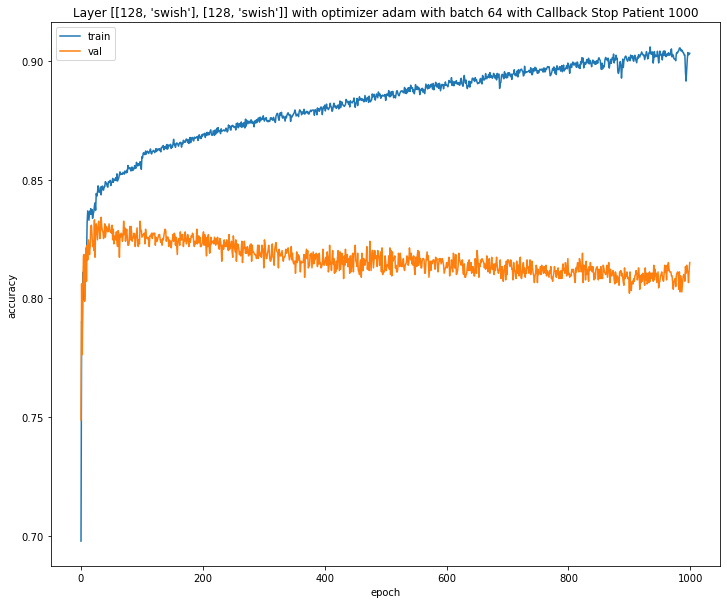

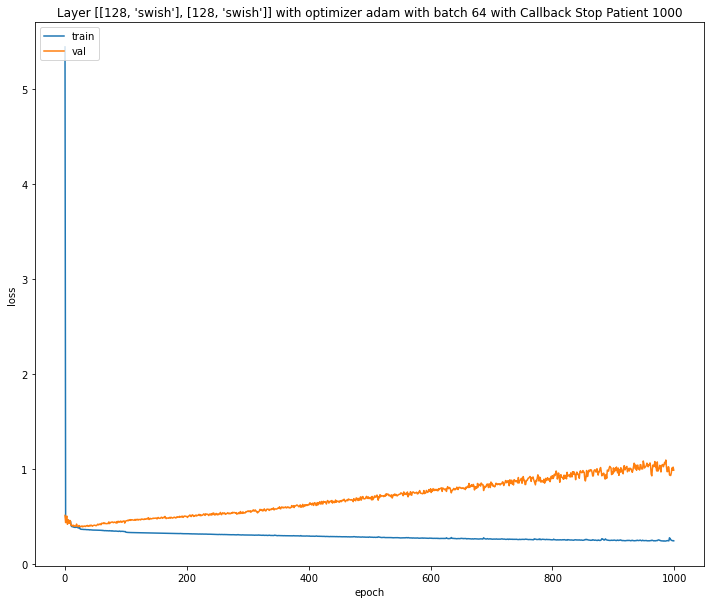

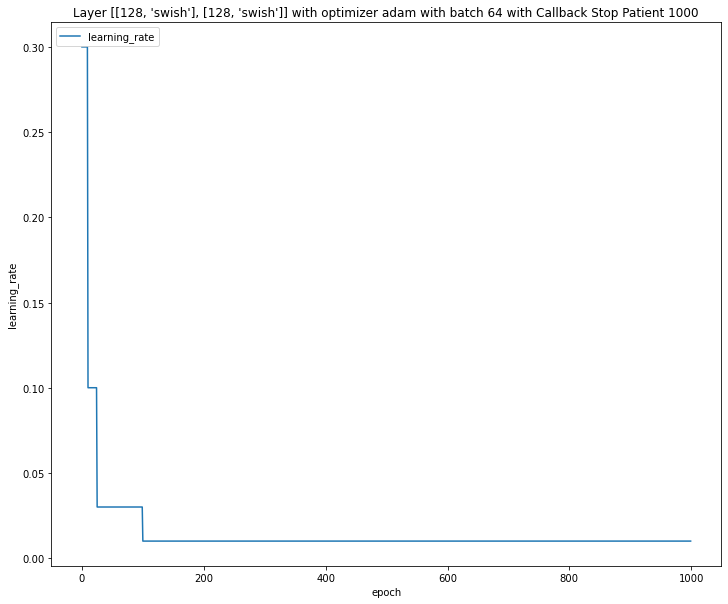

--- ANN with hidden layers [[128, 'swish'], [128, 'swish']], batch size 14232, epoch size 1000, optimizer adam  ---
[128, 'swish']
[[[16, 'lisht']], [[128, 'lisht']], [[128, 'lisht'], [128, 'lisht']], [[128, 'swish'], [128, 'swish']]]
[128, 'swish']
[[[16, 'lisht']], [[128, 'lisht']], [[128, 'lisht'], [128, 'lisht']], [[128, 'swish'], [128, 'swish']]]
Epoch 1/1000
1/1 [==============================] - 0s 166ms/step - loss: 0.7893 - accuracy: 0.4852 - val_loss: 7.2477 - val_accuracy: 0.6728


C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(
C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


Epoch 2/1000
1/1 [==============================] - 0s 119ms/step - loss: 7.2061 - accuracy: 0.6752 - val_loss: 121.9824 - val_accuracy: 0.5053
Epoch 3/1000
1/1 [==============================] - 0s 99ms/step - loss: 125.1556 - accuracy: 0.4941 - val_loss: 603.6064 - val_accuracy: 0.4935
Epoch 4/1000
1/1 [==============================] - 0s 102ms/step - loss: 615.5596 - accuracy: 0.5033 - val_loss: 102.9541 - val_accuracy: 0.4935
Epoch 5/1000
1/1 [==============================] - 0s 106ms/step - loss: 104.8101 - accuracy: 0.5033 - val_loss: 15.2326 - val_accuracy: 0.4002
Epoch 6/1000
1/1 [==============================] - 0s 102ms/step - loss: 16.4963 - accuracy: 0.4068 - val_loss: 7.4999 - val_accuracy: 0.6481
Epoch 7/1000
1/1 [==============================] - 0s 96ms/step - loss: 7.5603 - accuracy: 0.6719 - val_loss: 7.6632 - val_accuracy: 0.6453
Epoch 8/1000
1/1 [==============================] - 0s 98ms/step - loss: 7.7183 - accuracy: 0.6563 - val_loss: 9.9373 - val_accuracy: 0.

1/1 [==============================] - 0s 89ms/step - loss: 0.6064 - accuracy: 0.7690 - val_loss: 0.6463 - val_accuracy: 0.7594
Epoch 60/1000
1/1 [==============================] - 0s 96ms/step - loss: 0.5873 - accuracy: 0.7745 - val_loss: 0.6232 - val_accuracy: 0.7740
Epoch 61/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.5661 - accuracy: 0.7809 - val_loss: 0.6096 - val_accuracy: 0.7791
Epoch 62/1000
1/1 [==============================] - 0s 87ms/step - loss: 0.5539 - accuracy: 0.7845 - val_loss: 0.6143 - val_accuracy: 0.7718
Epoch 63/1000
1/1 [==============================] - 0s 105ms/step - loss: 0.5591 - accuracy: 0.7806 - val_loss: 0.6186 - val_accuracy: 0.7701
Epoch 64/1000
1/1 [==============================] - 0s 90ms/step - loss: 0.5645 - accuracy: 0.7768 - val_loss: 0.6007 - val_accuracy: 0.7785
Epoch 65/1000
1/1 [==============================] - 0s 90ms/step - loss: 0.5492 - accuracy: 0.7847 - val_loss: 0.5898 - val_accuracy: 0.7780
Epoch 66/1000
1/1 [

1/1 [==============================] - 0s 95ms/step - loss: 0.4565 - accuracy: 0.8033 - val_loss: 0.4825 - val_accuracy: 0.8021
Epoch 117/1000
1/1 [==============================] - 0s 103ms/step - loss: 0.4562 - accuracy: 0.8033 - val_loss: 0.4823 - val_accuracy: 0.8021
Epoch 118/1000
1/1 [==============================] - 0s 93ms/step - loss: 0.4560 - accuracy: 0.8039 - val_loss: 0.4821 - val_accuracy: 0.8027
Epoch 119/1000
1/1 [==============================] - 0s 93ms/step - loss: 0.4557 - accuracy: 0.8037 - val_loss: 0.4818 - val_accuracy: 0.8027
Epoch 120/1000
1/1 [==============================] - 0s 91ms/step - loss: 0.4554 - accuracy: 0.8038 - val_loss: 0.4814 - val_accuracy: 0.8021
Epoch 121/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.4551 - accuracy: 0.8039 - val_loss: 0.4810 - val_accuracy: 0.8027
Epoch 122/1000
1/1 [==============================] - 0s 96ms/step - loss: 0.4548 - accuracy: 0.8039 - val_loss: 0.4806 - val_accuracy: 0.8027
Epoch 123/10

1/1 [==============================] - 0s 94ms/step - loss: 0.4427 - accuracy: 0.8068 - val_loss: 0.4684 - val_accuracy: 0.8072
Epoch 174/1000
1/1 [==============================] - 0s 96ms/step - loss: 0.4425 - accuracy: 0.8068 - val_loss: 0.4682 - val_accuracy: 0.8066
Epoch 175/1000
1/1 [==============================] - 0s 93ms/step - loss: 0.4423 - accuracy: 0.8069 - val_loss: 0.4680 - val_accuracy: 0.8066
Epoch 176/1000
1/1 [==============================] - 0s 85ms/step - loss: 0.4421 - accuracy: 0.8071 - val_loss: 0.4678 - val_accuracy: 0.8066
Epoch 177/1000
1/1 [==============================] - 0s 86ms/step - loss: 0.4419 - accuracy: 0.8069 - val_loss: 0.4676 - val_accuracy: 0.8066
Epoch 178/1000
1/1 [==============================] - 0s 93ms/step - loss: 0.4417 - accuracy: 0.8071 - val_loss: 0.4674 - val_accuracy: 0.8061
Epoch 179/1000
1/1 [==============================] - 0s 95ms/step - loss: 0.4415 - accuracy: 0.8071 - val_loss: 0.4672 - val_accuracy: 0.8061
Epoch 180/1000

1/1 [==============================] - 0s 88ms/step - loss: 0.4322 - accuracy: 0.8111 - val_loss: 0.4584 - val_accuracy: 0.8106
Epoch 231/1000
1/1 [==============================] - 0s 98ms/step - loss: 0.4321 - accuracy: 0.8111 - val_loss: 0.4583 - val_accuracy: 0.8106
Epoch 232/1000
1/1 [==============================] - 0s 95ms/step - loss: 0.4319 - accuracy: 0.8111 - val_loss: 0.4581 - val_accuracy: 0.8106
Epoch 233/1000
1/1 [==============================] - 0s 99ms/step - loss: 0.4317 - accuracy: 0.8111 - val_loss: 0.4579 - val_accuracy: 0.8106
Epoch 234/1000
1/1 [==============================] - 0s 95ms/step - loss: 0.4316 - accuracy: 0.8111 - val_loss: 0.4578 - val_accuracy: 0.8106
Epoch 235/1000
1/1 [==============================] - 0s 88ms/step - loss: 0.4314 - accuracy: 0.8111 - val_loss: 0.4576 - val_accuracy: 0.8100
Epoch 236/1000
1/1 [==============================] - 0s 89ms/step - loss: 0.4312 - accuracy: 0.8113 - val_loss: 0.4574 - val_accuracy: 0.8100
Epoch 237/1000

1/1 [==============================] - 0s 90ms/step - loss: 0.4234 - accuracy: 0.8133 - val_loss: 0.4499 - val_accuracy: 0.8123
Epoch 288/1000
1/1 [==============================] - 0s 90ms/step - loss: 0.4233 - accuracy: 0.8132 - val_loss: 0.4498 - val_accuracy: 0.8123
Epoch 289/1000
1/1 [==============================] - 0s 90ms/step - loss: 0.4231 - accuracy: 0.8132 - val_loss: 0.4497 - val_accuracy: 0.8123
Epoch 290/1000
1/1 [==============================] - 0s 85ms/step - loss: 0.4230 - accuracy: 0.8132 - val_loss: 0.4495 - val_accuracy: 0.8123
Epoch 291/1000
1/1 [==============================] - 0s 88ms/step - loss: 0.4228 - accuracy: 0.8132 - val_loss: 0.4494 - val_accuracy: 0.8123
Epoch 292/1000
1/1 [==============================] - 0s 96ms/step - loss: 0.4227 - accuracy: 0.8132 - val_loss: 0.4493 - val_accuracy: 0.8123
Epoch 293/1000
1/1 [==============================] - 0s 99ms/step - loss: 0.4226 - accuracy: 0.8132 - val_loss: 0.4492 - val_accuracy: 0.8123
Epoch 294/1000

1/1 [==============================] - 0s 93ms/step - loss: 0.4164 - accuracy: 0.8163 - val_loss: 0.4435 - val_accuracy: 0.8145
Epoch 345/1000
1/1 [==============================] - 0s 90ms/step - loss: 0.4163 - accuracy: 0.8163 - val_loss: 0.4434 - val_accuracy: 0.8145
Epoch 346/1000
1/1 [==============================] - 0s 91ms/step - loss: 0.4162 - accuracy: 0.8163 - val_loss: 0.4433 - val_accuracy: 0.8145
Epoch 347/1000
1/1 [==============================] - 0s 91ms/step - loss: 0.4161 - accuracy: 0.8164 - val_loss: 0.4432 - val_accuracy: 0.8145
Epoch 348/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.4160 - accuracy: 0.8162 - val_loss: 0.4431 - val_accuracy: 0.8151
Epoch 349/1000
1/1 [==============================] - 0s 91ms/step - loss: 0.4159 - accuracy: 0.8163 - val_loss: 0.4429 - val_accuracy: 0.8145
Epoch 350/1000
1/1 [==============================] - 0s 90ms/step - loss: 0.4158 - accuracy: 0.8161 - val_loss: 0.4428 - val_accuracy: 0.8145
Epoch 351/1000

1/1 [==============================] - 0s 89ms/step - loss: 0.4107 - accuracy: 0.8182 - val_loss: 0.4377 - val_accuracy: 0.8162
Epoch 402/1000
1/1 [==============================] - 0s 90ms/step - loss: 0.4106 - accuracy: 0.8182 - val_loss: 0.4376 - val_accuracy: 0.8156
Epoch 403/1000
1/1 [==============================] - 0s 91ms/step - loss: 0.4105 - accuracy: 0.8182 - val_loss: 0.4375 - val_accuracy: 0.8162
Epoch 404/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.4104 - accuracy: 0.8182 - val_loss: 0.4374 - val_accuracy: 0.8162
Epoch 405/1000
1/1 [==============================] - 0s 84ms/step - loss: 0.4103 - accuracy: 0.8182 - val_loss: 0.4373 - val_accuracy: 0.8162
Epoch 406/1000
1/1 [==============================] - 0s 92ms/step - loss: 0.4102 - accuracy: 0.8182 - val_loss: 0.4372 - val_accuracy: 0.8162
Epoch 407/1000
1/1 [==============================] - 0s 92ms/step - loss: 0.4101 - accuracy: 0.8183 - val_loss: 0.4372 - val_accuracy: 0.8162
Epoch 408/1000

1/1 [==============================] - 0s 90ms/step - loss: 0.4057 - accuracy: 0.8201 - val_loss: 0.4330 - val_accuracy: 0.8139
Epoch 459/1000
1/1 [==============================] - 0s 92ms/step - loss: 0.4057 - accuracy: 0.8201 - val_loss: 0.4330 - val_accuracy: 0.8139
Epoch 460/1000
1/1 [==============================] - 0s 88ms/step - loss: 0.4056 - accuracy: 0.8203 - val_loss: 0.4329 - val_accuracy: 0.8145
Epoch 461/1000
1/1 [==============================] - 0s 87ms/step - loss: 0.4055 - accuracy: 0.8203 - val_loss: 0.4328 - val_accuracy: 0.8145
Epoch 462/1000
1/1 [==============================] - 0s 91ms/step - loss: 0.4054 - accuracy: 0.8202 - val_loss: 0.4327 - val_accuracy: 0.8151
Epoch 463/1000
1/1 [==============================] - 0s 88ms/step - loss: 0.4053 - accuracy: 0.8203 - val_loss: 0.4327 - val_accuracy: 0.8151
Epoch 464/1000
1/1 [==============================] - 0s 95ms/step - loss: 0.4053 - accuracy: 0.8204 - val_loss: 0.4326 - val_accuracy: 0.8145
Epoch 465/1000

1/1 [==============================] - 0s 97ms/step - loss: 0.4015 - accuracy: 0.8223 - val_loss: 0.4292 - val_accuracy: 0.8156
Epoch 516/1000
1/1 [==============================] - 0s 93ms/step - loss: 0.4014 - accuracy: 0.8224 - val_loss: 0.4292 - val_accuracy: 0.8156
Epoch 517/1000
1/1 [==============================] - 0s 91ms/step - loss: 0.4013 - accuracy: 0.8226 - val_loss: 0.4291 - val_accuracy: 0.8156
Epoch 518/1000
1/1 [==============================] - 0s 91ms/step - loss: 0.4013 - accuracy: 0.8227 - val_loss: 0.4290 - val_accuracy: 0.8156
Epoch 519/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.4012 - accuracy: 0.8227 - val_loss: 0.4290 - val_accuracy: 0.8156
Epoch 520/1000
1/1 [==============================] - 0s 91ms/step - loss: 0.4011 - accuracy: 0.8228 - val_loss: 0.4289 - val_accuracy: 0.8156
Epoch 521/1000
1/1 [==============================] - 0s 90ms/step - loss: 0.4011 - accuracy: 0.8229 - val_loss: 0.4289 - val_accuracy: 0.8156
Epoch 522/1000

1/1 [==============================] - 0s 91ms/step - loss: 0.3976 - accuracy: 0.8248 - val_loss: 0.4260 - val_accuracy: 0.8151
Epoch 573/1000
1/1 [==============================] - 0s 87ms/step - loss: 0.3976 - accuracy: 0.8248 - val_loss: 0.4260 - val_accuracy: 0.8151
Epoch 574/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.3975 - accuracy: 0.8250 - val_loss: 0.4259 - val_accuracy: 0.8151
Epoch 575/1000
1/1 [==============================] - 0s 97ms/step - loss: 0.3974 - accuracy: 0.8250 - val_loss: 0.4259 - val_accuracy: 0.8162
Epoch 576/1000
1/1 [==============================] - 0s 95ms/step - loss: 0.3974 - accuracy: 0.8250 - val_loss: 0.4258 - val_accuracy: 0.8162
Epoch 577/1000
1/1 [==============================] - 0s 89ms/step - loss: 0.3973 - accuracy: 0.8250 - val_loss: 0.4258 - val_accuracy: 0.8162
Epoch 578/1000
1/1 [==============================] - 0s 98ms/step - loss: 0.3973 - accuracy: 0.8251 - val_loss: 0.4257 - val_accuracy: 0.8168
Epoch 579/1000

1/1 [==============================] - 0s 91ms/step - loss: 0.3944 - accuracy: 0.8265 - val_loss: 0.4236 - val_accuracy: 0.8168
Epoch 630/1000
1/1 [==============================] - 0s 87ms/step - loss: 0.3943 - accuracy: 0.8265 - val_loss: 0.4235 - val_accuracy: 0.8168
Epoch 631/1000
1/1 [==============================] - 0s 102ms/step - loss: 0.3943 - accuracy: 0.8265 - val_loss: 0.4235 - val_accuracy: 0.8162
Epoch 632/1000
1/1 [==============================] - 0s 100ms/step - loss: 0.3942 - accuracy: 0.8266 - val_loss: 0.4234 - val_accuracy: 0.8162
Epoch 633/1000
1/1 [==============================] - 0s 99ms/step - loss: 0.3942 - accuracy: 0.8267 - val_loss: 0.4234 - val_accuracy: 0.8162
Epoch 634/1000
1/1 [==============================] - 0s 90ms/step - loss: 0.3941 - accuracy: 0.8268 - val_loss: 0.4234 - val_accuracy: 0.8162
Epoch 635/1000
1/1 [==============================] - 0s 92ms/step - loss: 0.3941 - accuracy: 0.8269 - val_loss: 0.4233 - val_accuracy: 0.8162
Epoch 636/10

1/1 [==============================] - 0s 87ms/step - loss: 0.3916 - accuracy: 0.8281 - val_loss: 0.4218 - val_accuracy: 0.8168
Epoch 687/1000
1/1 [==============================] - 0s 93ms/step - loss: 0.3915 - accuracy: 0.8282 - val_loss: 0.4217 - val_accuracy: 0.8173
Epoch 688/1000
1/1 [==============================] - 0s 95ms/step - loss: 0.3915 - accuracy: 0.8281 - val_loss: 0.4217 - val_accuracy: 0.8173
Epoch 689/1000
1/1 [==============================] - 0s 96ms/step - loss: 0.3914 - accuracy: 0.8281 - val_loss: 0.4217 - val_accuracy: 0.8173
Epoch 690/1000
1/1 [==============================] - 0s 87ms/step - loss: 0.3914 - accuracy: 0.8281 - val_loss: 0.4217 - val_accuracy: 0.8173
Epoch 691/1000
1/1 [==============================] - 0s 93ms/step - loss: 0.3913 - accuracy: 0.8282 - val_loss: 0.4216 - val_accuracy: 0.8173
Epoch 692/1000
1/1 [==============================] - 0s 92ms/step - loss: 0.3913 - accuracy: 0.8283 - val_loss: 0.4216 - val_accuracy: 0.8173
Epoch 693/1000

1/1 [==============================] - 0s 89ms/step - loss: 0.3891 - accuracy: 0.8301 - val_loss: 0.4204 - val_accuracy: 0.8162
Epoch 744/1000
1/1 [==============================] - 0s 91ms/step - loss: 0.3891 - accuracy: 0.8301 - val_loss: 0.4203 - val_accuracy: 0.8162
Epoch 745/1000
1/1 [==============================] - 0s 95ms/step - loss: 0.3891 - accuracy: 0.8301 - val_loss: 0.4203 - val_accuracy: 0.8162
Epoch 746/1000
1/1 [==============================] - 0s 93ms/step - loss: 0.3890 - accuracy: 0.8302 - val_loss: 0.4203 - val_accuracy: 0.8156
Epoch 747/1000
1/1 [==============================] - 0s 97ms/step - loss: 0.3890 - accuracy: 0.8302 - val_loss: 0.4203 - val_accuracy: 0.8156
Epoch 748/1000
1/1 [==============================] - 0s 91ms/step - loss: 0.3889 - accuracy: 0.8303 - val_loss: 0.4203 - val_accuracy: 0.8156
Epoch 749/1000
1/1 [==============================] - 0s 99ms/step - loss: 0.3889 - accuracy: 0.8303 - val_loss: 0.4202 - val_accuracy: 0.8156
Epoch 750/1000

1/1 [==============================] - 0s 97ms/step - loss: 0.3870 - accuracy: 0.8309 - val_loss: 0.4192 - val_accuracy: 0.8156
Epoch 801/1000
1/1 [==============================] - 0s 101ms/step - loss: 0.3869 - accuracy: 0.8309 - val_loss: 0.4192 - val_accuracy: 0.8156
Epoch 802/1000
1/1 [==============================] - 0s 92ms/step - loss: 0.3869 - accuracy: 0.8309 - val_loss: 0.4191 - val_accuracy: 0.8156
Epoch 803/1000
1/1 [==============================] - 0s 93ms/step - loss: 0.3869 - accuracy: 0.8309 - val_loss: 0.4191 - val_accuracy: 0.8156
Epoch 804/1000
1/1 [==============================] - 0s 89ms/step - loss: 0.3868 - accuracy: 0.8309 - val_loss: 0.4191 - val_accuracy: 0.8156
Epoch 805/1000
1/1 [==============================] - 0s 90ms/step - loss: 0.3868 - accuracy: 0.8311 - val_loss: 0.4191 - val_accuracy: 0.8156
Epoch 806/1000
1/1 [==============================] - 0s 98ms/step - loss: 0.3868 - accuracy: 0.8311 - val_loss: 0.4191 - val_accuracy: 0.8156
Epoch 807/100

1/1 [==============================] - 0s 91ms/step - loss: 0.3850 - accuracy: 0.8322 - val_loss: 0.4182 - val_accuracy: 0.8168
Epoch 858/1000
1/1 [==============================] - 0s 90ms/step - loss: 0.3849 - accuracy: 0.8323 - val_loss: 0.4182 - val_accuracy: 0.8168
Epoch 859/1000
1/1 [==============================] - 0s 89ms/step - loss: 0.3849 - accuracy: 0.8323 - val_loss: 0.4182 - val_accuracy: 0.8168
Epoch 860/1000
1/1 [==============================] - 0s 90ms/step - loss: 0.3849 - accuracy: 0.8323 - val_loss: 0.4182 - val_accuracy: 0.8168
Epoch 861/1000
1/1 [==============================] - 0s 88ms/step - loss: 0.3848 - accuracy: 0.8324 - val_loss: 0.4181 - val_accuracy: 0.8168
Epoch 862/1000
1/1 [==============================] - 0s 95ms/step - loss: 0.3848 - accuracy: 0.8325 - val_loss: 0.4181 - val_accuracy: 0.8168
Epoch 863/1000
1/1 [==============================] - 0s 91ms/step - loss: 0.3848 - accuracy: 0.8324 - val_loss: 0.4181 - val_accuracy: 0.8168
Epoch 864/1000

1/1 [==============================] - 0s 90ms/step - loss: 0.3831 - accuracy: 0.8331 - val_loss: 0.4174 - val_accuracy: 0.8196
Epoch 915/1000
1/1 [==============================] - 0s 96ms/step - loss: 0.3831 - accuracy: 0.8331 - val_loss: 0.4174 - val_accuracy: 0.8196
Epoch 916/1000
1/1 [==============================] - 0s 87ms/step - loss: 0.3830 - accuracy: 0.8331 - val_loss: 0.4174 - val_accuracy: 0.8196
Epoch 917/1000
1/1 [==============================] - 0s 95ms/step - loss: 0.3830 - accuracy: 0.8331 - val_loss: 0.4174 - val_accuracy: 0.8196
Epoch 918/1000
1/1 [==============================] - 0s 88ms/step - loss: 0.3830 - accuracy: 0.8331 - val_loss: 0.4174 - val_accuracy: 0.8196
Epoch 919/1000
1/1 [==============================] - 0s 91ms/step - loss: 0.3829 - accuracy: 0.8331 - val_loss: 0.4174 - val_accuracy: 0.8196
Epoch 920/1000
1/1 [==============================] - 0s 95ms/step - loss: 0.3829 - accuracy: 0.8331 - val_loss: 0.4174 - val_accuracy: 0.8196
Epoch 921/1000

1/1 [==============================] - 0s 97ms/step - loss: 0.3813 - accuracy: 0.8340 - val_loss: 0.4168 - val_accuracy: 0.8196
Epoch 972/1000
1/1 [==============================] - 0s 87ms/step - loss: 0.3813 - accuracy: 0.8340 - val_loss: 0.4168 - val_accuracy: 0.8196
Epoch 973/1000
1/1 [==============================] - 0s 108ms/step - loss: 0.3813 - accuracy: 0.8340 - val_loss: 0.4168 - val_accuracy: 0.8196
Epoch 974/1000
1/1 [==============================] - 0s 96ms/step - loss: 0.3812 - accuracy: 0.8340 - val_loss: 0.4168 - val_accuracy: 0.8196
Epoch 975/1000
1/1 [==============================] - 0s 89ms/step - loss: 0.3812 - accuracy: 0.8340 - val_loss: 0.4168 - val_accuracy: 0.8196
Epoch 976/1000
1/1 [==============================] - 0s 89ms/step - loss: 0.3812 - accuracy: 0.8340 - val_loss: 0.4168 - val_accuracy: 0.8196
Epoch 977/1000
1/1 [==============================] - 0s 104ms/step - loss: 0.3811 - accuracy: 0.8340 - val_loss: 0.4168 - val_accuracy: 0.8201
Epoch 978/10

C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


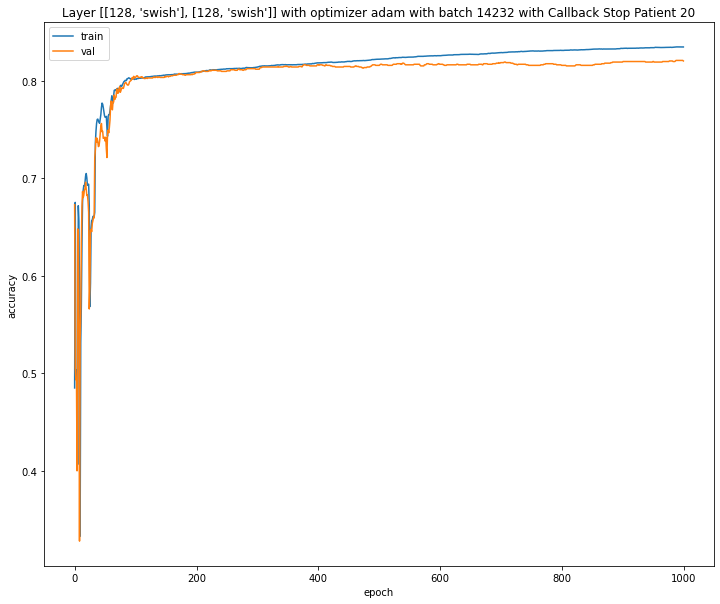

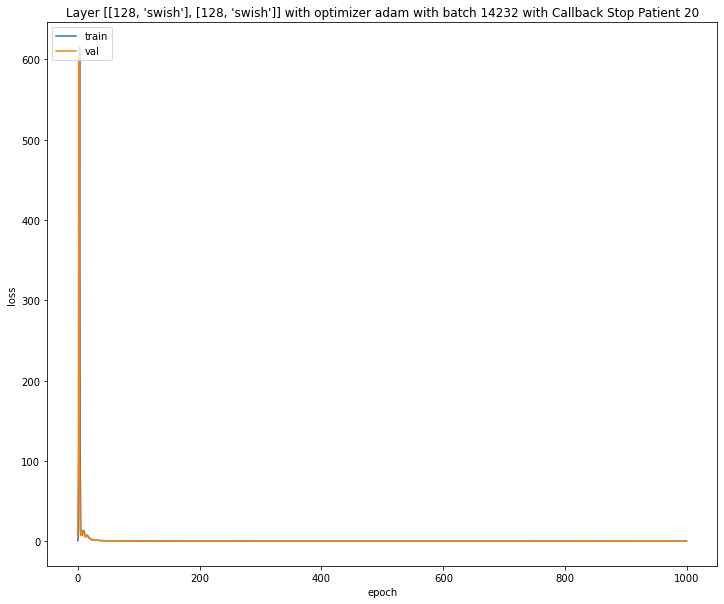

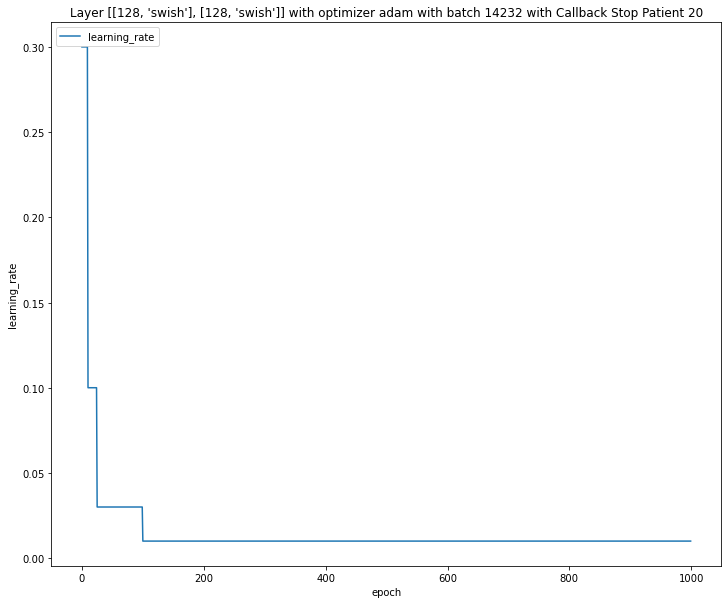

--- ANN with hidden layers [[128, 'swish'], [128, 'swish']], batch size 14232, epoch size 1000, optimizer adam  ---
[128, 'swish']
[[[16, 'lisht']], [[128, 'lisht']], [[128, 'lisht'], [128, 'lisht']], [[128, 'swish'], [128, 'swish']]]
[128, 'swish']
[[[16, 'lisht']], [[128, 'lisht']], [[128, 'lisht'], [128, 'lisht']], [[128, 'swish'], [128, 'swish']]]
Epoch 1/1000
1/1 [==============================] - ETA: 0s - loss: 0.6977 - accuracy: 0.4967

C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(
C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 155ms/step - loss: 0.6977 - accuracy: 0.4967 - val_loss: 4.9467 - val_accuracy: 0.6976
Epoch 2/1000
1/1 [==============================] - 0s 91ms/step - loss: 4.8892 - accuracy: 0.7062 - val_loss: 69.9362 - val_accuracy: 0.4109
Epoch 3/1000
1/1 [==============================] - 0s 102ms/step - loss: 68.6110 - accuracy: 0.4129 - val_loss: 36.4109 - val_accuracy: 0.7206
Epoch 4/1000
1/1 [==============================] - 0s 94ms/step - loss: 36.1420 - accuracy: 0.7234 - val_loss: 57.2568 - val_accuracy: 0.7083
Epoch 5/1000
1/1 [==============================] - 0s 104ms/step - loss: 58.0446 - accuracy: 0.7021 - val_loss: 33.4386 - val_accuracy: 0.5644
Epoch 6/1000
1/1 [==============================] - 0s 102ms/step - loss: 34.6938 - accuracy: 0.5680 - val_loss: 292.5157 - val_accuracy: 0.3007
Epoch 7/1000
1/1 [==============================] - 0s 96ms/step - loss: 279.7560 - accuracy: 0.3092 - val_loss: 11.3953 - val_accuracy: 0.7448
Epoch 8/1

1/1 [==============================] - 0s 100ms/step - loss: 0.6393 - accuracy: 0.6644 - val_loss: 0.6525 - val_accuracy: 0.6796
Epoch 59/1000
1/1 [==============================] - 0s 102ms/step - loss: 0.6374 - accuracy: 0.6693 - val_loss: 0.6513 - val_accuracy: 0.6790
Epoch 60/1000
1/1 [==============================] - 0s 95ms/step - loss: 0.6355 - accuracy: 0.6729 - val_loss: 0.6498 - val_accuracy: 0.6875
Epoch 61/1000
1/1 [==============================] - 0s 93ms/step - loss: 0.6335 - accuracy: 0.6757 - val_loss: 0.6479 - val_accuracy: 0.6886
Epoch 62/1000
1/1 [==============================] - 0s 88ms/step - loss: 0.6315 - accuracy: 0.6794 - val_loss: 0.6455 - val_accuracy: 0.6880
Epoch 63/1000
1/1 [==============================] - 0s 104ms/step - loss: 0.6294 - accuracy: 0.6821 - val_loss: 0.6427 - val_accuracy: 0.6936
Epoch 64/1000
1/1 [==============================] - 0s 101ms/step - loss: 0.6271 - accuracy: 0.6856 - val_loss: 0.6395 - val_accuracy: 0.6959
Epoch 65/1000
1/

1/1 [==============================] - 0s 90ms/step - loss: 0.5316 - accuracy: 0.7672 - val_loss: 0.5327 - val_accuracy: 0.7858
Epoch 116/1000
1/1 [==============================] - 0s 90ms/step - loss: 0.5307 - accuracy: 0.7680 - val_loss: 0.5318 - val_accuracy: 0.7841
Epoch 117/1000
1/1 [==============================] - 0s 106ms/step - loss: 0.5299 - accuracy: 0.7681 - val_loss: 0.5309 - val_accuracy: 0.7836
Epoch 118/1000
1/1 [==============================] - 0s 105ms/step - loss: 0.5290 - accuracy: 0.7685 - val_loss: 0.5301 - val_accuracy: 0.7841
Epoch 119/1000
1/1 [==============================] - 0s 104ms/step - loss: 0.5282 - accuracy: 0.7691 - val_loss: 0.5292 - val_accuracy: 0.7841
Epoch 120/1000
1/1 [==============================] - 0s 100ms/step - loss: 0.5273 - accuracy: 0.7696 - val_loss: 0.5283 - val_accuracy: 0.7841
Epoch 121/1000
1/1 [==============================] - 0s 90ms/step - loss: 0.5265 - accuracy: 0.7706 - val_loss: 0.5275 - val_accuracy: 0.7847
Epoch 122/

1/1 [==============================] - 0s 89ms/step - loss: 0.4886 - accuracy: 0.7910 - val_loss: 0.4895 - val_accuracy: 0.8010
Epoch 173/1000
1/1 [==============================] - 0s 95ms/step - loss: 0.4879 - accuracy: 0.7910 - val_loss: 0.4889 - val_accuracy: 0.8004
Epoch 174/1000
1/1 [==============================] - 0s 97ms/step - loss: 0.4873 - accuracy: 0.7915 - val_loss: 0.4883 - val_accuracy: 0.8016
Epoch 175/1000
1/1 [==============================] - 0s 91ms/step - loss: 0.4867 - accuracy: 0.7915 - val_loss: 0.4877 - val_accuracy: 0.8016
Epoch 176/1000
1/1 [==============================] - 0s 90ms/step - loss: 0.4860 - accuracy: 0.7920 - val_loss: 0.4871 - val_accuracy: 0.8016
Epoch 177/1000
1/1 [==============================] - 0s 96ms/step - loss: 0.4854 - accuracy: 0.7926 - val_loss: 0.4865 - val_accuracy: 0.8010
Epoch 178/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.4848 - accuracy: 0.7930 - val_loss: 0.4860 - val_accuracy: 0.8010
Epoch 179/1000

1/1 [==============================] - 0s 101ms/step - loss: 0.4593 - accuracy: 0.8038 - val_loss: 0.4652 - val_accuracy: 0.8072
Epoch 230/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.4590 - accuracy: 0.8038 - val_loss: 0.4649 - val_accuracy: 0.8066
Epoch 231/1000
1/1 [==============================] - 0s 96ms/step - loss: 0.4586 - accuracy: 0.8042 - val_loss: 0.4646 - val_accuracy: 0.8066
Epoch 232/1000
1/1 [==============================] - 0s 93ms/step - loss: 0.4582 - accuracy: 0.8045 - val_loss: 0.4643 - val_accuracy: 0.8066
Epoch 233/1000
1/1 [==============================] - 0s 88ms/step - loss: 0.4578 - accuracy: 0.8049 - val_loss: 0.4640 - val_accuracy: 0.8072
Epoch 234/1000
1/1 [==============================] - 0s 90ms/step - loss: 0.4574 - accuracy: 0.8051 - val_loss: 0.4637 - val_accuracy: 0.8072
Epoch 235/1000
1/1 [==============================] - 0s 96ms/step - loss: 0.4570 - accuracy: 0.8054 - val_loss: 0.4633 - val_accuracy: 0.8066
Epoch 236/100

1/1 [==============================] - 0s 96ms/step - loss: 0.4410 - accuracy: 0.8118 - val_loss: 0.4501 - val_accuracy: 0.8049
Epoch 287/1000
1/1 [==============================] - 0s 95ms/step - loss: 0.4408 - accuracy: 0.8120 - val_loss: 0.4498 - val_accuracy: 0.8061
Epoch 288/1000
1/1 [==============================] - 0s 90ms/step - loss: 0.4405 - accuracy: 0.8120 - val_loss: 0.4496 - val_accuracy: 0.8061
Epoch 289/1000
1/1 [==============================] - 0s 96ms/step - loss: 0.4403 - accuracy: 0.8119 - val_loss: 0.4494 - val_accuracy: 0.8061
Epoch 290/1000
1/1 [==============================] - 0s 93ms/step - loss: 0.4400 - accuracy: 0.8119 - val_loss: 0.4492 - val_accuracy: 0.8066
Epoch 291/1000
1/1 [==============================] - 0s 92ms/step - loss: 0.4398 - accuracy: 0.8120 - val_loss: 0.4490 - val_accuracy: 0.8066
Epoch 292/1000
1/1 [==============================] - 0s 90ms/step - loss: 0.4396 - accuracy: 0.8124 - val_loss: 0.4488 - val_accuracy: 0.8066
Epoch 293/1000

1/1 [==============================] - 0s 92ms/step - loss: 0.4303 - accuracy: 0.8139 - val_loss: 0.4404 - val_accuracy: 0.8072
Epoch 344/1000
1/1 [==============================] - 0s 89ms/step - loss: 0.4301 - accuracy: 0.8139 - val_loss: 0.4403 - val_accuracy: 0.8072
Epoch 345/1000
1/1 [==============================] - 0s 92ms/step - loss: 0.4300 - accuracy: 0.8139 - val_loss: 0.4402 - val_accuracy: 0.8072
Epoch 346/1000
1/1 [==============================] - 0s 90ms/step - loss: 0.4298 - accuracy: 0.8140 - val_loss: 0.4401 - val_accuracy: 0.8072
Epoch 347/1000
1/1 [==============================] - 0s 90ms/step - loss: 0.4297 - accuracy: 0.8142 - val_loss: 0.4399 - val_accuracy: 0.8072
Epoch 348/1000
1/1 [==============================] - 0s 90ms/step - loss: 0.4295 - accuracy: 0.8141 - val_loss: 0.4398 - val_accuracy: 0.8072
Epoch 349/1000
1/1 [==============================] - 0s 92ms/step - loss: 0.4294 - accuracy: 0.8142 - val_loss: 0.4397 - val_accuracy: 0.8072
Epoch 350/1000

1/1 [==============================] - 0s 88ms/step - loss: 0.4230 - accuracy: 0.8160 - val_loss: 0.4348 - val_accuracy: 0.8100
Epoch 401/1000
1/1 [==============================] - 0s 90ms/step - loss: 0.4229 - accuracy: 0.8159 - val_loss: 0.4347 - val_accuracy: 0.8100
Epoch 402/1000
1/1 [==============================] - 0s 91ms/step - loss: 0.4228 - accuracy: 0.8159 - val_loss: 0.4346 - val_accuracy: 0.8106
Epoch 403/1000
1/1 [==============================] - 0s 89ms/step - loss: 0.4227 - accuracy: 0.8161 - val_loss: 0.4345 - val_accuracy: 0.8106
Epoch 404/1000
1/1 [==============================] - 0s 90ms/step - loss: 0.4226 - accuracy: 0.8160 - val_loss: 0.4345 - val_accuracy: 0.8106
Epoch 405/1000
1/1 [==============================] - 0s 91ms/step - loss: 0.4225 - accuracy: 0.8162 - val_loss: 0.4344 - val_accuracy: 0.8106
Epoch 406/1000
1/1 [==============================] - 0s 89ms/step - loss: 0.4224 - accuracy: 0.8163 - val_loss: 0.4343 - val_accuracy: 0.8106
Epoch 407/1000

1/1 [==============================] - 0s 98ms/step - loss: 0.4174 - accuracy: 0.8200 - val_loss: 0.4309 - val_accuracy: 0.8128
Epoch 458/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.4173 - accuracy: 0.8198 - val_loss: 0.4308 - val_accuracy: 0.8128
Epoch 459/1000
1/1 [==============================] - 0s 95ms/step - loss: 0.4172 - accuracy: 0.8200 - val_loss: 0.4307 - val_accuracy: 0.8128
Epoch 460/1000
1/1 [==============================] - 0s 95ms/step - loss: 0.4171 - accuracy: 0.8200 - val_loss: 0.4307 - val_accuracy: 0.8128
Epoch 461/1000
1/1 [==============================] - 0s 104ms/step - loss: 0.4170 - accuracy: 0.8199 - val_loss: 0.4306 - val_accuracy: 0.8128
Epoch 462/1000
1/1 [==============================] - 0s 108ms/step - loss: 0.4170 - accuracy: 0.8201 - val_loss: 0.4305 - val_accuracy: 0.8123
Epoch 463/1000
1/1 [==============================] - 0s 92ms/step - loss: 0.4169 - accuracy: 0.8201 - val_loss: 0.4305 - val_accuracy: 0.8123
Epoch 464/10

1/1 [==============================] - 0s 96ms/step - loss: 0.4125 - accuracy: 0.8230 - val_loss: 0.4275 - val_accuracy: 0.8173
Epoch 515/1000
1/1 [==============================] - 0s 102ms/step - loss: 0.4124 - accuracy: 0.8231 - val_loss: 0.4275 - val_accuracy: 0.8173
Epoch 516/1000
1/1 [==============================] - 0s 87ms/step - loss: 0.4123 - accuracy: 0.8232 - val_loss: 0.4274 - val_accuracy: 0.8168
Epoch 517/1000
1/1 [==============================] - 0s 92ms/step - loss: 0.4122 - accuracy: 0.8232 - val_loss: 0.4274 - val_accuracy: 0.8173
Epoch 518/1000
1/1 [==============================] - 0s 99ms/step - loss: 0.4121 - accuracy: 0.8234 - val_loss: 0.4273 - val_accuracy: 0.8173
Epoch 519/1000
1/1 [==============================] - 0s 95ms/step - loss: 0.4121 - accuracy: 0.8234 - val_loss: 0.4273 - val_accuracy: 0.8173
Epoch 520/1000
1/1 [==============================] - 0s 91ms/step - loss: 0.4120 - accuracy: 0.8234 - val_loss: 0.4272 - val_accuracy: 0.8173
Epoch 521/100

1/1 [==============================] - 0s 89ms/step - loss: 0.4080 - accuracy: 0.8248 - val_loss: 0.4247 - val_accuracy: 0.8201
Epoch 572/1000
1/1 [==============================] - 0s 91ms/step - loss: 0.4079 - accuracy: 0.8248 - val_loss: 0.4247 - val_accuracy: 0.8196
Epoch 573/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.4078 - accuracy: 0.8249 - val_loss: 0.4246 - val_accuracy: 0.8196
Epoch 574/1000
1/1 [==============================] - 0s 95ms/step - loss: 0.4077 - accuracy: 0.8250 - val_loss: 0.4246 - val_accuracy: 0.8196
Epoch 575/1000
1/1 [==============================] - 0s 95ms/step - loss: 0.4077 - accuracy: 0.8251 - val_loss: 0.4245 - val_accuracy: 0.8196
Epoch 576/1000
1/1 [==============================] - 0s 88ms/step - loss: 0.4076 - accuracy: 0.8250 - val_loss: 0.4245 - val_accuracy: 0.8190
Epoch 577/1000
1/1 [==============================] - 0s 87ms/step - loss: 0.4075 - accuracy: 0.8252 - val_loss: 0.4244 - val_accuracy: 0.8184
Epoch 578/1000

1/1 [==============================] - 0s 89ms/step - loss: 0.4041 - accuracy: 0.8255 - val_loss: 0.4223 - val_accuracy: 0.8224
Epoch 629/1000
1/1 [==============================] - 0s 89ms/step - loss: 0.4040 - accuracy: 0.8256 - val_loss: 0.4222 - val_accuracy: 0.8224
Epoch 630/1000
1/1 [==============================] - 0s 87ms/step - loss: 0.4040 - accuracy: 0.8257 - val_loss: 0.4222 - val_accuracy: 0.8224
Epoch 631/1000
1/1 [==============================] - 0s 92ms/step - loss: 0.4039 - accuracy: 0.8257 - val_loss: 0.4222 - val_accuracy: 0.8224
Epoch 632/1000
1/1 [==============================] - 0s 92ms/step - loss: 0.4039 - accuracy: 0.8258 - val_loss: 0.4221 - val_accuracy: 0.8224
Epoch 633/1000
1/1 [==============================] - 0s 92ms/step - loss: 0.4038 - accuracy: 0.8257 - val_loss: 0.4221 - val_accuracy: 0.8224
Epoch 634/1000
1/1 [==============================] - 0s 99ms/step - loss: 0.4038 - accuracy: 0.8260 - val_loss: 0.4221 - val_accuracy: 0.8224
Epoch 635/1000

1/1 [==============================] - 0s 87ms/step - loss: 0.4010 - accuracy: 0.8271 - val_loss: 0.4204 - val_accuracy: 0.8241
Epoch 686/1000
1/1 [==============================] - 0s 88ms/step - loss: 0.4009 - accuracy: 0.8271 - val_loss: 0.4203 - val_accuracy: 0.8241
Epoch 687/1000
1/1 [==============================] - 0s 91ms/step - loss: 0.4009 - accuracy: 0.8270 - val_loss: 0.4203 - val_accuracy: 0.8241
Epoch 688/1000
1/1 [==============================] - 0s 95ms/step - loss: 0.4008 - accuracy: 0.8270 - val_loss: 0.4203 - val_accuracy: 0.8241
Epoch 689/1000
1/1 [==============================] - 0s 89ms/step - loss: 0.4008 - accuracy: 0.8271 - val_loss: 0.4202 - val_accuracy: 0.8246
Epoch 690/1000
1/1 [==============================] - 0s 99ms/step - loss: 0.4007 - accuracy: 0.8272 - val_loss: 0.4202 - val_accuracy: 0.8246
Epoch 691/1000
1/1 [==============================] - 0s 89ms/step - loss: 0.4007 - accuracy: 0.8272 - val_loss: 0.4202 - val_accuracy: 0.8246
Epoch 692/1000

1/1 [==============================] - 0s 97ms/step - loss: 0.3982 - accuracy: 0.8287 - val_loss: 0.4192 - val_accuracy: 0.8212
Epoch 743/1000
1/1 [==============================] - 0s 87ms/step - loss: 0.3982 - accuracy: 0.8287 - val_loss: 0.4191 - val_accuracy: 0.8212
Epoch 744/1000
1/1 [==============================] - 0s 87ms/step - loss: 0.3981 - accuracy: 0.8287 - val_loss: 0.4191 - val_accuracy: 0.8207
Epoch 745/1000
1/1 [==============================] - 0s 92ms/step - loss: 0.3981 - accuracy: 0.8285 - val_loss: 0.4191 - val_accuracy: 0.8207
Epoch 746/1000
1/1 [==============================] - 0s 89ms/step - loss: 0.3980 - accuracy: 0.8286 - val_loss: 0.4191 - val_accuracy: 0.8207
Epoch 747/1000
1/1 [==============================] - 0s 88ms/step - loss: 0.3980 - accuracy: 0.8286 - val_loss: 0.4191 - val_accuracy: 0.8207
Epoch 748/1000
1/1 [==============================] - 0s 90ms/step - loss: 0.3979 - accuracy: 0.8286 - val_loss: 0.4190 - val_accuracy: 0.8201
Epoch 749/1000

1/1 [==============================] - 0s 88ms/step - loss: 0.3959 - accuracy: 0.8301 - val_loss: 0.4182 - val_accuracy: 0.8201
Epoch 800/1000
1/1 [==============================] - 0s 93ms/step - loss: 0.3958 - accuracy: 0.8302 - val_loss: 0.4182 - val_accuracy: 0.8196
Epoch 801/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.3958 - accuracy: 0.8302 - val_loss: 0.4181 - val_accuracy: 0.8196
Epoch 802/1000
1/1 [==============================] - 0s 87ms/step - loss: 0.3957 - accuracy: 0.8302 - val_loss: 0.4181 - val_accuracy: 0.8196
Epoch 803/1000
1/1 [==============================] - 0s 87ms/step - loss: 0.3957 - accuracy: 0.8302 - val_loss: 0.4181 - val_accuracy: 0.8207
Epoch 804/1000
1/1 [==============================] - 0s 92ms/step - loss: 0.3957 - accuracy: 0.8304 - val_loss: 0.4181 - val_accuracy: 0.8207
Epoch 805/1000
1/1 [==============================] - 0s 89ms/step - loss: 0.3956 - accuracy: 0.8305 - val_loss: 0.4181 - val_accuracy: 0.8207
Epoch 806/1000

1/1 [==============================] - 0s 89ms/step - loss: 0.3938 - accuracy: 0.8307 - val_loss: 0.4173 - val_accuracy: 0.8218
Epoch 857/1000
1/1 [==============================] - 0s 88ms/step - loss: 0.3938 - accuracy: 0.8308 - val_loss: 0.4172 - val_accuracy: 0.8218
Epoch 858/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.3938 - accuracy: 0.8308 - val_loss: 0.4172 - val_accuracy: 0.8218
Epoch 859/1000
1/1 [==============================] - 0s 87ms/step - loss: 0.3937 - accuracy: 0.8309 - val_loss: 0.4172 - val_accuracy: 0.8218
Epoch 860/1000
1/1 [==============================] - 0s 101ms/step - loss: 0.3937 - accuracy: 0.8307 - val_loss: 0.4172 - val_accuracy: 0.8218
Epoch 861/1000
1/1 [==============================] - 0s 90ms/step - loss: 0.3937 - accuracy: 0.8307 - val_loss: 0.4172 - val_accuracy: 0.8218
Epoch 862/1000
1/1 [==============================] - 0s 88ms/step - loss: 0.3936 - accuracy: 0.8307 - val_loss: 0.4172 - val_accuracy: 0.8218
Epoch 863/100

1/1 [==============================] - 0s 90ms/step - loss: 0.3919 - accuracy: 0.8305 - val_loss: 0.4163 - val_accuracy: 0.8212
Epoch 914/1000
1/1 [==============================] - 0s 88ms/step - loss: 0.3919 - accuracy: 0.8305 - val_loss: 0.4163 - val_accuracy: 0.8212
Epoch 915/1000
1/1 [==============================] - 0s 87ms/step - loss: 0.3919 - accuracy: 0.8306 - val_loss: 0.4163 - val_accuracy: 0.8212
Epoch 916/1000
1/1 [==============================] - 0s 90ms/step - loss: 0.3918 - accuracy: 0.8306 - val_loss: 0.4163 - val_accuracy: 0.8212
Epoch 917/1000
1/1 [==============================] - 0s 91ms/step - loss: 0.3918 - accuracy: 0.8307 - val_loss: 0.4163 - val_accuracy: 0.8212
Epoch 918/1000
1/1 [==============================] - 0s 87ms/step - loss: 0.3918 - accuracy: 0.8307 - val_loss: 0.4162 - val_accuracy: 0.8207
Epoch 919/1000
1/1 [==============================] - 0s 90ms/step - loss: 0.3917 - accuracy: 0.8307 - val_loss: 0.4162 - val_accuracy: 0.8207
Epoch 920/1000

1/1 [==============================] - 0s 88ms/step - loss: 0.3899 - accuracy: 0.8315 - val_loss: 0.4160 - val_accuracy: 0.8207
Epoch 971/1000
1/1 [==============================] - 0s 90ms/step - loss: 0.3898 - accuracy: 0.8316 - val_loss: 0.4160 - val_accuracy: 0.8207
Epoch 972/1000
1/1 [==============================] - 0s 89ms/step - loss: 0.3898 - accuracy: 0.8316 - val_loss: 0.4160 - val_accuracy: 0.8207
Epoch 973/1000
1/1 [==============================] - 0s 87ms/step - loss: 0.3898 - accuracy: 0.8316 - val_loss: 0.4160 - val_accuracy: 0.8207
Epoch 974/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.3897 - accuracy: 0.8316 - val_loss: 0.4160 - val_accuracy: 0.8207
Epoch 975/1000
1/1 [==============================] - 0s 84ms/step - loss: 0.3897 - accuracy: 0.8316 - val_loss: 0.4160 - val_accuracy: 0.8207
Epoch 976/1000
1/1 [==============================] - 0s 88ms/step - loss: 0.3897 - accuracy: 0.8316 - val_loss: 0.4160 - val_accuracy: 0.8207
Epoch 977/1000

C:\Users\Yusuf\.conda\envs\python3.8-venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3914: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


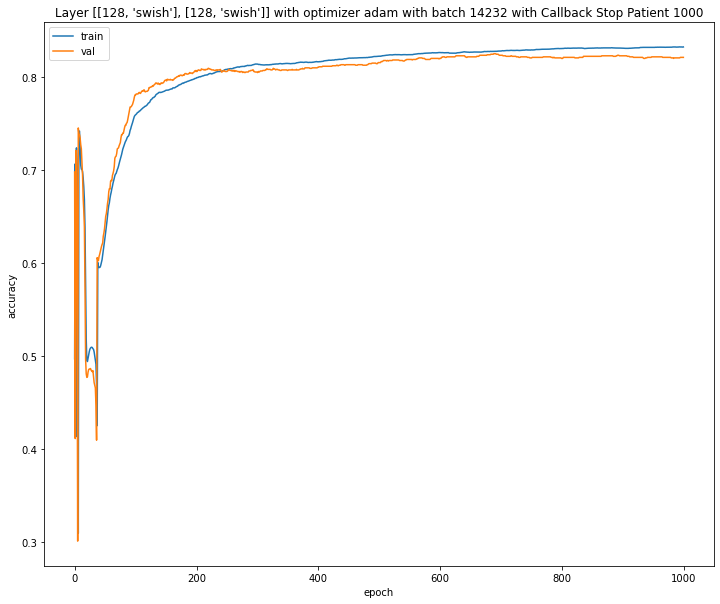

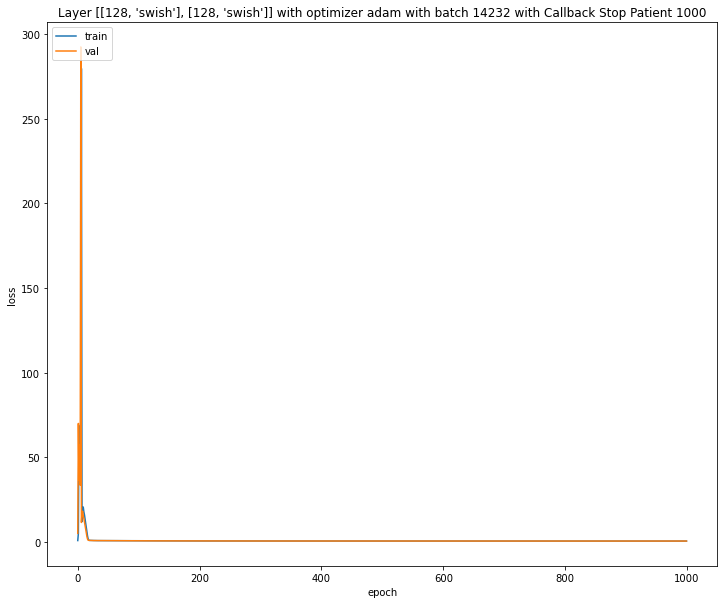

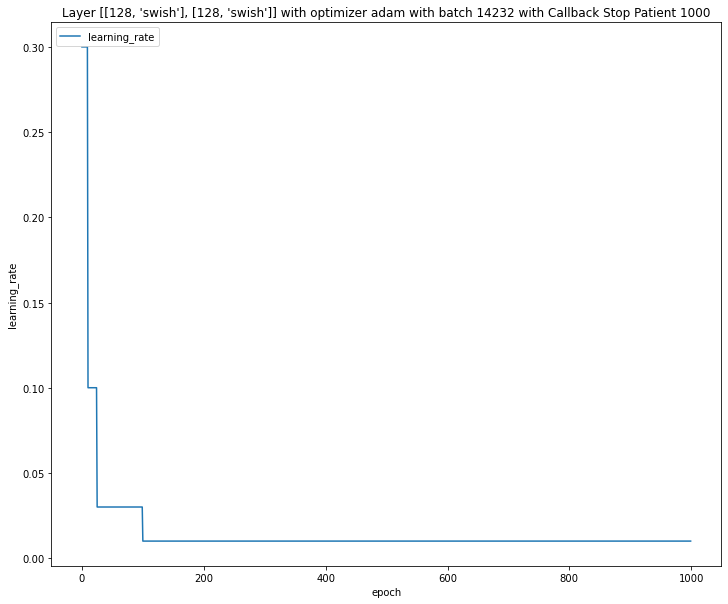

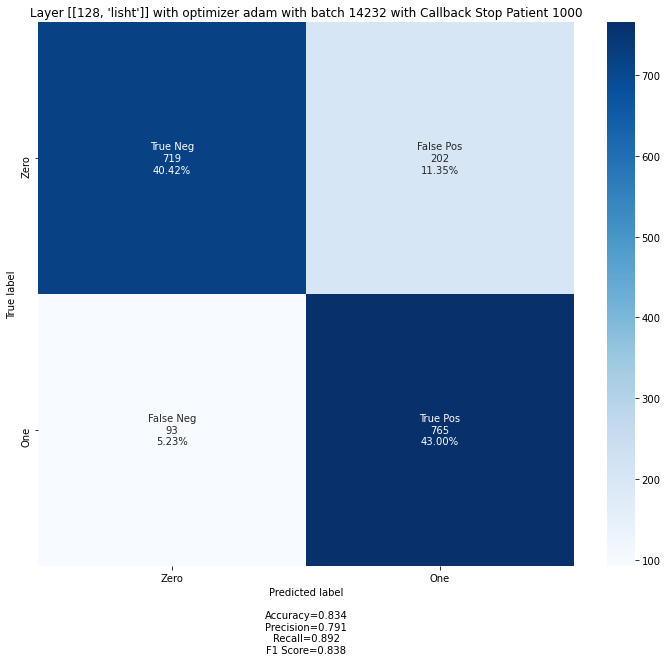

In [36]:
path_of_classifiers = "graphs/classifiers"  
path_ann = path_of_classifiers + "/ann"
Path(path_ann).mkdir(parents=True, exist_ok=True)

layer1 = [[16, 'lisht']]
layer2 = [[128, 'lisht']]
layer3 = [[128, 'lisht'], [128, 'lisht']]
layer4 = [[128, 'swish'], [128, 'swish']]


layers = [layer1, layer2, layer3, layer4]
optimizers = ['adam']
batchs = [64, X_train.shape[0]]
epochs = [1000]
callback_patients = [20, 1000]

ann_configuration_strings = []
ann_classifiers = []
ann_histories = []
ann_accuracy_scores = []
ann_predictions = []   
ann_actual_ys = []

for layer in layers:
    for optimizer in optimizers:
        for batch_size in batchs:
            for epoch_size in epochs:
                for callback_patient in callback_patients:
                    model, history, accuracy_score, y_pred, y_actual = ann(X_train, X_test, y_train, y_test, layer, batch_size, epoch_size, optimizer, callback_patient=callback_patient, input_size=X_train.shape[1])
                    configuration_string = "Layer {} with optimizer {} with batch {} with Callback Stop Patient {}".format(layer, optimizer, batch_size, callback_patient)

                    ann_configuration_strings.append(configuration_string)
                    ann_classifiers.append(model)
                    ann_histories.append(history)
                    ann_accuracy_scores.append(accuracy_score)
                    ann_predictions.append(y_pred)
                    ann_actual_ys.append(y_actual)
                    
                    plt.figure(figsize=(12,10))
                    plt.plot(history.history['accuracy'])
                    plt.plot(history.history['val_accuracy'])
                    plt.title(configuration_string)
                    plt.ylabel('accuracy')
                    plt.xlabel('epoch')
                    plt.legend(['train', 'val'], loc='upper left')
                    plt.savefig(path_ann + '/{}-accuracy.png'.format(configuration_string))

                    plt.show()

                    plt.figure(figsize=(12,10))
                    plt.plot(history.history['loss'])
                    plt.plot(history.history['val_loss'])
                    plt.title(configuration_string)
                    plt.ylabel('loss')
                    plt.xlabel('epoch')
                    plt.legend(['train', 'val'], loc='upper left')
                    plt.savefig(path_ann + '/{}-loss.png'.format(configuration_string))

                    plt.show()

                    plt.figure(figsize=(12,10))
                    plt.plot(history.history['lr'])
                    plt.title(configuration_string)
                    plt.ylabel('learning_rate')
                    plt.xlabel('epoch')
                    plt.legend(['learning_rate'], loc='upper left')
                    plt.savefig(path_ann + '/{}-learning_rate.png'.format(configuration_string))

                    plt.show()


                    #pd.DataFrame(history.history).plot(figsize=(12,10))
                    #plt.show()

best_index = ann_accuracy_scores.index(max(ann_accuracy_scores))
best_ann_clf = ann_classifiers[best_index]
          
cf = confusion_matrix(ann_actual_ys[best_index], ann_predictions[best_index])
labels = ["True Neg","False Pos","False Neg", "True Pos"]
categories = ["Zero", "One"]
make_confusion_matrix(cf, figsize=(12,10), group_names=labels, categories=categories, title=ann_configuration_strings[best_index], path=path_of_ann)

In [37]:
Path("classifiers_dump/").mkdir(parents=True, exist_ok=True)

# Dump classifiers
pickle.dump(robust_scaler_fitted, open("classifiers_dump/robustscaler.sav", 'wb'))
pickle.dump(best_svm_clf, open("classifiers_dump/svm_clf.sav", 'wb'))
pickle.dump(best_nb_clf, open("classifiers_dump/nb_clf.sav", 'wb'))
pickle.dump(best_knn_clf, open("classifiers_dump/knn_clf.sav", 'wb'))


# Tensorflow model is cannot be dump with pickle
best_ann_clf.save('saved_model/ann_clf')


INFO:tensorflow:Assets written to: saved_model/ann_clf\assets
